<a href="https://colab.research.google.com/github/NguyenThiHongLinh/TieuLuan2024/blob/main/Ti%E1%BB%83u_lu%E1%BA%ADn_Taiwan4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kết nối với drive, import thư viện

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Data tiểu luận'
! pip install pypots>=0.4

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data tiểu luận


In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from prettytable import PrettyTable
from numpy import mean
from numpy import std
# import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
# from pypots.data import load_specific_dataset, mcar, masked_fill
import torch
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.optim import Adam
from pypots.imputation import BRITS
from pypots.imputation import MRNN
from pypots.imputation import Transformer
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_mse
from pypots.utils.metrics import calc_rmse

In [3]:
dtype = {
    "station": str,
    "AMB_TEMP": int,
    "CH4": int,
    "CO": float,
    "NMHC": float,
    "NO": float,
    "NO2": int,
    "NOx": int,
    "O3": int,
    "PH_RAIN": str,
    "PM10": int,
    "PM2.5": int,
    "RAINFALL": str,
    "RAIN_COND": str,
    "RH": str,
    "SO2": int,
    "THC": float,
    "UVB": int,
    "WD_HR": int,
    "WIND_DIREC": int,
    "WIND_SPEED": float,
    "WS_HR": float
}


def clean_data(elem):
    elem = str(elem)
    if elem == None or elem == '':
        return np.NaN
    if any(x in elem for x in ["#", "*", "x"]):
        return np.NaN
    if any(x in elem for x in [".", "e"]):
        return float(elem)
    if elem in 'NR':
        return -1
    return int(elem)

converters = {
    "AMB_TEMP": clean_data,
    "CH4": clean_data,
    "CO": clean_data,
    "NMHC": clean_data,
    "NO": clean_data,
    "NO2": clean_data,
    "NOx": clean_data,
    "O3": clean_data,
    "PH_RAIN": clean_data,
    "PM10": clean_data,
    "PM2.5": clean_data,
    "RAINFALL": clean_data,
    "RAIN_COND": clean_data,
    "RH": clean_data,
    "SO2": clean_data,
    "THC": clean_data,
    "UVB": clean_data,
    "WD_HR": clean_data,
    "WIND_DIREC": clean_data,
    "WIND_SPEED": clean_data,
    "WS_HR": clean_data
}

## Load dataset, tính toán % dữ liệu bị thiếu

In [41]:
def load_taiwan2015():
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
  dataset['time'] = pd.to_datetime(dataset['time'])
  return dataset

In [42]:
# Compute % missing rate of a given dataset (as a DataFrame)
def missing_rate(dataset):
  total_missing = dataset.isnull().sum().sum()
  percent_missing = (total_missing / dataset.size) * 100
  return round(percent_missing,2)

## Tiền xử lý dữ liệu

In [43]:
def preprocess_taiwan2015(dataset):
    """The preprocessing function for dataset Air Quality Beijing.
    Parameters
    ----------
    dataset : raw dataset loaded from csv file.
    Returns
    -------
    dataset : pandas.DataFrame,
                A dataframe contains all time series vectors, distinguished by column 'station'.
    """
    print('Columns:', dataset.columns)

    # Giả sử dữ liệu ngày tháng nằm trong cột 'time', tách ngày và giờ
    if 'time' in dataset.columns:
        dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        dataset['hour'] = pd.to_datetime(dataset['time']).dt.hour
    else:
        raise KeyError("'time' column not found in dataset")

    # Kiểm tra và bổ sung các ngày thiếu
    stations = dataset['station'].unique()
    full_date_range = pd.date_range(start=dataset['date'].min(), end=dataset['date'].max(), freq='D')

    df_list = []
    for station in stations:
        station_data = dataset[dataset['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        for missing_date in missing_dates:
            missing_date_data = pd.DataFrame({
                'time': [pd.Timestamp(missing_date) + pd.Timedelta(hours=h) for h in range(24)],
                'station': station,
                'date': [missing_date] * 24,
                'hour': range(24)
            })
            station_data = pd.concat([station_data, missing_date_data], ignore_index=True)

        df_list.append(station_data)

    dataset = pd.concat(df_list, ignore_index=True)

    X = dataset
    print('X shape: ', X.shape)

    def apply_func(df_temp):  # pad and truncate to set the max length of samples as 24
        missing = list(set(range(0, 24)).difference(set(df_temp['hour'])))
        missing_part = pd.DataFrame({
            'time': [df_temp['time'].iloc[0].replace(hour=h) for h in missing],
            'hour': missing
        })
        df_temp = pd.concat(
            [df_temp, missing_part], ignore_index=False, sort=False
        )  # pad the sample's length to 24 if it doesn't have enough time steps
        df_temp = df_temp.set_index('time').sort_index().reset_index()
        df_temp = df_temp.iloc[:24]  # truncate
        return df_temp

    X = X.groupby(['station', 'date']).apply(apply_func)
    X = X.drop('hour', axis=1)
    X = X.drop('station', axis=1)
    X = X.drop('date', axis=1)
    X = X.reset_index()
    X = X.drop(["level_2"], axis=1)

    return X


## Biểu diễn dữ liệu bị thiếu

In [44]:
def display_missing_percent(dataset):
  total = dataset.isnull().sum().sort_values(ascending=False)
  percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  # plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of missing values', fontsize=15)
  plt.title('Percent missing data by feature', fontsize=15)
  missing_data.head

## Lọc và sắp xếp các bản ghi theo từng khu vực

In [8]:
def get_stat_by_station(dataset):
  myTable = PrettyTable(["No.","station","#Records","From date","To date"])
  # Split dataframe by RecordID
  j = 1
  classification=list(dataset['station'].unique())
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    myTable.add_row([j,
                     i,
                    format(pm1.shape[0], ','),
                    pm1['time'].values[0],
                    pm1['time'].values[pm1.shape[0]-1]])
  j+=1
  return myTable

## Biểu đồ phân phối tần suất thời gian

In [9]:
# Danh sách các bộ dữ liệu và tên của chúng
def timeGraph(dataset):

# Khởi tạo figure
  plt.figure(figsize=(10, 6))

  # Lặp qua từng bộ dữ liệu và tên
  for dataset, time_column in dataset:
      # Chuyển đổi cột thời gian sang định dạng datetime
      time_data = pd.to_datetime(dataset[time_column])
      # Trích xuất giờ từ các đối tượng datetime
      hours = [time.hour for time in time_data]
      # Vẽ biểu đồ histogram
      plt.hist(hours, bins=24, edgecolor='black', alpha=0.5, label=time_column)

  # Thiết lập tiêu đề và nhãn trục
  plt.xlabel('Giờ')
  plt.ylabel('Số lượng')
  plt.title('Phân phối tần suất của dữ liệu thời gian')
  plt.xticks(range(0, 24))
  plt.grid(True)
  plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
  plt.show()

In [10]:
def find_time_steps(data):
    data['time'] = pd.to_datetime(data['time'], errors='coerce')

    if data['time'].isnull().any():
        print("Có các giá trị không thể chuyển đổi sang datetime:")
        print(data[data['time'].isnull()])
        return

    # tính chu kỳ giữa các bản ghi
    column_datetime1 = data['time']
    time_diffs = column_datetime1.diff().dt.total_seconds().dropna()
    cycle_seconds = time_diffs.mode().iloc[0]
    print("The cycle duration appears to be approximately", cycle_seconds, "seconds.")

    # Xác định xem thời gian được ghi lại trong 24 giờ hay 12 giờ
    time_difference = (column_datetime1.iloc[-1] - column_datetime1.iloc[0]).total_seconds()
    if time_difference > 12 * 3600:  # 12 hours * 3600 seconds/hour
        print("The time cycle appears to be 24 hours.")
    else:
        print("The time cycle appears to be 12 hours.")

    # Tìm giờ bị thiếu của từng station nếu có
    all_hours = set(range(24))
    data['date'] = data['time'].dt.date
    data['hour'] = data['time'].dt.hour

    stations = data['station'].unique()
    full_date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    for station in stations:
        station_data = data[data['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        missing_data = []
        for missing_date in missing_dates:
            missing_data.append((station, missing_date, list(all_hours)))

        for date, group in station_data.groupby('date'):
            hours_in_day = set(group['hour'])
            missing_hours = all_hours - hours_in_day
            if missing_hours:
                missing_data.append((station, date, sorted(missing_hours)))


        if missing_data:
            print(f"Station {station} is missing the following hours:")
            for station, date, missing_hours in missing_data:
                print(f"Date {date} is missing hours: {missing_hours}")
        else:
            print(f"Station {station} has no missing hours.")

## Tính trend, cycle của dữ liệu

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Tính trend của tập dữ liệu khi loại bỏ các giá trị bị thiếu
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['time', 'station', 'Unnamed: 0', 'date']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        X = np.array(range(len(data_cleaned))).reshape(-1, 1)
        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(model.predict(X), label=f'Trend of {col}', linestyle='--')

        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

In [12]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_cycle(data, column, lags=50):
    """
    Hàm tính chu kỳ của dữ liệu chuỗi thời gian dựa trên hàm tự tương quan (ACF).

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    column : str
        Tên cột chứa dữ liệu chuỗi thời gian cần tính chu kỳ.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycle : int
        Chu kỳ của dữ liệu chuỗi thời gian.
    """
    # Xóa các giá trị thiếu
    data_cleaned = data.dropna(subset=[column])

    # Tính toán ACF
    acf_values = acf(data_cleaned[column], nlags=lags)

    # Tìm độ trễ (lag) tại đó ACF đạt cực đại (bỏ qua độ trễ 0)
    cycle = np.argmax(acf_values[1:]) + 1

    # Vẽ biểu đồ ACF để trực quan hóa
    plot_acf(data_cleaned[column], lags=lags)
    plt.title(f'Autocorrelation Function for {column}')
    plt.show()

    return cycle

def find_cycles_for_all_columns(data, lags=50):
    """
    Hàm tính chu kỳ cho tất cả các cột trong DataFrame.

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycles : dict
        Từ điển chứa chu kỳ của mỗi cột trong DataFrame.
    """
    cycles = {}
    for column in data.columns:
        if column == 'station' or not np.issubdtype(data[column].dtype, np.number):
            continue
        cycle = find_cycle(data, column, lags)
        cycles[column] = cycle
    return cycles

## Chuẩn bị dữ liệu bị thiếu nhân tạo

In [13]:
from pygrinder import mcar, masked_fill
# def generate_artifical_missing(data, missing_rate):
#   X = data.copy()
#   X_intact, X, missing_mask, indicating_mask = mcar(X, missing_rate) # hold out 10-80% observed values as ground truth
#   X = masked_fill(X, 1 - missing_mask, np.nan)
#   return X_intact, X, missing_mask, indicating_mask
def generate_artifical_missing(data, missing_rate):
    X_intact = data.copy()
    missing_mask = np.random.rand(*data.shape) < missing_rate
    indicating_mask = np.random.rand(*data.shape) < missing_rate
    data[missing_mask] = np.nan
    return X_intact, data, missing_mask, indicating_mask

In [14]:
# def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
#     # Ensure 'date' column exists
#     if 'date' not in train_data.columns:
#         if 'time' in train_data.columns:
#             train_data['date'] = pd.to_datetime(train_data['time']).dt.date
#             val_data['date'] = pd.to_datetime(val_data['time']).dt.date
#             test_data['date'] = pd.to_datetime(test_data['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the data.")

#     num_samples = int(len(train_data['date']) / n_steps)

#     # Drop 'date' and 'station' columns
#     train_X = train_data.drop(['date', 'station'], axis=1)
#     val_X = val_data.drop(['date', 'station'], axis=1)
#     test_X = test_data.drop(['date', 'station'], axis=1)

#     train_X, val_X, test_X = (
#         train_X.to_numpy(),
#         val_X.to_numpy(),
#         test_X.to_numpy(),
#     )

#     # Normalize the data
#     scaler = StandardScaler()
#     train_X = scaler.fit_transform(train_X)
#     val_X = scaler.transform(val_X)
#     test_X = scaler.transform(test_X)

#     train_X = train_X.reshape(num_samples, n_steps, -1)
#     val_X = val_X.reshape(int(len(val_data['date']) / n_steps), n_steps, -1)
#     test_X = test_X.reshape(int(len(test_data['date']) / n_steps), n_steps, -1)

#     # Generate artificial missing data
#     val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
#     test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

#     data = {
#         "n_steps": n_steps,
#         "n_features": train_X.shape[-1],
#         "train_X": train_X,
#         "val_X": val_X,
#         "test_X": test_X,
#         "scaler": scaler,
#         "val_X_intact": val_X_intact,
#         "val_X_indicating_mask": val_X_indicating_mask,
#         "test_X_intact": test_X_intact,
#         "test_X_indicating_mask": test_X_indicating_mask,
#     }

#     return data

def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
    # Ensure 'date' column exists
    if 'date' not in train_data.columns:
        if 'time' in train_data.columns:
            train_data['date'] = pd.to_datetime(train_data['time']).dt.date
            val_data['date'] = pd.to_datetime(val_data['time']).dt.date
            test_data['date'] = pd.to_datetime(test_data['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the data.")

    # Drop 'date', 'station' and 'time' columns
    train_X = train_data.drop(['date', 'station', 'time'], axis=1)
    val_X = val_data.drop(['date', 'station', 'time'], axis=1)
    test_X = test_data.drop(['date', 'station', 'time'], axis=1)

    # Check for NaN values and remove rows with NaNs
    train_X = train_X.dropna()
    val_X = val_X.dropna()
    test_X = test_X.dropna()

    train_X, val_X, test_X = (
        train_X.to_numpy(),
        val_X.to_numpy(),
        test_X.to_numpy(),
    )

    # Normalize the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    # Calculate the number of samples
    num_samples_train = train_X.shape[0] // n_steps
    num_samples_val = val_X.shape[0] // n_steps
    num_samples_test = test_X.shape[0] // n_steps

    # Reshape the arrays
    train_X = train_X[:num_samples_train * n_steps].reshape(num_samples_train, n_steps, -1)
    val_X = val_X[:num_samples_val * n_steps].reshape(num_samples_val, n_steps, -1)
    test_X = test_X[:num_samples_test * n_steps].reshape(num_samples_test, n_steps, -1)

    # Generate artificial missing data
    val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
    test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

    data = {
        "n_steps": n_steps,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "val_X_intact": val_X_intact,
        "val_X_indicating_mask": val_X_indicating_mask,
        "test_X_intact": test_X_intact,
        "test_X_indicating_mask": test_X_indicating_mask,
    }

    return data

## Chia dữ liệu thành tập train, val, test

In [15]:
def split_train_test_taiwan2015(dataset):
  date_format = '%Y-%m-%d %H:%M:%S'
  # train_start = datetime.strptime('2015-01-01 00:00:00', date_format)
  train_end = datetime.strptime('2015-8-31 23:00:00', date_format)
  val_end = datetime.strptime('2015-10-31 23:00:00', date_format)
  # test_end = datetime.strptime('2015-12-31 23:00:00', date_format)

# group by station
  classification=list(dataset['station'].unique())
  train_data = pd.DataFrame()
  val_data = pd.DataFrame()
  test_data = pd.DataFrame()
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    # Split the data into training, validation, and test sets
    train_data = pd.concat([train_data, pm1[pm1.time <= train_end]])
    val_data = pd.concat([val_data, pm1[(train_end < pm1.time) & (pm1.time <= val_end)]])
    test_data = pd.concat([test_data, pm1[pm1.time > val_end]])
  train_data.sort_values(['station', 'time'])
  val_data.sort_values(['station', 'time'])
  test_data.sort_values(['station', 'time'])
  return train_data, val_data, test_data

## Chia tập trai, test, val cho các phương thức sử dụng PyPots

In [16]:
def get_train_val_test_pypots(data):
  dataset_for_training = {
    "X": data['train_X'],
  }

  dataset_for_validating = {
    "X": data['val_X'],
    "X_ori": data['val_X_intact'],
    "indicating_mask": data['val_X_indicating_mask'],
  }

  dataset_for_testing = {
    "X": data['test_X'],
  }
  return dataset_for_training, dataset_for_validating, dataset_for_testing
# def get_train_val_test_pypots(data):
#     # Convert the data from numpy arrays to PyPOTS dataset format
#     train_X = data["train_X"]
#     val_X = data["val_X"]
#     test_X = data["test_X"]

#     # Prepare the masks (1 for missing values, 0 for observed values)
#     train_mask = np.isnan(train_X).astype(int)
#     val_mask = np.isnan(val_X).astype(int)
#     test_mask = np.isnan(test_X).astype(int)

#     # Replace NaNs with a placeholder value for the model input
#     train_X_placeholder = np.nan_to_num(train_X, nan=0)
#     val_X_placeholder = np.nan_to_num(val_X, nan=0)
#     test_X_placeholder = np.nan_to_num(test_X, nan=0)

#     # Create datasets for training, validation, and testing
#     dataset_for_training = {'X': train_X_placeholder, 'X_ori': train_X, 'mask': train_mask}
#     dataset_for_validating = {'X': val_X_placeholder, 'X_ori': val_X, 'mask': val_mask}
#     dataset_for_testing = {'X': test_X_placeholder, 'X_ori': test_X, 'mask': test_mask}

#     return dataset_for_training, dataset_for_validating, dataset_for_testing

# Phương pháp truyền thống

##Phương pháp Median

In [17]:
def imputeByMedian(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmedian(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp Mean

In [18]:
def imputeByMean(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmean(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp kNN

In [19]:
def imputeByKNN(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
  knn_imputer.fit(train_X)
  X_imputed = knn_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

## Phương pháp MICE

In [20]:
def imputeByMICE(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  mice_imputer = IterativeImputer(max_iter=5, verbose=1)
  mice_imputer.fit(train_X)
  X_imputed = mice_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

# Phương pháp dựa trên mạng neural

## Phương pháp SAITS

In [58]:
# https://github.com/WenjieDu/SAITS
# Model training. This is PyPOTS showtime. 💪
def apply_saits(data): #data: dict generated from prepare_train_val_test
  saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,d_ffn=128,
                 n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=25, patience=3, device='cpu', saving_path="data_2/saits")
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  # saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
  saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = saits.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# def apply_saits(data):  # data: dict generated from prepare_train_val_test
#     # Initialize the SAITS model with the required parameters
#     saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,
#                   d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=15, patience=3, device='cpu', saving_path="data/saits",)

#     # Prepare the training, validation, and testing datasets
#     dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

#     start = time.time() * 1000  # Start timing (in milliseconds)

#     # Train the model
#     saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

#     # Impute the originally-missing values and artificially-missing values
#     imputation = saits.impute(dataset_for_testing)

#     running_time = time.time() * 1000 - start  # Calculate running time

#     return imputation, running_time

## Phương pháp MRNN

In [59]:
# https://github.com/WenjieDu/SAITS
# Model training. This is PyPOTS showtime. 💪
def apply_mrnn(data): #data: dict generated from prepare_train_val_test
  mrnn = MRNN(n_steps=data['n_steps'], n_features=data['n_features'], rnn_hidden_size=128,
    batch_size=64, epochs=25, patience=3, optimizer=Adam(lr=1e-3),
    num_workers=0, device='cpu', saving_path="data_2/mrnn"
    # model_saving_strategy="best",
  )
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  mrnn.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = mrnn.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# Tổng hợp các phương pháp

In [23]:
def export_metrics(imputation, X_intact, indicating_mask):
  mae = calc_mae(imputation, X_intact, indicating_mask)
  mse = calc_mse(imputation, X_intact, indicating_mask)
  rmse = calc_rmse(imputation, X_intact, indicating_mask)
  return mae, mse, rmse

In [24]:
# def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
#   data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
#   if method == 'mean':
#     imputation, running_time = imputeByMean(data)
#   elif method == 'median':
#     imputation, running_time = imputeByMedian(data)
#   elif method == 'knn':
#     imputation, running_time  = imputeByKNN(data)
#   elif method == 'mice':
#     imputation, running_time = imputeByMICE(data)
#   else:
#     raise Exception("Sorry, method is unsupported!")
#   result = {
#       "imputation": imputation,
#       "running_time": running_time,
#       "scaler": data['scaler'],
#     }
#   if(compute_metrics == True):
#     mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
#     result["mae"] = mae
#     result["mse"] = mse
#     result["rmse"] = rmse
#   return result

def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
    data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
    if method == 'mean':
        imputation, running_time = imputeByMean(data)
    elif method == 'median':
        imputation, running_time = imputeByMedian(data)
    elif method == 'knn':
        imputation, running_time  = imputeByKNN(data)
    elif method == 'mice':
        imputation, running_time = imputeByMICE(data)
    elif method == 'mrnn':
        imputation, running_time = apply_mrnn(data)
    elif method == 'saits':
        imputation, running_time = apply_saits(data)
    else:
        raise Exception("Sorry, method is unsupported!")
    result = {
        "imputation": imputation,
        "running_time": running_time,
        "scaler": data['scaler'],
    }
    if compute_metrics:
        mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
        result["mae"] = mae
        result["mse"] = mse
        result["rmse"] = rmse
    return result

In [25]:
# def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
#     # Generate dataframe columns
#     COLUMN_NAMES = ["Artificial missing rate"]
#     for method in methods:
#         COLUMN_NAMES.extend([method, method+'_STD'])

#     df_mae = pd.DataFrame(columns=COLUMN_NAMES)
#     df_mse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

#     # Ensure 'date' column exists
#     if 'date' not in dataset.columns:
#         if 'time' in dataset.columns:
#             dataset['date'] = pd.to_datetime(dataset['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

#     train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

#     for rate in missing_rates:
#         list_rate_mae = [rate]
#         list_rate_mse = [rate]
#         list_rate_rmse = [rate]
#         list_rate_running_time = [rate]

#         for method in methods:
#             running_time_avg = []
#             mae_avg = []
#             mse_avg = []
#             rmse_avg = []

#             for i in range(N):
#                 print('Rate:', rate, 'Method:', method, 'N:', i)
#                 result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
#                 mae_avg.append(result['mae'])
#                 mse_avg.append(result['mse'])
#                 rmse_avg.append(result['rmse'])
#                 running_time_avg.append(result['running_time'])

#             list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
#             list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
#             list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
#             list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

#         df_mae.loc[len(df_mae.index)] = list_rate_mae
#         df_mse.loc[len(df_mse.index)] = list_rate_mse
#         df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
#         df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

#     df_mae.to_excel('data/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_mse.to_excel('data/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_rmse.to_excel('data/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_running_time.to_excel('data/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')

#     return df_mae, df_mse, df_rmse, df_running_time

import os

def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
    # Generate dataframe columns
    COLUMN_NAMES = ["Artificial missing rate"]
    for method in methods:
        COLUMN_NAMES.extend([method, method+'_STD'])

    df_mae = pd.DataFrame(columns=COLUMN_NAMES)
    df_mse = pd.DataFrame(columns=COLUMN_NAMES)
    df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
    df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

    # Ensure 'date' column exists
    if 'date' not in dataset.columns:
        if 'time' in dataset.columns:
            dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

    train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

    for rate in missing_rates:
        list_rate_mae = [rate]
        list_rate_mse = [rate]
        list_rate_rmse = [rate]
        list_rate_running_time = [rate]

        for method in methods:
            running_time_avg = []
            mae_avg = []
            mse_avg = []
            rmse_avg = []

            for i in range(N):
                print('Rate:', rate, 'Method:', method, 'N:', i)
                result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
                mae_avg.append(result['mae'])
                mse_avg.append(result['mse'])
                rmse_avg.append(result['rmse'])
                running_time_avg.append(result['running_time'])

            list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
            list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
            list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
            list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

        df_mae.loc[len(df_mae.index)] = list_rate_mae
        df_mse.loc[len(df_mse.index)] = list_rate_mse
        df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
        df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

    os.makedirs('data_2', exist_ok=True)

    df_mae.to_excel('data/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_mse.to_excel('data/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_rmse.to_excel('data/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_running_time.to_excel('data/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')

    return df_mae, df_mse, df_rmse, df_running_time

# Test các phương pháp truyền thống

## Load dataset lên bằng phương thức load_taiwan2015

In [45]:
dataset=load_taiwan2015()
print(dataset)

<ipython-input-41-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column AMB_TEMP - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-41-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column CH4 - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-41-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column CO - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-41-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column NMHC - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, conv

        Unnamed: 0                time    station  AMB_TEMP  CH4    CO  NMHC  \
0                0 2015-01-01 00:00:00    Banqiao      16.0  2.1  0.79  0.14   
1                1 2015-01-01 01:00:00    Banqiao      16.0  2.1  0.80  0.15   
2                2 2015-01-01 02:00:00    Banqiao      16.0  2.1  0.71  0.13   
3                3 2015-01-01 03:00:00    Banqiao      15.0  2.0  0.66  0.12   
4                4 2015-01-01 04:00:00    Banqiao      15.0  2.0  0.53  0.11   
...            ...                 ...        ...       ...  ...   ...   ...   
218635      218635 2015-12-31 19:00:00  Zhongshan      18.0  1.9  1.05  0.25   
218636      218636 2015-12-31 20:00:00  Zhongshan      18.0  1.9  0.96  0.22   
218637      218637 2015-12-31 21:00:00  Zhongshan      18.0  1.9  0.82  0.19   
218638      218638 2015-12-31 22:00:00  Zhongshan      18.0  1.9  0.88  0.21   
218639      218639 2015-12-31 23:00:00  Zhongshan      18.0  1.9  0.84  0.19   

         NO   NO2   NOx  ...  RAINFALL 

## Tính missing_rate và thể hiện bằng biểu đồ khi chưa thực hiện tiền xử lý dataset

20.99


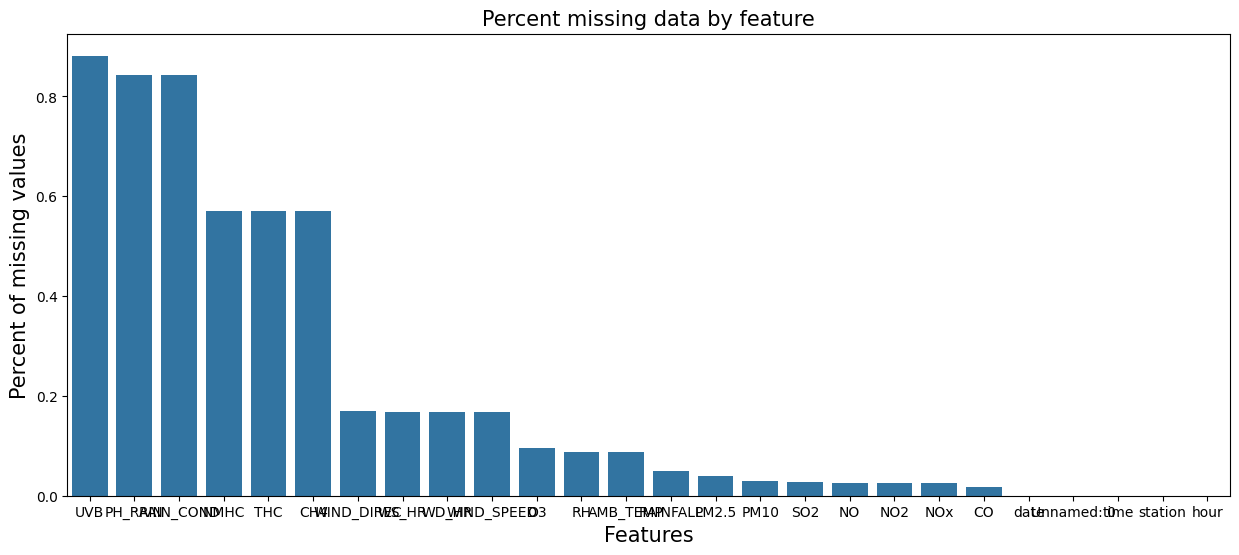

In [52]:
print(missing_rate(dataset))
display_missing_percent(dataset)

## Gom cụm theo từng khu vực

In [47]:
print(get_stat_by_station(dataset))

+-----+-----------+----------+-------------------------------+-------------------------------+
| No. |  station  | #Records |           From date           |            To date            |
+-----+-----------+----------+-------------------------------+-------------------------------+
|  1  |  Banqiao  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Cailiao  |  8,736   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Datong  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Dayuan  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Guanyin  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Guting  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Keelung  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Linkou  |  8,688   | 2015-01-01T00:00:00

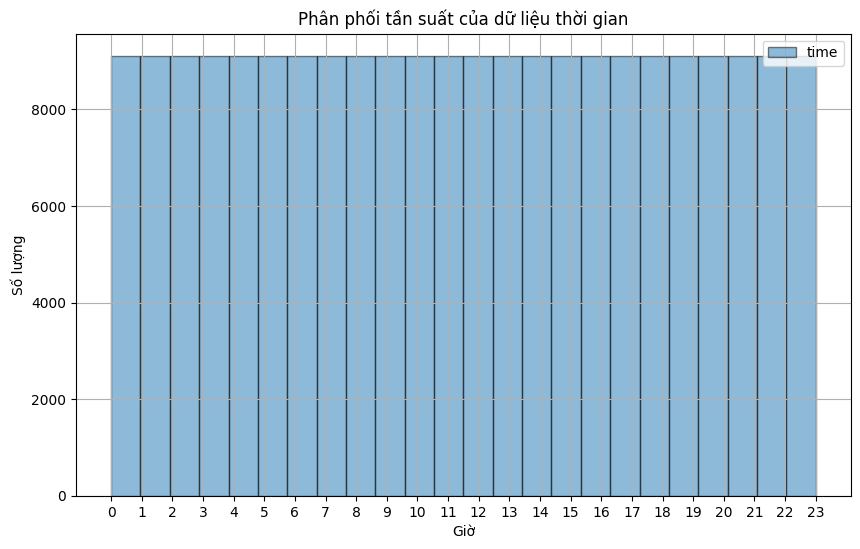

In [48]:
datasets=[(dataset,'time')]
timeGraph(datasets)

## Tính time step

In [49]:
find_time_steps(dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Banqiao has no missing hours.
Station Cailiao is missing the following hours:
Date 2015-03-05 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Station Datong has no missing hours.
Station Dayuan has no missing hours.
Station Guanyin has no missing hours.
Station Guting has no missing hours.
Station Keelung has no missing hours.
Station Linkou is missing the following hours:
Date 2015-01-10 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Date 2015-05-16 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Date 2015-05-17 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Station Longtan is missing the following hours:
Date 2015-09-08 is missing hours: [0, 1, 2, 3,

## Dataset sau khi đã thực hiện tiền xử lý

In [50]:
pre_dataset=preprocess_taiwan2015(dataset)
print(pre_dataset)

Columns: Index(['Unnamed: 0', 'time', 'station', 'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RH', 'SO2', 'THC', 'UVB', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR',
       'date', 'hour'],
      dtype='object')
X shape:  (219000, 26)
          station        date                time  Unnamed: 0  AMB_TEMP  CH4  \
0         Banqiao  2015-01-01 2015-01-01 00:00:00         0.0      16.0  2.1   
1         Banqiao  2015-01-01 2015-01-01 01:00:00         1.0      16.0  2.1   
2         Banqiao  2015-01-01 2015-01-01 02:00:00         2.0      16.0  2.1   
3         Banqiao  2015-01-01 2015-01-01 03:00:00         3.0      15.0  2.0   
4         Banqiao  2015-01-01 2015-01-01 04:00:00         4.0      15.0  2.0   
...           ...         ...                 ...         ...       ...  ...   
218995  Zhongshan  2015-12-31 2015-12-31 19:00:00    218635.0      18.0  1.9   
218996  Zhongshan  2015-12-31 2015-12-31 20

21.94


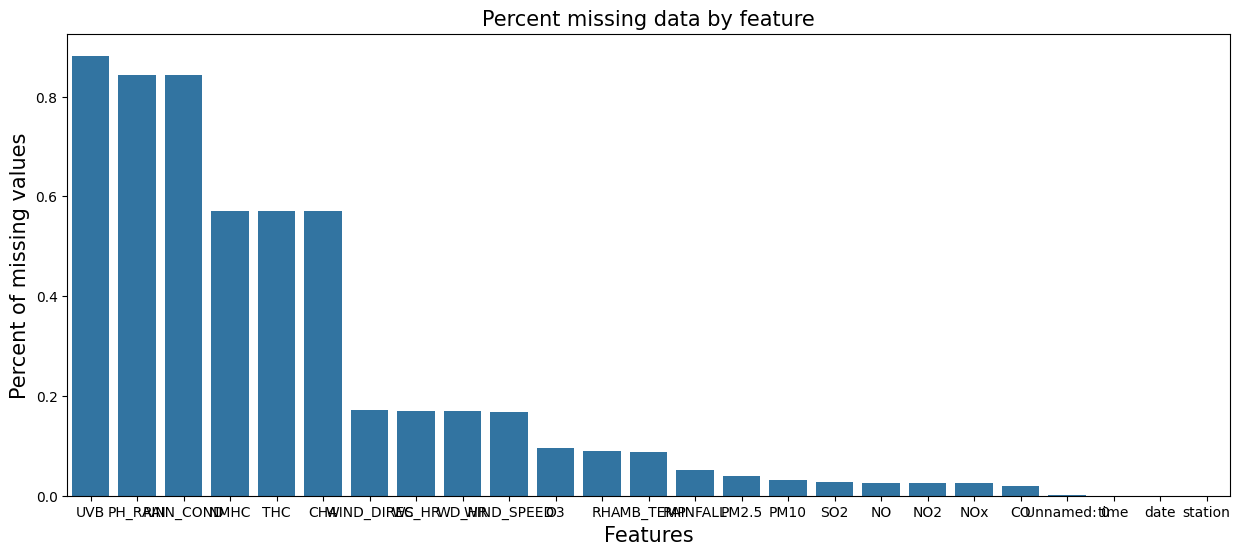

In [54]:
print(missing_rate(pre_dataset))
display_missing_percent(pre_dataset)

In [33]:
find_time_steps(pre_dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Banqiao has no missing hours.
Station Cailiao has no missing hours.
Station Datong has no missing hours.
Station Dayuan has no missing hours.
Station Guanyin has no missing hours.
Station Guting has no missing hours.
Station Keelung has no missing hours.
Station Linkou has no missing hours.
Station Longtan has no missing hours.
Station Pingzhen has no missing hours.
Station Sanchong has no missing hours.
Station Shilin has no missing hours.
Station Songshan has no missing hours.
Station Tamsui has no missing hours.
Station Taoyuan has no missing hours.
Station Tucheng has no missing hours.
Station Wanhua has no missing hours.
Station Wanli has no missing hours.
Station Xindian has no missing hours.
Station Xinzhuang has no missing hours.
Station Xizhi has no missing hours.
Station Yangming has no missing hours.
Station Yonghe has no missing hours.
Station Zhongli has no missing

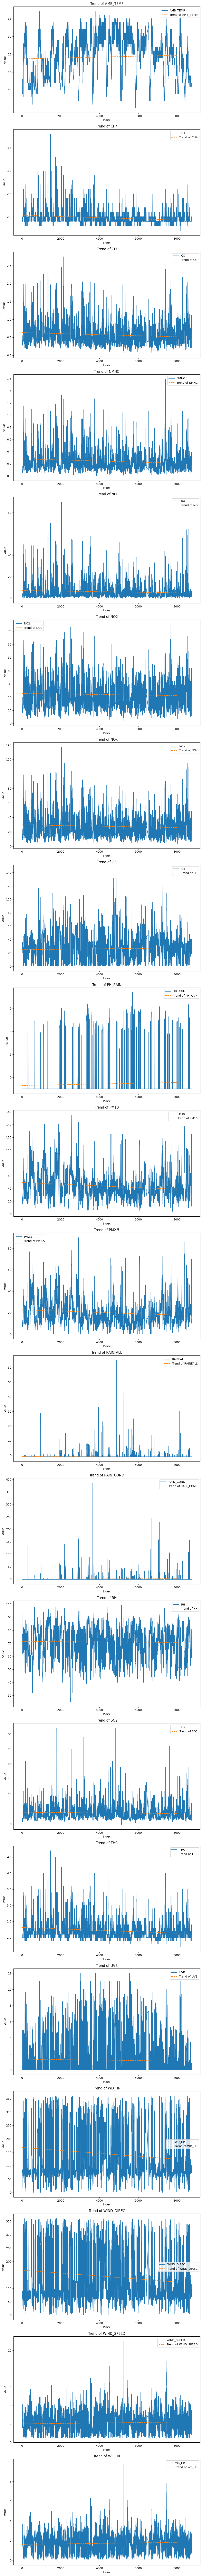

None


In [55]:
trend=calculate_trend(pre_dataset)
print(trend)

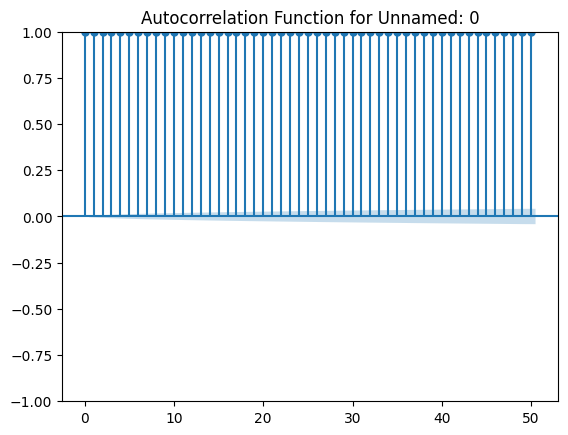

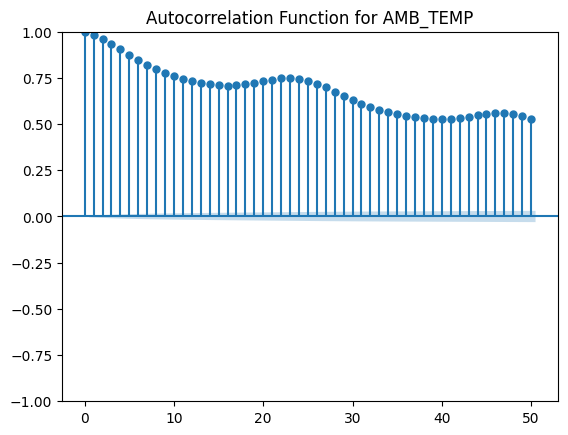

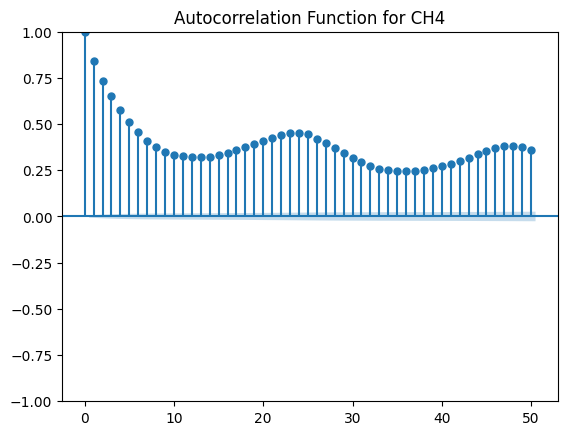

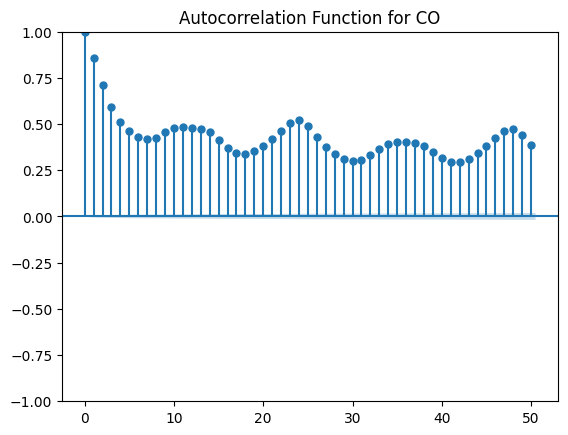

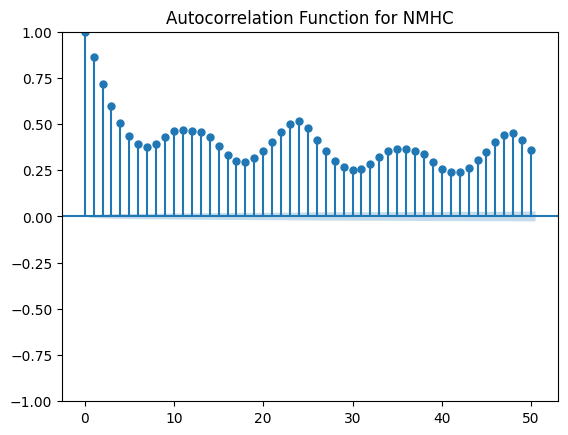

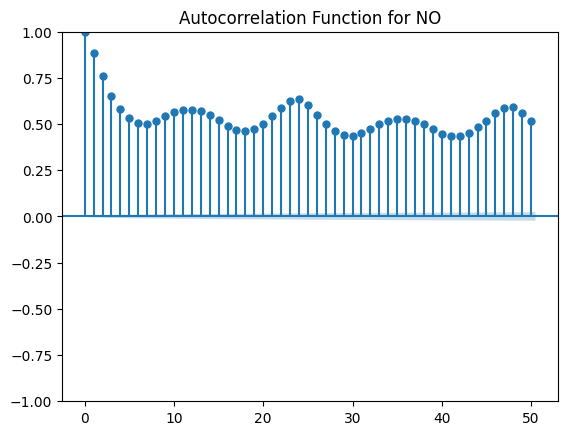

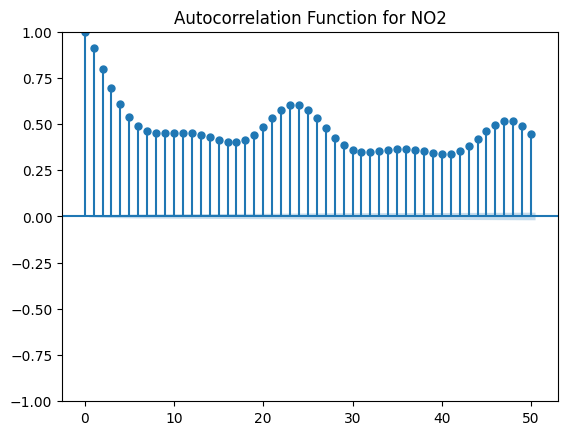

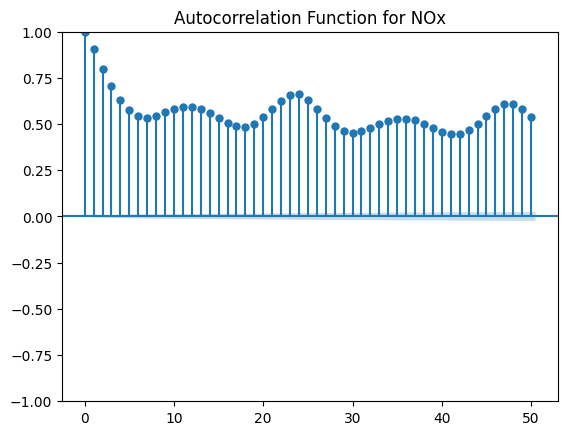

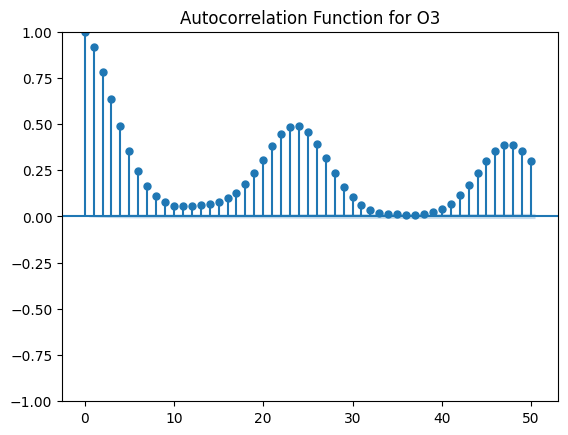

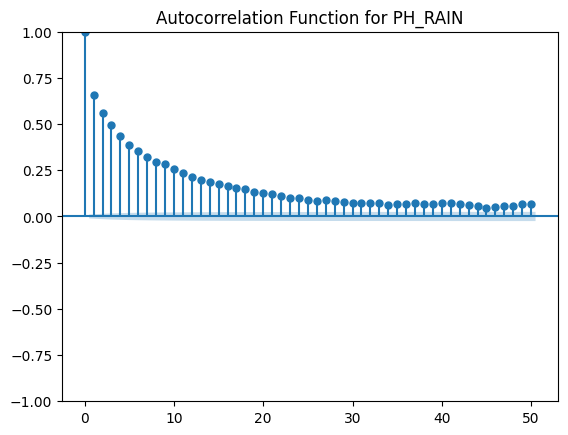

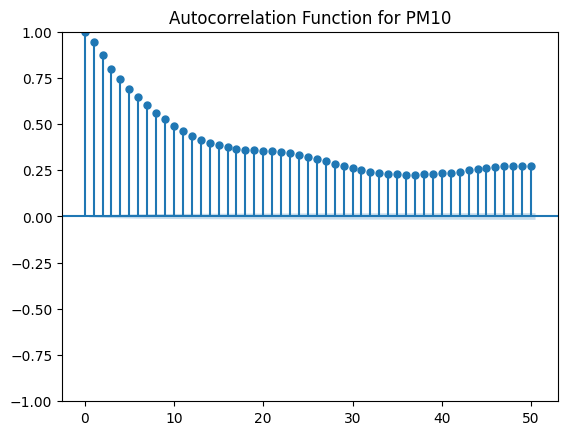

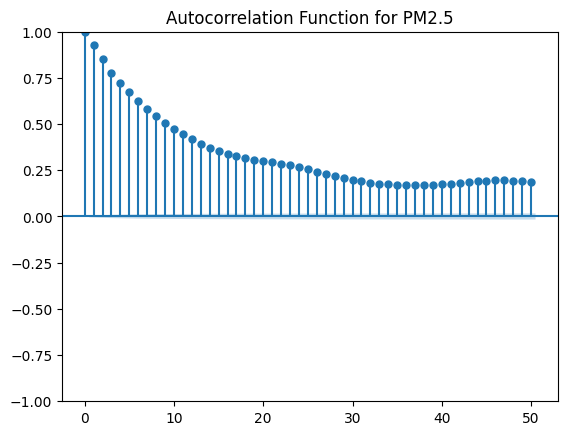

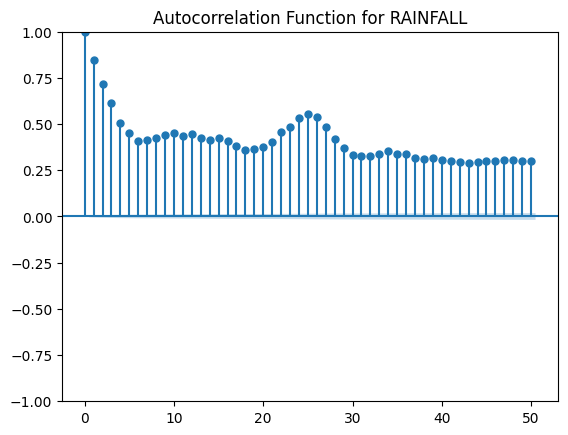

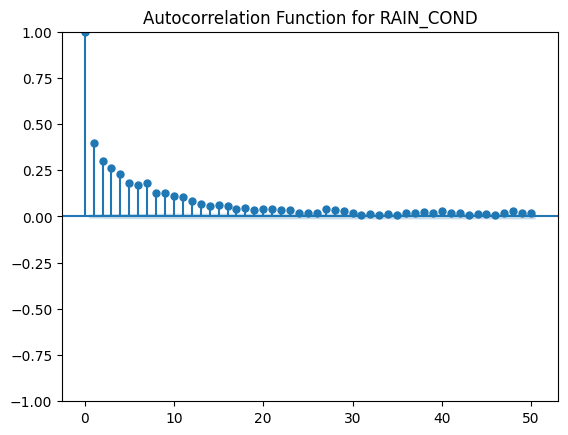

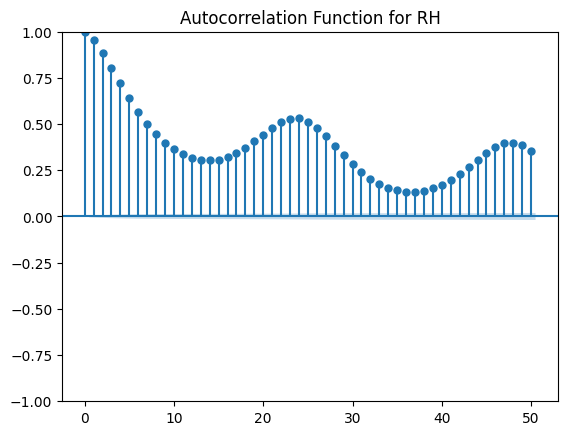

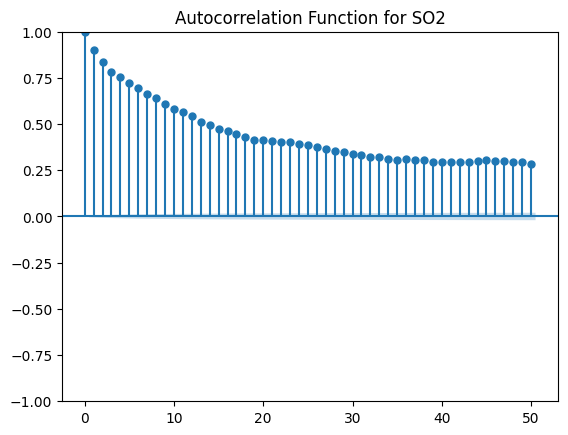

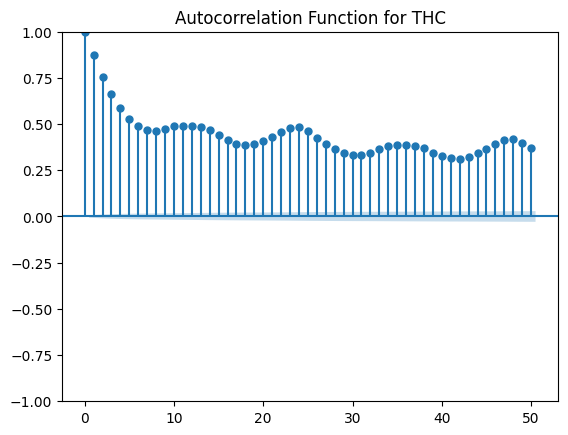

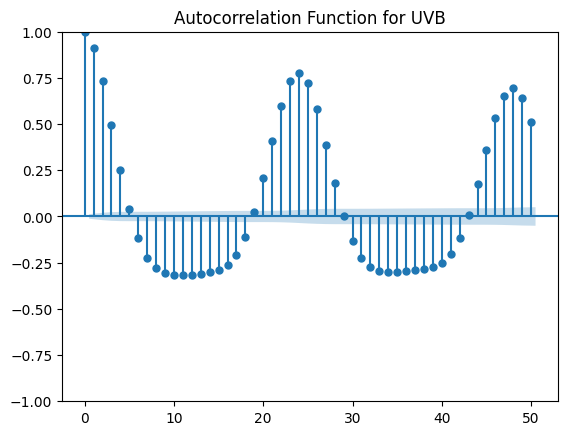

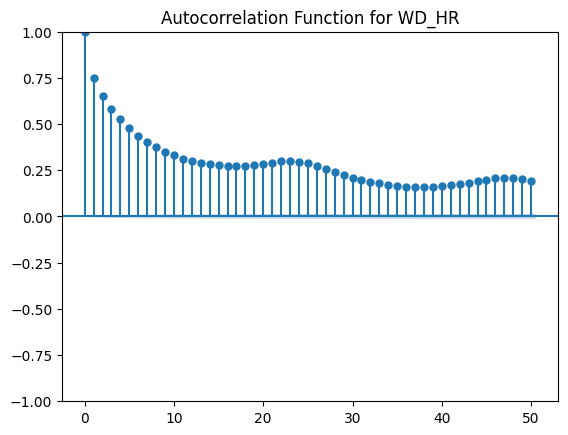

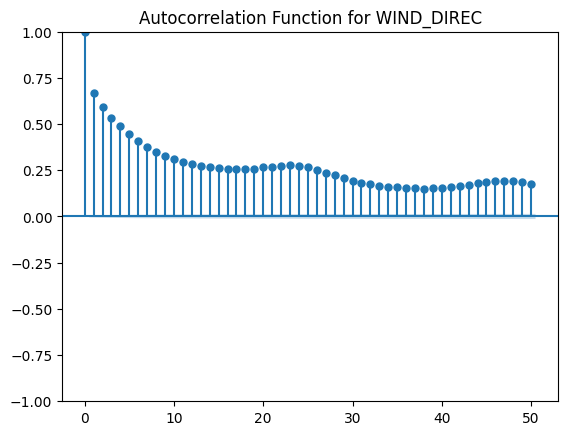

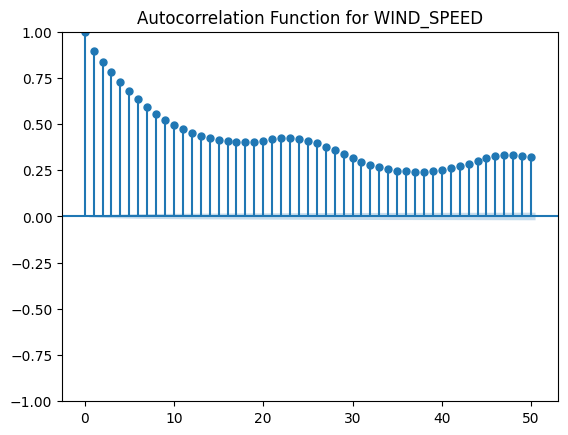

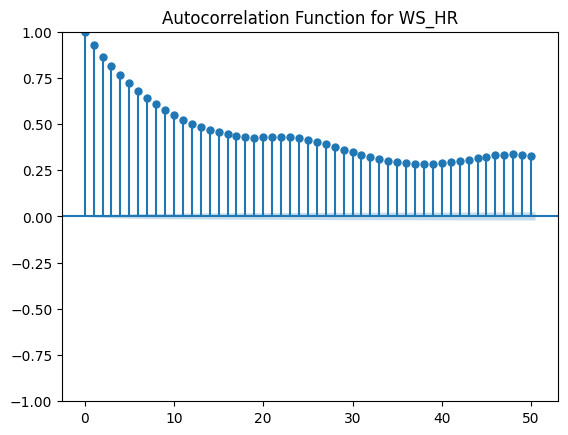

{'Unnamed: 0': 1,
 'AMB_TEMP': 1,
 'CH4': 1,
 'CO': 1,
 'NMHC': 1,
 'NO': 1,
 'NO2': 1,
 'NOx': 1,
 'O3': 1,
 'PH_RAIN': 1,
 'PM10': 1,
 'PM2.5': 1,
 'RAINFALL': 1,
 'RAIN_COND': 1,
 'RH': 1,
 'SO2': 1,
 'THC': 1,
 'UVB': 1,
 'WD_HR': 1,
 'WIND_DIREC': 1,
 'WIND_SPEED': 1,
 'WS_HR': 1}

In [56]:
find_cycles_for_all_columns(pre_dataset)
# kết quả trả về cho thấy dữ liệu không có chu kỳ dài hạn rõ ràng trong phạm vi độ trễ được xem xét (ở đây là 50)

In [57]:
n_steps = 24
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
# missing_rates = [0.1, 0.2, 0.3,]
methods = ['median','mean','knn', 'mice','saits','mrnn' ]



In [60]:
df_mae, df_mse, df_rmse, df_running_time = run_experiment(dataset, missing_rates, methods)

Rate: 0.1 Method: median N: 0
Rate: 0.1 Method: median N: 1
Rate: 0.1 Method: median N: 2
Rate: 0.1 Method: median N: 3
Rate: 0.1 Method: median N: 4
Rate: 0.1 Method: median N: 5
Rate: 0.1 Method: median N: 6
Rate: 0.1 Method: median N: 7
Rate: 0.1 Method: median N: 8
Rate: 0.1 Method: median N: 9
Rate: 0.1 Method: mean N: 0
Rate: 0.1 Method: mean N: 1
Rate: 0.1 Method: mean N: 2
Rate: 0.1 Method: mean N: 3
Rate: 0.1 Method: mean N: 4
Rate: 0.1 Method: mean N: 5
Rate: 0.1 Method: mean N: 6
Rate: 0.1 Method: mean N: 7
Rate: 0.1 Method: mean N: 8
Rate: 0.1 Method: mean N: 9
Rate: 0.1 Method: knn N: 0
Rate: 0.1 Method: knn N: 1
Rate: 0.1 Method: knn N: 2
Rate: 0.1 Method: knn N: 3
Rate: 0.1 Method: knn N: 4
Rate: 0.1 Method: knn N: 5
Rate: 0.1 Method: knn N: 6
Rate: 0.1 Method: knn N: 7
Rate: 0.1 Method: knn N: 8
Rate: 0.1 Method: knn N: 9
Rate: 0.1 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 04:05:46 [INFO]: Using the given device: cpu
2024-05-31 04:05:46 [INFO]: Model files will be saved to data_2/saits/20240531_T040546
2024-05-31 04:05:46 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T040546/tensorboard


Rate: 0.1 Method: saits N: 0


2024-05-31 04:05:46 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894
2024-05-31 04:05:49 [INFO]: Epoch 001 - training loss: 1.4154, validation loss: 1.1313
2024-05-31 04:05:50 [INFO]: Epoch 002 - training loss: 1.1243, validation loss: 1.0163
2024-05-31 04:05:51 [INFO]: Epoch 003 - training loss: 1.0026, validation loss: 0.9519
2024-05-31 04:05:53 [INFO]: Epoch 004 - training loss: 0.9295, validation loss: 0.8865
2024-05-31 04:05:55 [INFO]: Epoch 005 - training loss: 0.8592, validation loss: 0.8492
2024-05-31 04:05:57 [INFO]: Epoch 006 - training loss: 0.7988, validation loss: 0.8140
2024-05-31 04:05:59 [INFO]: Epoch 007 - training loss: 0.7499, validation loss: 0.7874
2024-05-31 04:06:00 [INFO]: Epoch 008 - training loss: 0.7124, validation loss: 0.7569
2024-05-31 04:06:01 [INFO]: Epoch 009 - training loss: 0.6671, validation loss: 0.7481
2024-05-31 04:06:02 [INFO]: Epoch 010 - training loss: 0.6464, validation loss: 0.7302
2024-0

Rate: 0.1 Method: saits N: 1


2024-05-31 04:06:26 [INFO]: Epoch 001 - training loss: 1.4028, validation loss: 0.6309
2024-05-31 04:06:28 [INFO]: Epoch 002 - training loss: 1.1183, validation loss: 0.5456
2024-05-31 04:06:30 [INFO]: Epoch 003 - training loss: 0.9911, validation loss: 0.4533
2024-05-31 04:06:31 [INFO]: Epoch 004 - training loss: 0.9109, validation loss: 0.3944
2024-05-31 04:06:32 [INFO]: Epoch 005 - training loss: 0.8422, validation loss: 0.3537
2024-05-31 04:06:34 [INFO]: Epoch 006 - training loss: 0.7807, validation loss: 0.3233
2024-05-31 04:06:35 [INFO]: Epoch 007 - training loss: 0.7420, validation loss: 0.2950
2024-05-31 04:06:36 [INFO]: Epoch 008 - training loss: 0.7002, validation loss: 0.2765
2024-05-31 04:06:37 [INFO]: Epoch 009 - training loss: 0.6694, validation loss: 0.2580
2024-05-31 04:06:39 [INFO]: Epoch 010 - training loss: 0.6394, validation loss: 0.2440
2024-05-31 04:06:40 [INFO]: Epoch 011 - training loss: 0.6221, validation loss: 0.2396
2024-05-31 04:06:42 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 2


2024-05-31 04:07:03 [INFO]: Epoch 001 - training loss: 1.3934, validation loss: 1.1243
2024-05-31 04:07:05 [INFO]: Epoch 002 - training loss: 1.1131, validation loss: 0.9595
2024-05-31 04:07:06 [INFO]: Epoch 003 - training loss: 0.9694, validation loss: 0.9087
2024-05-31 04:07:07 [INFO]: Epoch 004 - training loss: 0.8850, validation loss: 0.8599
2024-05-31 04:07:08 [INFO]: Epoch 005 - training loss: 0.8352, validation loss: 0.8155
2024-05-31 04:07:10 [INFO]: Epoch 006 - training loss: 0.7813, validation loss: 0.7889
2024-05-31 04:07:11 [INFO]: Epoch 007 - training loss: 0.7480, validation loss: 0.7605
2024-05-31 04:07:13 [INFO]: Epoch 008 - training loss: 0.7046, validation loss: 0.7452
2024-05-31 04:07:15 [INFO]: Epoch 009 - training loss: 0.6781, validation loss: 0.7286
2024-05-31 04:07:17 [INFO]: Epoch 010 - training loss: 0.6600, validation loss: 0.7150
2024-05-31 04:07:18 [INFO]: Epoch 011 - training loss: 0.6405, validation loss: 0.7016
2024-05-31 04:07:19 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 3


2024-05-31 04:07:39 [INFO]: Epoch 001 - training loss: 1.4018, validation loss: 0.6054
2024-05-31 04:07:41 [INFO]: Epoch 002 - training loss: 1.1175, validation loss: 0.5003
2024-05-31 04:07:42 [INFO]: Epoch 003 - training loss: 0.9995, validation loss: 0.4440
2024-05-31 04:07:44 [INFO]: Epoch 004 - training loss: 0.9252, validation loss: 0.3726
2024-05-31 04:07:46 [INFO]: Epoch 005 - training loss: 0.8637, validation loss: 0.3381
2024-05-31 04:07:48 [INFO]: Epoch 006 - training loss: 0.8135, validation loss: 0.3160
2024-05-31 04:07:49 [INFO]: Epoch 007 - training loss: 0.7644, validation loss: 0.2895
2024-05-31 04:07:50 [INFO]: Epoch 008 - training loss: 0.7329, validation loss: 0.2745
2024-05-31 04:07:52 [INFO]: Epoch 009 - training loss: 0.7044, validation loss: 0.2594
2024-05-31 04:07:53 [INFO]: Epoch 010 - training loss: 0.6754, validation loss: 0.2506
2024-05-31 04:07:54 [INFO]: Epoch 011 - training loss: 0.6500, validation loss: 0.2389
2024-05-31 04:07:55 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 4


2024-05-31 04:08:17 [INFO]: Epoch 001 - training loss: 1.4019, validation loss: 0.5661
2024-05-31 04:08:19 [INFO]: Epoch 002 - training loss: 1.1158, validation loss: 0.4449
2024-05-31 04:08:20 [INFO]: Epoch 003 - training loss: 0.9769, validation loss: 0.3805
2024-05-31 04:08:21 [INFO]: Epoch 004 - training loss: 0.8953, validation loss: 0.3268
2024-05-31 04:08:23 [INFO]: Epoch 005 - training loss: 0.8227, validation loss: 0.2778
2024-05-31 04:08:24 [INFO]: Epoch 006 - training loss: 0.7700, validation loss: 0.2472
2024-05-31 04:08:25 [INFO]: Epoch 007 - training loss: 0.7283, validation loss: 0.2360
2024-05-31 04:08:27 [INFO]: Epoch 008 - training loss: 0.7009, validation loss: 0.2118
2024-05-31 04:08:28 [INFO]: Epoch 009 - training loss: 0.6650, validation loss: 0.2026
2024-05-31 04:08:30 [INFO]: Epoch 010 - training loss: 0.6363, validation loss: 0.1911
2024-05-31 04:08:32 [INFO]: Epoch 011 - training loss: 0.6158, validation loss: 0.1857
2024-05-31 04:08:34 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 5


2024-05-31 04:08:57 [INFO]: Epoch 001 - training loss: 1.3881, validation loss: 0.7678
2024-05-31 04:08:58 [INFO]: Epoch 002 - training loss: 1.1108, validation loss: 0.6347
2024-05-31 04:09:00 [INFO]: Epoch 003 - training loss: 0.9841, validation loss: 0.5795
2024-05-31 04:09:01 [INFO]: Epoch 004 - training loss: 0.8988, validation loss: 0.5125
2024-05-31 04:09:02 [INFO]: Epoch 005 - training loss: 0.8508, validation loss: 0.4750
2024-05-31 04:09:04 [INFO]: Epoch 006 - training loss: 0.7957, validation loss: 0.4337
2024-05-31 04:09:06 [INFO]: Epoch 007 - training loss: 0.7499, validation loss: 0.4098
2024-05-31 04:09:08 [INFO]: Epoch 008 - training loss: 0.7144, validation loss: 0.3891
2024-05-31 04:09:10 [INFO]: Epoch 009 - training loss: 0.6873, validation loss: 0.3752
2024-05-31 04:09:11 [INFO]: Epoch 010 - training loss: 0.6710, validation loss: 0.3657
2024-05-31 04:09:12 [INFO]: Epoch 011 - training loss: 0.6447, validation loss: 0.3469
2024-05-31 04:09:14 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 6


2024-05-31 04:09:34 [INFO]: Epoch 001 - training loss: 1.3552, validation loss: 0.5778
2024-05-31 04:09:36 [INFO]: Epoch 002 - training loss: 1.0825, validation loss: 0.4647
2024-05-31 04:09:38 [INFO]: Epoch 003 - training loss: 0.9676, validation loss: 0.3990
2024-05-31 04:09:40 [INFO]: Epoch 004 - training loss: 0.8908, validation loss: 0.3483
2024-05-31 04:09:41 [INFO]: Epoch 005 - training loss: 0.8391, validation loss: 0.3001
2024-05-31 04:09:43 [INFO]: Epoch 006 - training loss: 0.7847, validation loss: 0.2789
2024-05-31 04:09:44 [INFO]: Epoch 007 - training loss: 0.7541, validation loss: 0.2629
2024-05-31 04:09:45 [INFO]: Epoch 008 - training loss: 0.7242, validation loss: 0.2480
2024-05-31 04:09:47 [INFO]: Epoch 009 - training loss: 0.6927, validation loss: 0.2334
2024-05-31 04:09:48 [INFO]: Epoch 010 - training loss: 0.6743, validation loss: 0.2269
2024-05-31 04:09:49 [INFO]: Epoch 011 - training loss: 0.6544, validation loss: 0.2165
2024-05-31 04:09:51 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 7


2024-05-31 04:10:14 [INFO]: Epoch 001 - training loss: 1.3908, validation loss: 0.7353
2024-05-31 04:10:15 [INFO]: Epoch 002 - training loss: 1.1247, validation loss: 0.6151
2024-05-31 04:10:17 [INFO]: Epoch 003 - training loss: 1.0003, validation loss: 0.5333
2024-05-31 04:10:18 [INFO]: Epoch 004 - training loss: 0.9286, validation loss: 0.4651
2024-05-31 04:10:19 [INFO]: Epoch 005 - training loss: 0.8647, validation loss: 0.4165
2024-05-31 04:10:21 [INFO]: Epoch 006 - training loss: 0.8149, validation loss: 0.4031
2024-05-31 04:10:23 [INFO]: Epoch 007 - training loss: 0.7825, validation loss: 0.3735
2024-05-31 04:10:25 [INFO]: Epoch 008 - training loss: 0.7419, validation loss: 0.3669
2024-05-31 04:10:27 [INFO]: Epoch 009 - training loss: 0.7209, validation loss: 0.3460
2024-05-31 04:10:28 [INFO]: Epoch 010 - training loss: 0.6928, validation loss: 0.3293
2024-05-31 04:10:29 [INFO]: Epoch 011 - training loss: 0.6627, validation loss: 0.3204
2024-05-31 04:10:30 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 8


2024-05-31 04:10:51 [INFO]: Epoch 001 - training loss: 1.3730, validation loss: 0.7056
2024-05-31 04:10:52 [INFO]: Epoch 002 - training loss: 1.1043, validation loss: 0.5918
2024-05-31 04:10:54 [INFO]: Epoch 003 - training loss: 0.9756, validation loss: 0.5111
2024-05-31 04:10:56 [INFO]: Epoch 004 - training loss: 0.9051, validation loss: 0.4627
2024-05-31 04:10:58 [INFO]: Epoch 005 - training loss: 0.8444, validation loss: 0.4388
2024-05-31 04:11:00 [INFO]: Epoch 006 - training loss: 0.8089, validation loss: 0.3977
2024-05-31 04:11:01 [INFO]: Epoch 007 - training loss: 0.7650, validation loss: 0.3754
2024-05-31 04:11:02 [INFO]: Epoch 008 - training loss: 0.7325, validation loss: 0.3692
2024-05-31 04:11:04 [INFO]: Epoch 009 - training loss: 0.7033, validation loss: 0.3541
2024-05-31 04:11:05 [INFO]: Epoch 010 - training loss: 0.6822, validation loss: 0.3463
2024-05-31 04:11:06 [INFO]: Epoch 011 - training loss: 0.6595, validation loss: 0.3337
2024-05-31 04:11:08 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 9


2024-05-31 04:11:30 [INFO]: Epoch 001 - training loss: 1.3728, validation loss: 0.7443
2024-05-31 04:11:31 [INFO]: Epoch 002 - training loss: 1.1146, validation loss: 0.5985
2024-05-31 04:11:33 [INFO]: Epoch 003 - training loss: 0.9903, validation loss: 0.5413
2024-05-31 04:11:34 [INFO]: Epoch 004 - training loss: 0.8960, validation loss: 0.4783
2024-05-31 04:11:35 [INFO]: Epoch 005 - training loss: 0.8304, validation loss: 0.4410
2024-05-31 04:11:36 [INFO]: Epoch 006 - training loss: 0.7775, validation loss: 0.4014
2024-05-31 04:11:38 [INFO]: Epoch 007 - training loss: 0.7380, validation loss: 0.3800
2024-05-31 04:11:39 [INFO]: Epoch 008 - training loss: 0.7077, validation loss: 0.3544
2024-05-31 04:11:41 [INFO]: Epoch 009 - training loss: 0.6758, validation loss: 0.3541
2024-05-31 04:11:43 [INFO]: Epoch 010 - training loss: 0.6459, validation loss: 0.3241
2024-05-31 04:11:45 [INFO]: Epoch 011 - training loss: 0.6186, validation loss: 0.3109
2024-05-31 04:11:46 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 0


2024-05-31 04:12:17 [INFO]: Epoch 001 - training loss: 2.0939, validation loss: 1.1634
2024-05-31 04:12:23 [INFO]: Epoch 002 - training loss: 1.9937, validation loss: 1.1462
2024-05-31 04:12:27 [INFO]: Epoch 003 - training loss: 1.8957, validation loss: 1.1295
2024-05-31 04:12:32 [INFO]: Epoch 004 - training loss: 1.7497, validation loss: 1.1133
2024-05-31 04:12:37 [INFO]: Epoch 005 - training loss: 1.6549, validation loss: 1.0972
2024-05-31 04:12:42 [INFO]: Epoch 006 - training loss: 1.5978, validation loss: 1.0817
2024-05-31 04:12:46 [INFO]: Epoch 007 - training loss: 1.5181, validation loss: 1.0666
2024-05-31 04:12:52 [INFO]: Epoch 008 - training loss: 1.4518, validation loss: 1.0522
2024-05-31 04:12:56 [INFO]: Epoch 009 - training loss: 1.4249, validation loss: 1.0379
2024-05-31 04:13:01 [INFO]: Epoch 010 - training loss: 1.3857, validation loss: 1.0242
2024-05-31 04:13:07 [INFO]: Epoch 011 - training loss: 1.3409, validation loss: 1.0112
2024-05-31 04:13:11 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 1


2024-05-31 04:14:19 [INFO]: Epoch 001 - training loss: 2.0665, validation loss: 1.1271
2024-05-31 04:14:26 [INFO]: Epoch 002 - training loss: 1.9513, validation loss: 1.1097
2024-05-31 04:14:30 [INFO]: Epoch 003 - training loss: 1.8333, validation loss: 1.0926
2024-05-31 04:14:34 [INFO]: Epoch 004 - training loss: 1.6973, validation loss: 1.0761
2024-05-31 04:14:40 [INFO]: Epoch 005 - training loss: 1.6084, validation loss: 1.0599
2024-05-31 04:14:45 [INFO]: Epoch 006 - training loss: 1.5675, validation loss: 1.0450
2024-05-31 04:14:49 [INFO]: Epoch 007 - training loss: 1.4996, validation loss: 1.0309
2024-05-31 04:14:54 [INFO]: Epoch 008 - training loss: 1.4463, validation loss: 1.0166
2024-05-31 04:14:59 [INFO]: Epoch 009 - training loss: 1.3955, validation loss: 1.0026
2024-05-31 04:15:04 [INFO]: Epoch 010 - training loss: 1.3589, validation loss: 0.9888
2024-05-31 04:15:09 [INFO]: Epoch 011 - training loss: 1.3272, validation loss: 0.9756
2024-05-31 04:15:14 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 2


2024-05-31 04:16:27 [INFO]: Epoch 001 - training loss: 2.1327, validation loss: 1.2087
2024-05-31 04:16:33 [INFO]: Epoch 002 - training loss: 1.9924, validation loss: 1.1910
2024-05-31 04:16:38 [INFO]: Epoch 003 - training loss: 1.8639, validation loss: 1.1737
2024-05-31 04:16:42 [INFO]: Epoch 004 - training loss: 1.7264, validation loss: 1.1566
2024-05-31 04:16:49 [INFO]: Epoch 005 - training loss: 1.6231, validation loss: 1.1399
2024-05-31 04:16:53 [INFO]: Epoch 006 - training loss: 1.5928, validation loss: 1.1242
2024-05-31 04:16:58 [INFO]: Epoch 007 - training loss: 1.4839, validation loss: 1.1087
2024-05-31 04:17:04 [INFO]: Epoch 008 - training loss: 1.4418, validation loss: 1.0935
2024-05-31 04:17:09 [INFO]: Epoch 009 - training loss: 1.3956, validation loss: 1.0784
2024-05-31 04:17:13 [INFO]: Epoch 010 - training loss: 1.3562, validation loss: 1.0638
2024-05-31 04:17:19 [INFO]: Epoch 011 - training loss: 1.3314, validation loss: 1.0498
2024-05-31 04:17:24 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 3


2024-05-31 04:18:34 [INFO]: Epoch 001 - training loss: 2.0484, validation loss: 1.1833
2024-05-31 04:18:43 [INFO]: Epoch 002 - training loss: 1.9476, validation loss: 1.1652
2024-05-31 04:18:48 [INFO]: Epoch 003 - training loss: 1.8051, validation loss: 1.1479
2024-05-31 04:18:55 [INFO]: Epoch 004 - training loss: 1.6823, validation loss: 1.1305
2024-05-31 04:19:01 [INFO]: Epoch 005 - training loss: 1.6347, validation loss: 1.1137
2024-05-31 04:19:06 [INFO]: Epoch 006 - training loss: 1.5392, validation loss: 1.0979
2024-05-31 04:19:12 [INFO]: Epoch 007 - training loss: 1.4855, validation loss: 1.0827
2024-05-31 04:19:17 [INFO]: Epoch 008 - training loss: 1.4532, validation loss: 1.0678
2024-05-31 04:19:22 [INFO]: Epoch 009 - training loss: 1.3785, validation loss: 1.0535
2024-05-31 04:19:28 [INFO]: Epoch 010 - training loss: 1.3527, validation loss: 1.0402
2024-05-31 04:19:34 [INFO]: Epoch 011 - training loss: 1.3127, validation loss: 1.0278
2024-05-31 04:19:39 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 4


2024-05-31 04:21:01 [INFO]: Epoch 001 - training loss: 2.0769, validation loss: 1.1861
2024-05-31 04:21:07 [INFO]: Epoch 002 - training loss: 1.9735, validation loss: 1.1706
2024-05-31 04:21:12 [INFO]: Epoch 003 - training loss: 1.8292, validation loss: 1.1550
2024-05-31 04:21:17 [INFO]: Epoch 004 - training loss: 1.6725, validation loss: 1.1393
2024-05-31 04:21:24 [INFO]: Epoch 005 - training loss: 1.5926, validation loss: 1.1236
2024-05-31 04:21:29 [INFO]: Epoch 006 - training loss: 1.5616, validation loss: 1.1083
2024-05-31 04:21:35 [INFO]: Epoch 007 - training loss: 1.4851, validation loss: 1.0931
2024-05-31 04:21:42 [INFO]: Epoch 008 - training loss: 1.4198, validation loss: 1.0777
2024-05-31 04:21:47 [INFO]: Epoch 009 - training loss: 1.3798, validation loss: 1.0623
2024-05-31 04:21:52 [INFO]: Epoch 010 - training loss: 1.3518, validation loss: 1.0471
2024-05-31 04:22:00 [INFO]: Epoch 011 - training loss: 1.3363, validation loss: 1.0323
2024-05-31 04:22:06 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 5


2024-05-31 04:23:19 [INFO]: Epoch 001 - training loss: 2.0900, validation loss: 1.0641
2024-05-31 04:23:24 [INFO]: Epoch 002 - training loss: 1.9878, validation loss: 1.0481
2024-05-31 04:23:29 [INFO]: Epoch 003 - training loss: 1.8997, validation loss: 1.0326
2024-05-31 04:23:34 [INFO]: Epoch 004 - training loss: 1.7659, validation loss: 1.0172
2024-05-31 04:23:38 [INFO]: Epoch 005 - training loss: 1.6312, validation loss: 1.0020
2024-05-31 04:23:43 [INFO]: Epoch 006 - training loss: 1.5691, validation loss: 0.9874
2024-05-31 04:23:49 [INFO]: Epoch 007 - training loss: 1.5189, validation loss: 0.9730
2024-05-31 04:23:53 [INFO]: Epoch 008 - training loss: 1.4688, validation loss: 0.9586
2024-05-31 04:23:57 [INFO]: Epoch 009 - training loss: 1.3916, validation loss: 0.9440
2024-05-31 04:24:03 [INFO]: Epoch 010 - training loss: 1.3826, validation loss: 0.9294
2024-05-31 04:24:07 [INFO]: Epoch 011 - training loss: 1.3202, validation loss: 0.9151
2024-05-31 04:24:12 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 6


2024-05-31 04:25:32 [INFO]: Epoch 001 - training loss: 2.0560, validation loss: 1.2108
2024-05-31 04:25:37 [INFO]: Epoch 002 - training loss: 1.9369, validation loss: 1.1933
2024-05-31 04:25:44 [INFO]: Epoch 003 - training loss: 1.8106, validation loss: 1.1762
2024-05-31 04:25:49 [INFO]: Epoch 004 - training loss: 1.6749, validation loss: 1.1595
2024-05-31 04:25:53 [INFO]: Epoch 005 - training loss: 1.6000, validation loss: 1.1435
2024-05-31 04:26:00 [INFO]: Epoch 006 - training loss: 1.5081, validation loss: 1.1282
2024-05-31 04:26:05 [INFO]: Epoch 007 - training loss: 1.4454, validation loss: 1.1133
2024-05-31 04:26:10 [INFO]: Epoch 008 - training loss: 1.4147, validation loss: 1.0985
2024-05-31 04:26:17 [INFO]: Epoch 009 - training loss: 1.3832, validation loss: 1.0840
2024-05-31 04:26:22 [INFO]: Epoch 010 - training loss: 1.3525, validation loss: 1.0702
2024-05-31 04:26:27 [INFO]: Epoch 011 - training loss: 1.3016, validation loss: 1.0569
2024-05-31 04:26:34 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 7


2024-05-31 04:27:51 [INFO]: Epoch 001 - training loss: 2.0724, validation loss: 1.2025
2024-05-31 04:27:56 [INFO]: Epoch 002 - training loss: 1.9672, validation loss: 1.1849
2024-05-31 04:28:01 [INFO]: Epoch 003 - training loss: 1.8206, validation loss: 1.1678
2024-05-31 04:28:08 [INFO]: Epoch 004 - training loss: 1.7081, validation loss: 1.1511
2024-05-31 04:28:13 [INFO]: Epoch 005 - training loss: 1.6192, validation loss: 1.1351
2024-05-31 04:28:18 [INFO]: Epoch 006 - training loss: 1.5607, validation loss: 1.1201
2024-05-31 04:28:24 [INFO]: Epoch 007 - training loss: 1.4933, validation loss: 1.1052
2024-05-31 04:28:29 [INFO]: Epoch 008 - training loss: 1.4321, validation loss: 1.0904
2024-05-31 04:28:34 [INFO]: Epoch 009 - training loss: 1.3910, validation loss: 1.0755
2024-05-31 04:28:42 [INFO]: Epoch 010 - training loss: 1.3581, validation loss: 1.0610
2024-05-31 04:28:49 [INFO]: Epoch 011 - training loss: 1.3194, validation loss: 1.0470
2024-05-31 04:28:54 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 8


2024-05-31 04:30:09 [INFO]: Epoch 001 - training loss: 2.0703, validation loss: 1.2359
2024-05-31 04:30:15 [INFO]: Epoch 002 - training loss: 1.9188, validation loss: 1.2205
2024-05-31 04:30:21 [INFO]: Epoch 003 - training loss: 1.7930, validation loss: 1.2055
2024-05-31 04:30:26 [INFO]: Epoch 004 - training loss: 1.6560, validation loss: 1.1904
2024-05-31 04:30:31 [INFO]: Epoch 005 - training loss: 1.6193, validation loss: 1.1753
2024-05-31 04:30:36 [INFO]: Epoch 006 - training loss: 1.5138, validation loss: 1.1601
2024-05-31 04:30:41 [INFO]: Epoch 007 - training loss: 1.4756, validation loss: 1.1451
2024-05-31 04:30:46 [INFO]: Epoch 008 - training loss: 1.4127, validation loss: 1.1300
2024-05-31 04:30:52 [INFO]: Epoch 009 - training loss: 1.3700, validation loss: 1.1148
2024-05-31 04:30:56 [INFO]: Epoch 010 - training loss: 1.3236, validation loss: 1.0998
2024-05-31 04:31:01 [INFO]: Epoch 011 - training loss: 1.3000, validation loss: 1.0851
2024-05-31 04:31:07 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 9


2024-05-31 04:32:23 [INFO]: Epoch 001 - training loss: 2.0707, validation loss: 1.1570
2024-05-31 04:32:29 [INFO]: Epoch 002 - training loss: 1.9568, validation loss: 1.1407
2024-05-31 04:32:33 [INFO]: Epoch 003 - training loss: 1.7829, validation loss: 1.1245
2024-05-31 04:32:39 [INFO]: Epoch 004 - training loss: 1.6441, validation loss: 1.1088
2024-05-31 04:32:45 [INFO]: Epoch 005 - training loss: 1.5649, validation loss: 1.0932
2024-05-31 04:32:49 [INFO]: Epoch 006 - training loss: 1.5088, validation loss: 1.0784
2024-05-31 04:32:54 [INFO]: Epoch 007 - training loss: 1.4462, validation loss: 1.0641
2024-05-31 04:33:00 [INFO]: Epoch 008 - training loss: 1.3920, validation loss: 1.0506
2024-05-31 04:33:04 [INFO]: Epoch 009 - training loss: 1.3615, validation loss: 1.0375
2024-05-31 04:33:08 [INFO]: Epoch 010 - training loss: 1.3211, validation loss: 1.0256
2024-05-31 04:33:14 [INFO]: Epoch 011 - training loss: 1.3064, validation loss: 1.0149
2024-05-31 04:33:18 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: median N: 0
Rate: 0.2 Method: median N: 1
Rate: 0.2 Method: median N: 2
Rate: 0.2 Method: median N: 3
Rate: 0.2 Method: median N: 4
Rate: 0.2 Method: median N: 5
Rate: 0.2 Method: median N: 6
Rate: 0.2 Method: median N: 7
Rate: 0.2 Method: median N: 8
Rate: 0.2 Method: median N: 9
Rate: 0.2 Method: mean N: 0
Rate: 0.2 Method: mean N: 1
Rate: 0.2 Method: mean N: 2
Rate: 0.2 Method: mean N: 3
Rate: 0.2 Method: mean N: 4
Rate: 0.2 Method: mean N: 5
Rate: 0.2 Method: mean N: 6
Rate: 0.2 Method: mean N: 7
Rate: 0.2 Method: mean N: 8
Rate: 0.2 Method: mean N: 9
Rate: 0.2 Method: knn N: 0
Rate: 0.2 Method: knn N: 1
Rate: 0.2 Method: knn N: 2
Rate: 0.2 Method: knn N: 3
Rate: 0.2 Method: knn N: 4
Rate: 0.2 Method: knn N: 5
Rate: 0.2 Method: knn N: 6
Rate: 0.2 Method: knn N: 7
Rate: 0.2 Method: knn N: 8
Rate: 0.2 Method: knn N: 9
Rate: 0.2 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 04:45:30 [INFO]: Using the given device: cpu
2024-05-31 04:45:30 [INFO]: Model files will be saved to data_2/saits/20240531_T044530
2024-05-31 04:45:30 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T044530/tensorboard
2024-05-31 04:45:30 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.2 Method: saits N: 0


2024-05-31 04:45:32 [INFO]: Epoch 001 - training loss: 1.4162, validation loss: 0.8026
2024-05-31 04:45:33 [INFO]: Epoch 002 - training loss: 1.1524, validation loss: 0.6847
2024-05-31 04:45:34 [INFO]: Epoch 003 - training loss: 1.0146, validation loss: 0.5952
2024-05-31 04:45:36 [INFO]: Epoch 004 - training loss: 0.9438, validation loss: 0.5723
2024-05-31 04:45:37 [INFO]: Epoch 005 - training loss: 0.8759, validation loss: 0.5177
2024-05-31 04:45:38 [INFO]: Epoch 006 - training loss: 0.8277, validation loss: 0.4693
2024-05-31 04:45:39 [INFO]: Epoch 007 - training loss: 0.7770, validation loss: 0.4450
2024-05-31 04:45:41 [INFO]: Epoch 008 - training loss: 0.7417, validation loss: 0.4150
2024-05-31 04:45:42 [INFO]: Epoch 009 - training loss: 0.7093, validation loss: 0.4097
2024-05-31 04:45:44 [INFO]: Epoch 010 - training loss: 0.6798, validation loss: 0.3838
2024-05-31 04:45:46 [INFO]: Epoch 011 - training loss: 0.6544, validation loss: 0.3672
2024-05-31 04:45:48 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 1


2024-05-31 04:46:10 [INFO]: Epoch 001 - training loss: 1.3646, validation loss: 0.7777
2024-05-31 04:46:11 [INFO]: Epoch 002 - training loss: 1.1093, validation loss: 0.6930
2024-05-31 04:46:12 [INFO]: Epoch 003 - training loss: 0.9814, validation loss: 0.5858
2024-05-31 04:46:14 [INFO]: Epoch 004 - training loss: 0.8991, validation loss: 0.5388
2024-05-31 04:46:15 [INFO]: Epoch 005 - training loss: 0.8424, validation loss: 0.4855
2024-05-31 04:46:17 [INFO]: Epoch 006 - training loss: 0.7951, validation loss: 0.4682
2024-05-31 04:46:19 [INFO]: Epoch 007 - training loss: 0.7521, validation loss: 0.4396
2024-05-31 04:46:21 [INFO]: Epoch 008 - training loss: 0.7170, validation loss: 0.4279
2024-05-31 04:46:22 [INFO]: Epoch 009 - training loss: 0.6873, validation loss: 0.4084
2024-05-31 04:46:23 [INFO]: Epoch 010 - training loss: 0.6629, validation loss: 0.3985
2024-05-31 04:46:25 [INFO]: Epoch 011 - training loss: 0.6408, validation loss: 0.3933
2024-05-31 04:46:26 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 2


2024-05-31 04:46:46 [INFO]: Epoch 001 - training loss: 1.3635, validation loss: 0.6292
2024-05-31 04:46:48 [INFO]: Epoch 002 - training loss: 1.0855, validation loss: 0.5453
2024-05-31 04:46:50 [INFO]: Epoch 003 - training loss: 0.9668, validation loss: 0.4702
2024-05-31 04:46:52 [INFO]: Epoch 004 - training loss: 0.8833, validation loss: 0.4096
2024-05-31 04:46:53 [INFO]: Epoch 005 - training loss: 0.8152, validation loss: 0.3673
2024-05-31 04:46:54 [INFO]: Epoch 006 - training loss: 0.7569, validation loss: 0.3537
2024-05-31 04:46:55 [INFO]: Epoch 007 - training loss: 0.7165, validation loss: 0.3289
2024-05-31 04:46:57 [INFO]: Epoch 008 - training loss: 0.6895, validation loss: 0.3227
2024-05-31 04:46:58 [INFO]: Epoch 009 - training loss: 0.6581, validation loss: 0.3043
2024-05-31 04:46:59 [INFO]: Epoch 010 - training loss: 0.6393, validation loss: 0.2934
2024-05-31 04:47:00 [INFO]: Epoch 011 - training loss: 0.6150, validation loss: 0.2852
2024-05-31 04:47:02 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 3


2024-05-31 04:47:24 [INFO]: Epoch 001 - training loss: 1.3467, validation loss: 0.6399
2024-05-31 04:47:25 [INFO]: Epoch 002 - training loss: 1.0784, validation loss: 0.5206
2024-05-31 04:47:27 [INFO]: Epoch 003 - training loss: 0.9605, validation loss: 0.4789
2024-05-31 04:47:28 [INFO]: Epoch 004 - training loss: 0.8905, validation loss: 0.4045
2024-05-31 04:47:29 [INFO]: Epoch 005 - training loss: 0.8283, validation loss: 0.3530
2024-05-31 04:47:30 [INFO]: Epoch 006 - training loss: 0.7745, validation loss: 0.3257
2024-05-31 04:47:32 [INFO]: Epoch 007 - training loss: 0.7433, validation loss: 0.3030
2024-05-31 04:47:33 [INFO]: Epoch 008 - training loss: 0.7048, validation loss: 0.2783
2024-05-31 04:47:35 [INFO]: Epoch 009 - training loss: 0.6816, validation loss: 0.2611
2024-05-31 04:47:37 [INFO]: Epoch 010 - training loss: 0.6613, validation loss: 0.2567
2024-05-31 04:47:39 [INFO]: Epoch 011 - training loss: 0.6407, validation loss: 0.2425
2024-05-31 04:47:40 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 4


2024-05-31 04:48:00 [INFO]: Epoch 001 - training loss: 1.4205, validation loss: 0.6309
2024-05-31 04:48:02 [INFO]: Epoch 002 - training loss: 1.1490, validation loss: 0.5239
2024-05-31 04:48:03 [INFO]: Epoch 003 - training loss: 1.0130, validation loss: 0.4465
2024-05-31 04:48:05 [INFO]: Epoch 004 - training loss: 0.9221, validation loss: 0.4042
2024-05-31 04:48:07 [INFO]: Epoch 005 - training loss: 0.8610, validation loss: 0.3585
2024-05-31 04:48:09 [INFO]: Epoch 006 - training loss: 0.8087, validation loss: 0.3393
2024-05-31 04:48:10 [INFO]: Epoch 007 - training loss: 0.7649, validation loss: 0.2921
2024-05-31 04:48:12 [INFO]: Epoch 008 - training loss: 0.7289, validation loss: 0.2749
2024-05-31 04:48:13 [INFO]: Epoch 009 - training loss: 0.6951, validation loss: 0.2644
2024-05-31 04:48:14 [INFO]: Epoch 010 - training loss: 0.6676, validation loss: 0.2525
2024-05-31 04:48:16 [INFO]: Epoch 011 - training loss: 0.6400, validation loss: 0.2405
2024-05-31 04:48:17 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 5


2024-05-31 04:48:38 [INFO]: Epoch 001 - training loss: 1.3939, validation loss: 0.7224
2024-05-31 04:48:40 [INFO]: Epoch 002 - training loss: 1.1070, validation loss: 0.6477
2024-05-31 04:48:42 [INFO]: Epoch 003 - training loss: 0.9837, validation loss: 0.5734
2024-05-31 04:48:43 [INFO]: Epoch 004 - training loss: 0.9040, validation loss: 0.5285
2024-05-31 04:48:44 [INFO]: Epoch 005 - training loss: 0.8258, validation loss: 0.4663
2024-05-31 04:48:45 [INFO]: Epoch 006 - training loss: 0.7773, validation loss: 0.4442
2024-05-31 04:48:47 [INFO]: Epoch 007 - training loss: 0.7398, validation loss: 0.4218
2024-05-31 04:48:48 [INFO]: Epoch 008 - training loss: 0.7030, validation loss: 0.3940
2024-05-31 04:48:49 [INFO]: Epoch 009 - training loss: 0.6685, validation loss: 0.3899
2024-05-31 04:48:50 [INFO]: Epoch 010 - training loss: 0.6440, validation loss: 0.3719
2024-05-31 04:48:52 [INFO]: Epoch 011 - training loss: 0.6221, validation loss: 0.3639
2024-05-31 04:48:54 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 6


2024-05-31 04:49:16 [INFO]: Epoch 001 - training loss: 1.3706, validation loss: 0.9928
2024-05-31 04:49:18 [INFO]: Epoch 002 - training loss: 1.0851, validation loss: 0.8331
2024-05-31 04:49:19 [INFO]: Epoch 003 - training loss: 0.9731, validation loss: 0.7788
2024-05-31 04:49:21 [INFO]: Epoch 004 - training loss: 0.8939, validation loss: 0.7038
2024-05-31 04:49:22 [INFO]: Epoch 005 - training loss: 0.8345, validation loss: 0.6711
2024-05-31 04:49:23 [INFO]: Epoch 006 - training loss: 0.7851, validation loss: 0.6595
2024-05-31 04:49:25 [INFO]: Epoch 007 - training loss: 0.7448, validation loss: 0.6122
2024-05-31 04:49:27 [INFO]: Epoch 008 - training loss: 0.7088, validation loss: 0.6008
2024-05-31 04:49:29 [INFO]: Epoch 009 - training loss: 0.6792, validation loss: 0.5831
2024-05-31 04:49:30 [INFO]: Epoch 010 - training loss: 0.6471, validation loss: 0.5740
2024-05-31 04:49:32 [INFO]: Epoch 011 - training loss: 0.6256, validation loss: 0.5651
2024-05-31 04:49:33 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 7


2024-05-31 04:49:53 [INFO]: Epoch 001 - training loss: 1.3800, validation loss: 1.0666
2024-05-31 04:49:54 [INFO]: Epoch 002 - training loss: 1.0841, validation loss: 0.9155
2024-05-31 04:49:56 [INFO]: Epoch 003 - training loss: 0.9595, validation loss: 0.8469
2024-05-31 04:49:58 [INFO]: Epoch 004 - training loss: 0.8705, validation loss: 0.7723
2024-05-31 04:50:00 [INFO]: Epoch 005 - training loss: 0.8078, validation loss: 0.7257
2024-05-31 04:50:01 [INFO]: Epoch 006 - training loss: 0.7590, validation loss: 0.7020
2024-05-31 04:50:03 [INFO]: Epoch 007 - training loss: 0.7180, validation loss: 0.6838
2024-05-31 04:50:04 [INFO]: Epoch 008 - training loss: 0.6759, validation loss: 0.6765
2024-05-31 04:50:05 [INFO]: Epoch 009 - training loss: 0.6533, validation loss: 0.6553
2024-05-31 04:50:06 [INFO]: Epoch 010 - training loss: 0.6223, validation loss: 0.6490
2024-05-31 04:50:08 [INFO]: Epoch 011 - training loss: 0.6042, validation loss: 0.6315
2024-05-31 04:50:09 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 8


2024-05-31 04:50:30 [INFO]: Epoch 001 - training loss: 1.3660, validation loss: 0.6561
2024-05-31 04:50:32 [INFO]: Epoch 002 - training loss: 1.0971, validation loss: 0.5692
2024-05-31 04:50:33 [INFO]: Epoch 003 - training loss: 0.9727, validation loss: 0.5224
2024-05-31 04:50:34 [INFO]: Epoch 004 - training loss: 0.8950, validation loss: 0.4720
2024-05-31 04:50:35 [INFO]: Epoch 005 - training loss: 0.8500, validation loss: 0.4298
2024-05-31 04:50:37 [INFO]: Epoch 006 - training loss: 0.8003, validation loss: 0.4119
2024-05-31 04:50:38 [INFO]: Epoch 007 - training loss: 0.7623, validation loss: 0.3913
2024-05-31 04:50:39 [INFO]: Epoch 008 - training loss: 0.7273, validation loss: 0.3718
2024-05-31 04:50:41 [INFO]: Epoch 009 - training loss: 0.6938, validation loss: 0.3647
2024-05-31 04:50:42 [INFO]: Epoch 010 - training loss: 0.6777, validation loss: 0.3494
2024-05-31 04:50:44 [INFO]: Epoch 011 - training loss: 0.6575, validation loss: 0.3350
2024-05-31 04:50:46 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 9


2024-05-31 04:51:06 [INFO]: Epoch 001 - training loss: 1.3799, validation loss: 0.6817
2024-05-31 04:51:07 [INFO]: Epoch 002 - training loss: 1.1225, validation loss: 0.5877
2024-05-31 04:51:09 [INFO]: Epoch 003 - training loss: 1.0046, validation loss: 0.5227
2024-05-31 04:51:10 [INFO]: Epoch 004 - training loss: 0.9381, validation loss: 0.4712
2024-05-31 04:51:11 [INFO]: Epoch 005 - training loss: 0.8753, validation loss: 0.4193
2024-05-31 04:51:13 [INFO]: Epoch 006 - training loss: 0.8278, validation loss: 0.3965
2024-05-31 04:51:15 [INFO]: Epoch 007 - training loss: 0.7875, validation loss: 0.3664
2024-05-31 04:51:17 [INFO]: Epoch 008 - training loss: 0.7567, validation loss: 0.3479
2024-05-31 04:51:18 [INFO]: Epoch 009 - training loss: 0.7239, validation loss: 0.3275
2024-05-31 04:51:19 [INFO]: Epoch 010 - training loss: 0.6947, validation loss: 0.3152
2024-05-31 04:51:21 [INFO]: Epoch 011 - training loss: 0.6635, validation loss: 0.3067
2024-05-31 04:51:22 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 0


2024-05-31 04:51:46 [INFO]: Epoch 001 - training loss: 2.0762, validation loss: 1.0896
2024-05-31 04:51:52 [INFO]: Epoch 002 - training loss: 1.9346, validation loss: 1.0718
2024-05-31 04:51:56 [INFO]: Epoch 003 - training loss: 1.8016, validation loss: 1.0542
2024-05-31 04:52:00 [INFO]: Epoch 004 - training loss: 1.6948, validation loss: 1.0368
2024-05-31 04:52:06 [INFO]: Epoch 005 - training loss: 1.6014, validation loss: 1.0199
2024-05-31 04:52:11 [INFO]: Epoch 006 - training loss: 1.5316, validation loss: 1.0041
2024-05-31 04:52:15 [INFO]: Epoch 007 - training loss: 1.4604, validation loss: 0.9888
2024-05-31 04:52:21 [INFO]: Epoch 008 - training loss: 1.4330, validation loss: 0.9739
2024-05-31 04:52:25 [INFO]: Epoch 009 - training loss: 1.3925, validation loss: 0.9597
2024-05-31 04:52:29 [INFO]: Epoch 010 - training loss: 1.3518, validation loss: 0.9467
2024-05-31 04:52:35 [INFO]: Epoch 011 - training loss: 1.2790, validation loss: 0.9348
2024-05-31 04:52:39 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 1


2024-05-31 04:53:47 [INFO]: Epoch 001 - training loss: 2.0689, validation loss: 1.1602
2024-05-31 04:53:52 [INFO]: Epoch 002 - training loss: 1.9354, validation loss: 1.1454
2024-05-31 04:53:58 [INFO]: Epoch 003 - training loss: 1.8380, validation loss: 1.1305
2024-05-31 04:54:02 [INFO]: Epoch 004 - training loss: 1.6799, validation loss: 1.1161
2024-05-31 04:54:06 [INFO]: Epoch 005 - training loss: 1.5942, validation loss: 1.1015
2024-05-31 04:54:11 [INFO]: Epoch 006 - training loss: 1.5414, validation loss: 1.0882
2024-05-31 04:54:16 [INFO]: Epoch 007 - training loss: 1.4813, validation loss: 1.0745
2024-05-31 04:54:20 [INFO]: Epoch 008 - training loss: 1.4346, validation loss: 1.0612
2024-05-31 04:54:25 [INFO]: Epoch 009 - training loss: 1.3704, validation loss: 1.0475
2024-05-31 04:54:30 [INFO]: Epoch 010 - training loss: 1.3753, validation loss: 1.0342
2024-05-31 04:54:35 [INFO]: Epoch 011 - training loss: 1.3394, validation loss: 1.0217
2024-05-31 04:54:39 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 2


2024-05-31 04:55:52 [INFO]: Epoch 001 - training loss: 2.0849, validation loss: 1.2615
2024-05-31 04:55:56 [INFO]: Epoch 002 - training loss: 1.9836, validation loss: 1.2443
2024-05-31 04:56:01 [INFO]: Epoch 003 - training loss: 1.8666, validation loss: 1.2273
2024-05-31 04:56:06 [INFO]: Epoch 004 - training loss: 1.7281, validation loss: 1.2105
2024-05-31 04:56:11 [INFO]: Epoch 005 - training loss: 1.5996, validation loss: 1.1936
2024-05-31 04:56:15 [INFO]: Epoch 006 - training loss: 1.5496, validation loss: 1.1784
2024-05-31 04:56:22 [INFO]: Epoch 007 - training loss: 1.5076, validation loss: 1.1639
2024-05-31 04:56:27 [INFO]: Epoch 008 - training loss: 1.4286, validation loss: 1.1494
2024-05-31 04:56:32 [INFO]: Epoch 009 - training loss: 1.3965, validation loss: 1.1350
2024-05-31 04:56:37 [INFO]: Epoch 010 - training loss: 1.3449, validation loss: 1.1212
2024-05-31 04:56:42 [INFO]: Epoch 011 - training loss: 1.3217, validation loss: 1.1083
2024-05-31 04:56:46 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 3


2024-05-31 04:57:55 [INFO]: Epoch 001 - training loss: 2.0560, validation loss: 1.0861
2024-05-31 04:58:01 [INFO]: Epoch 002 - training loss: 1.9042, validation loss: 1.0688
2024-05-31 04:58:05 [INFO]: Epoch 003 - training loss: 1.7778, validation loss: 1.0513
2024-05-31 04:58:10 [INFO]: Epoch 004 - training loss: 1.6663, validation loss: 1.0338
2024-05-31 04:58:16 [INFO]: Epoch 005 - training loss: 1.5997, validation loss: 1.0171
2024-05-31 04:58:21 [INFO]: Epoch 006 - training loss: 1.5106, validation loss: 1.0011
2024-05-31 04:58:26 [INFO]: Epoch 007 - training loss: 1.4700, validation loss: 0.9852
2024-05-31 04:58:31 [INFO]: Epoch 008 - training loss: 1.3942, validation loss: 0.9693
2024-05-31 04:58:36 [INFO]: Epoch 009 - training loss: 1.3894, validation loss: 0.9538
2024-05-31 04:58:40 [INFO]: Epoch 010 - training loss: 1.3451, validation loss: 0.9393
2024-05-31 04:58:46 [INFO]: Epoch 011 - training loss: 1.2820, validation loss: 0.9255
2024-05-31 04:58:50 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 4


2024-05-31 05:00:01 [INFO]: Epoch 001 - training loss: 2.0531, validation loss: 1.1838
2024-05-31 05:00:07 [INFO]: Epoch 002 - training loss: 1.9256, validation loss: 1.1667
2024-05-31 05:00:11 [INFO]: Epoch 003 - training loss: 1.8267, validation loss: 1.1495
2024-05-31 05:00:15 [INFO]: Epoch 004 - training loss: 1.6502, validation loss: 1.1319
2024-05-31 05:00:21 [INFO]: Epoch 005 - training loss: 1.6053, validation loss: 1.1151
2024-05-31 05:00:26 [INFO]: Epoch 006 - training loss: 1.5407, validation loss: 1.0988
2024-05-31 05:00:30 [INFO]: Epoch 007 - training loss: 1.4543, validation loss: 1.0825
2024-05-31 05:00:37 [INFO]: Epoch 008 - training loss: 1.4151, validation loss: 1.0663
2024-05-31 05:00:41 [INFO]: Epoch 009 - training loss: 1.3668, validation loss: 1.0503
2024-05-31 05:00:45 [INFO]: Epoch 010 - training loss: 1.3387, validation loss: 1.0348
2024-05-31 05:00:51 [INFO]: Epoch 011 - training loss: 1.2884, validation loss: 1.0201
2024-05-31 05:00:55 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 5


2024-05-31 05:02:05 [INFO]: Epoch 001 - training loss: 2.0532, validation loss: 1.1593
2024-05-31 05:02:11 [INFO]: Epoch 002 - training loss: 1.9345, validation loss: 1.1409
2024-05-31 05:02:15 [INFO]: Epoch 003 - training loss: 1.7768, validation loss: 1.1225
2024-05-31 05:02:19 [INFO]: Epoch 004 - training loss: 1.6747, validation loss: 1.1036
2024-05-31 05:02:25 [INFO]: Epoch 005 - training loss: 1.6015, validation loss: 1.0858
2024-05-31 05:02:30 [INFO]: Epoch 006 - training loss: 1.5313, validation loss: 1.0688
2024-05-31 05:02:34 [INFO]: Epoch 007 - training loss: 1.4657, validation loss: 1.0519
2024-05-31 05:02:39 [INFO]: Epoch 008 - training loss: 1.3932, validation loss: 1.0355
2024-05-31 05:02:44 [INFO]: Epoch 009 - training loss: 1.3460, validation loss: 1.0196
2024-05-31 05:02:49 [INFO]: Epoch 010 - training loss: 1.3197, validation loss: 1.0047
2024-05-31 05:02:53 [INFO]: Epoch 011 - training loss: 1.2883, validation loss: 0.9907
2024-05-31 05:02:59 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 6


2024-05-31 05:04:09 [INFO]: Epoch 001 - training loss: 2.0466, validation loss: 1.1709
2024-05-31 05:04:14 [INFO]: Epoch 002 - training loss: 1.9318, validation loss: 1.1551
2024-05-31 05:04:20 [INFO]: Epoch 003 - training loss: 1.8231, validation loss: 1.1391
2024-05-31 05:04:24 [INFO]: Epoch 004 - training loss: 1.6971, validation loss: 1.1231
2024-05-31 05:04:28 [INFO]: Epoch 005 - training loss: 1.5786, validation loss: 1.1072
2024-05-31 05:04:34 [INFO]: Epoch 006 - training loss: 1.5415, validation loss: 1.0916
2024-05-31 05:04:39 [INFO]: Epoch 007 - training loss: 1.4798, validation loss: 1.0762
2024-05-31 05:04:43 [INFO]: Epoch 008 - training loss: 1.4232, validation loss: 1.0608
2024-05-31 05:04:48 [INFO]: Epoch 009 - training loss: 1.3605, validation loss: 1.0457
2024-05-31 05:04:53 [INFO]: Epoch 010 - training loss: 1.3429, validation loss: 1.0314
2024-05-31 05:04:57 [INFO]: Epoch 011 - training loss: 1.2886, validation loss: 1.0181
2024-05-31 05:05:02 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 7


2024-05-31 05:06:11 [INFO]: Epoch 001 - training loss: 2.0616, validation loss: 1.1921
2024-05-31 05:06:15 [INFO]: Epoch 002 - training loss: 1.9409, validation loss: 1.1727
2024-05-31 05:06:19 [INFO]: Epoch 003 - training loss: 1.7906, validation loss: 1.1538
2024-05-31 05:06:25 [INFO]: Epoch 004 - training loss: 1.6673, validation loss: 1.1352
2024-05-31 05:06:29 [INFO]: Epoch 005 - training loss: 1.6168, validation loss: 1.1174
2024-05-31 05:06:34 [INFO]: Epoch 006 - training loss: 1.5321, validation loss: 1.1003
2024-05-31 05:06:39 [INFO]: Epoch 007 - training loss: 1.4881, validation loss: 1.0843
2024-05-31 05:06:44 [INFO]: Epoch 008 - training loss: 1.4087, validation loss: 1.0683
2024-05-31 05:06:49 [INFO]: Epoch 009 - training loss: 1.3733, validation loss: 1.0525
2024-05-31 05:06:54 [INFO]: Epoch 010 - training loss: 1.3484, validation loss: 1.0375
2024-05-31 05:07:00 [INFO]: Epoch 011 - training loss: 1.3088, validation loss: 1.0234
2024-05-31 05:07:05 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 8


2024-05-31 05:08:16 [INFO]: Epoch 001 - training loss: 2.1156, validation loss: 1.1133
2024-05-31 05:08:20 [INFO]: Epoch 002 - training loss: 1.9534, validation loss: 1.0969
2024-05-31 05:08:25 [INFO]: Epoch 003 - training loss: 1.8639, validation loss: 1.0806
2024-05-31 05:08:31 [INFO]: Epoch 004 - training loss: 1.7226, validation loss: 1.0645
2024-05-31 05:08:35 [INFO]: Epoch 005 - training loss: 1.6173, validation loss: 1.0483
2024-05-31 05:08:39 [INFO]: Epoch 006 - training loss: 1.5399, validation loss: 1.0320
2024-05-31 05:08:44 [INFO]: Epoch 007 - training loss: 1.4869, validation loss: 1.0161
2024-05-31 05:08:50 [INFO]: Epoch 008 - training loss: 1.4339, validation loss: 1.0006
2024-05-31 05:08:54 [INFO]: Epoch 009 - training loss: 1.3999, validation loss: 0.9854
2024-05-31 05:08:59 [INFO]: Epoch 010 - training loss: 1.3439, validation loss: 0.9710
2024-05-31 05:09:04 [INFO]: Epoch 011 - training loss: 1.3294, validation loss: 0.9573
2024-05-31 05:09:08 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 9


2024-05-31 05:10:17 [INFO]: Epoch 001 - training loss: 2.1257, validation loss: 1.3892
2024-05-31 05:10:23 [INFO]: Epoch 002 - training loss: 1.9682, validation loss: 1.3731
2024-05-31 05:10:27 [INFO]: Epoch 003 - training loss: 1.8379, validation loss: 1.3573
2024-05-31 05:10:34 [INFO]: Epoch 004 - training loss: 1.7280, validation loss: 1.3421
2024-05-31 05:10:40 [INFO]: Epoch 005 - training loss: 1.6047, validation loss: 1.3270
2024-05-31 05:10:45 [INFO]: Epoch 006 - training loss: 1.5412, validation loss: 1.3121
2024-05-31 05:10:50 [INFO]: Epoch 007 - training loss: 1.5118, validation loss: 1.2978
2024-05-31 05:10:56 [INFO]: Epoch 008 - training loss: 1.4343, validation loss: 1.2838
2024-05-31 05:11:01 [INFO]: Epoch 009 - training loss: 1.4140, validation loss: 1.2700
2024-05-31 05:11:05 [INFO]: Epoch 010 - training loss: 1.3423, validation loss: 1.2567
2024-05-31 05:11:12 [INFO]: Epoch 011 - training loss: 1.3091, validation loss: 1.2436
2024-05-31 05:11:16 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: median N: 0
Rate: 0.3 Method: median N: 1
Rate: 0.3 Method: median N: 2
Rate: 0.3 Method: median N: 3
Rate: 0.3 Method: median N: 4
Rate: 0.3 Method: median N: 5
Rate: 0.3 Method: median N: 6
Rate: 0.3 Method: median N: 7
Rate: 0.3 Method: median N: 8
Rate: 0.3 Method: median N: 9
Rate: 0.3 Method: mean N: 0
Rate: 0.3 Method: mean N: 1
Rate: 0.3 Method: mean N: 2
Rate: 0.3 Method: mean N: 3
Rate: 0.3 Method: mean N: 4
Rate: 0.3 Method: mean N: 5
Rate: 0.3 Method: mean N: 6
Rate: 0.3 Method: mean N: 7
Rate: 0.3 Method: mean N: 8
Rate: 0.3 Method: mean N: 9
Rate: 0.3 Method: knn N: 0
Rate: 0.3 Method: knn N: 1
Rate: 0.3 Method: knn N: 2
Rate: 0.3 Method: knn N: 3
Rate: 0.3 Method: knn N: 4
Rate: 0.3 Method: knn N: 5
Rate: 0.3 Method: knn N: 6
Rate: 0.3 Method: knn N: 7
Rate: 0.3 Method: knn N: 8
Rate: 0.3 Method: knn N: 9
Rate: 0.3 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 05:23:42 [INFO]: Using the given device: cpu
2024-05-31 05:23:42 [INFO]: Model files will be saved to data_2/saits/20240531_T052342
2024-05-31 05:23:42 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T052342/tensorboard
2024-05-31 05:23:42 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.3 Method: saits N: 0


2024-05-31 05:23:43 [INFO]: Epoch 001 - training loss: 1.3963, validation loss: 0.8521
2024-05-31 05:23:44 [INFO]: Epoch 002 - training loss: 1.1019, validation loss: 0.6950
2024-05-31 05:23:45 [INFO]: Epoch 003 - training loss: 0.9713, validation loss: 0.6510
2024-05-31 05:23:47 [INFO]: Epoch 004 - training loss: 0.8957, validation loss: 0.5851
2024-05-31 05:23:49 [INFO]: Epoch 005 - training loss: 0.8406, validation loss: 0.5546
2024-05-31 05:23:51 [INFO]: Epoch 006 - training loss: 0.7849, validation loss: 0.5279
2024-05-31 05:23:53 [INFO]: Epoch 007 - training loss: 0.7523, validation loss: 0.5086
2024-05-31 05:23:54 [INFO]: Epoch 008 - training loss: 0.7188, validation loss: 0.4991
2024-05-31 05:23:55 [INFO]: Epoch 009 - training loss: 0.6949, validation loss: 0.4861
2024-05-31 05:23:57 [INFO]: Epoch 010 - training loss: 0.6646, validation loss: 0.4749
2024-05-31 05:23:58 [INFO]: Epoch 011 - training loss: 0.6447, validation loss: 0.4574
2024-05-31 05:23:59 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 1


2024-05-31 05:24:20 [INFO]: Epoch 001 - training loss: 1.3742, validation loss: 0.7636
2024-05-31 05:24:22 [INFO]: Epoch 002 - training loss: 1.0877, validation loss: 0.6915
2024-05-31 05:24:24 [INFO]: Epoch 003 - training loss: 0.9544, validation loss: 0.5972
2024-05-31 05:24:25 [INFO]: Epoch 004 - training loss: 0.8704, validation loss: 0.5423
2024-05-31 05:24:26 [INFO]: Epoch 005 - training loss: 0.8130, validation loss: 0.5045
2024-05-31 05:24:28 [INFO]: Epoch 006 - training loss: 0.7658, validation loss: 0.4831
2024-05-31 05:24:29 [INFO]: Epoch 007 - training loss: 0.7288, validation loss: 0.4670
2024-05-31 05:24:30 [INFO]: Epoch 008 - training loss: 0.6984, validation loss: 0.4386
2024-05-31 05:24:31 [INFO]: Epoch 009 - training loss: 0.6683, validation loss: 0.4317
2024-05-31 05:24:33 [INFO]: Epoch 010 - training loss: 0.6433, validation loss: 0.4144
2024-05-31 05:24:34 [INFO]: Epoch 011 - training loss: 0.6256, validation loss: 0.4158
2024-05-31 05:24:36 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 2


2024-05-31 05:24:59 [INFO]: Epoch 001 - training loss: 1.3862, validation loss: 0.8105
2024-05-31 05:25:00 [INFO]: Epoch 002 - training loss: 1.1137, validation loss: 0.6899
2024-05-31 05:25:02 [INFO]: Epoch 003 - training loss: 0.9923, validation loss: 0.6121
2024-05-31 05:25:03 [INFO]: Epoch 004 - training loss: 0.9127, validation loss: 0.5551
2024-05-31 05:25:04 [INFO]: Epoch 005 - training loss: 0.8457, validation loss: 0.5205
2024-05-31 05:25:06 [INFO]: Epoch 006 - training loss: 0.7993, validation loss: 0.5032
2024-05-31 05:25:08 [INFO]: Epoch 007 - training loss: 0.7562, validation loss: 0.4749
2024-05-31 05:25:10 [INFO]: Epoch 008 - training loss: 0.7190, validation loss: 0.4559
2024-05-31 05:25:11 [INFO]: Epoch 009 - training loss: 0.6912, validation loss: 0.4396
2024-05-31 05:25:13 [INFO]: Epoch 010 - training loss: 0.6659, validation loss: 0.4228
2024-05-31 05:25:14 [INFO]: Epoch 011 - training loss: 0.6444, validation loss: 0.4133
2024-05-31 05:25:15 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 3


2024-05-31 05:25:36 [INFO]: Epoch 001 - training loss: 1.3993, validation loss: 0.7458
2024-05-31 05:25:37 [INFO]: Epoch 002 - training loss: 1.1154, validation loss: 0.6354
2024-05-31 05:25:39 [INFO]: Epoch 003 - training loss: 0.9851, validation loss: 0.5456
2024-05-31 05:25:41 [INFO]: Epoch 004 - training loss: 0.9023, validation loss: 0.4891
2024-05-31 05:25:43 [INFO]: Epoch 005 - training loss: 0.8436, validation loss: 0.4607
2024-05-31 05:25:44 [INFO]: Epoch 006 - training loss: 0.7833, validation loss: 0.4241
2024-05-31 05:25:45 [INFO]: Epoch 007 - training loss: 0.7416, validation loss: 0.4029
2024-05-31 05:25:46 [INFO]: Epoch 008 - training loss: 0.7062, validation loss: 0.3805
2024-05-31 05:25:48 [INFO]: Epoch 009 - training loss: 0.6722, validation loss: 0.3668
2024-05-31 05:25:49 [INFO]: Epoch 010 - training loss: 0.6426, validation loss: 0.3591
2024-05-31 05:25:50 [INFO]: Epoch 011 - training loss: 0.6244, validation loss: 0.3486
2024-05-31 05:25:51 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 4


2024-05-31 05:26:14 [INFO]: Epoch 001 - training loss: 1.3916, validation loss: 0.6962
2024-05-31 05:26:15 [INFO]: Epoch 002 - training loss: 1.1366, validation loss: 0.6023
2024-05-31 05:26:16 [INFO]: Epoch 003 - training loss: 1.0078, validation loss: 0.5080
2024-05-31 05:26:18 [INFO]: Epoch 004 - training loss: 0.9336, validation loss: 0.4705
2024-05-31 05:26:19 [INFO]: Epoch 005 - training loss: 0.8734, validation loss: 0.4430
2024-05-31 05:26:20 [INFO]: Epoch 006 - training loss: 0.8163, validation loss: 0.4097
2024-05-31 05:26:22 [INFO]: Epoch 007 - training loss: 0.7731, validation loss: 0.3849
2024-05-31 05:26:23 [INFO]: Epoch 008 - training loss: 0.7371, validation loss: 0.3623
2024-05-31 05:26:25 [INFO]: Epoch 009 - training loss: 0.7084, validation loss: 0.3445
2024-05-31 05:26:27 [INFO]: Epoch 010 - training loss: 0.6840, validation loss: 0.3478
2024-05-31 05:26:29 [INFO]: Epoch 011 - training loss: 0.6463, validation loss: 0.3308
2024-05-31 05:26:31 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 5


2024-05-31 05:26:52 [INFO]: Epoch 001 - training loss: 1.3835, validation loss: 0.7976
2024-05-31 05:26:53 [INFO]: Epoch 002 - training loss: 1.0852, validation loss: 0.7189
2024-05-31 05:26:54 [INFO]: Epoch 003 - training loss: 0.9615, validation loss: 0.6580
2024-05-31 05:26:56 [INFO]: Epoch 004 - training loss: 0.8752, validation loss: 0.6071
2024-05-31 05:26:58 [INFO]: Epoch 005 - training loss: 0.8219, validation loss: 0.5688
2024-05-31 05:27:00 [INFO]: Epoch 006 - training loss: 0.7672, validation loss: 0.5429
2024-05-31 05:27:02 [INFO]: Epoch 007 - training loss: 0.7237, validation loss: 0.5186
2024-05-31 05:27:03 [INFO]: Epoch 008 - training loss: 0.6918, validation loss: 0.5099
2024-05-31 05:27:04 [INFO]: Epoch 009 - training loss: 0.6725, validation loss: 0.4875
2024-05-31 05:27:05 [INFO]: Epoch 010 - training loss: 0.6420, validation loss: 0.4860
2024-05-31 05:27:07 [INFO]: Epoch 011 - training loss: 0.6182, validation loss: 0.4699
2024-05-31 05:27:08 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 6


2024-05-31 05:27:30 [INFO]: Epoch 001 - training loss: 1.3643, validation loss: 0.7119
2024-05-31 05:27:32 [INFO]: Epoch 002 - training loss: 1.0973, validation loss: 0.5845
2024-05-31 05:27:33 [INFO]: Epoch 003 - training loss: 0.9701, validation loss: 0.5240
2024-05-31 05:27:35 [INFO]: Epoch 004 - training loss: 0.8850, validation loss: 0.4787
2024-05-31 05:27:36 [INFO]: Epoch 005 - training loss: 0.8204, validation loss: 0.4217
2024-05-31 05:27:37 [INFO]: Epoch 006 - training loss: 0.7653, validation loss: 0.3988
2024-05-31 05:27:39 [INFO]: Epoch 007 - training loss: 0.7267, validation loss: 0.3785
2024-05-31 05:27:40 [INFO]: Epoch 008 - training loss: 0.6879, validation loss: 0.3572
2024-05-31 05:27:41 [INFO]: Epoch 009 - training loss: 0.6606, validation loss: 0.3433
2024-05-31 05:27:43 [INFO]: Epoch 010 - training loss: 0.6381, validation loss: 0.3283
2024-05-31 05:27:45 [INFO]: Epoch 011 - training loss: 0.6215, validation loss: 0.3105
2024-05-31 05:27:47 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 7


2024-05-31 05:28:08 [INFO]: Epoch 001 - training loss: 1.4171, validation loss: 0.7380
2024-05-31 05:28:09 [INFO]: Epoch 002 - training loss: 1.1555, validation loss: 0.5902
2024-05-31 05:28:10 [INFO]: Epoch 003 - training loss: 1.0184, validation loss: 0.5552
2024-05-31 05:28:12 [INFO]: Epoch 004 - training loss: 0.9369, validation loss: 0.5041
2024-05-31 05:28:14 [INFO]: Epoch 005 - training loss: 0.8723, validation loss: 0.4387
2024-05-31 05:28:16 [INFO]: Epoch 006 - training loss: 0.8140, validation loss: 0.4092
2024-05-31 05:28:18 [INFO]: Epoch 007 - training loss: 0.7654, validation loss: 0.3851
2024-05-31 05:28:19 [INFO]: Epoch 008 - training loss: 0.7305, validation loss: 0.3577
2024-05-31 05:28:20 [INFO]: Epoch 009 - training loss: 0.6920, validation loss: 0.3508
2024-05-31 05:28:22 [INFO]: Epoch 010 - training loss: 0.6649, validation loss: 0.3367
2024-05-31 05:28:24 [INFO]: Epoch 011 - training loss: 0.6419, validation loss: 0.3294
2024-05-31 05:28:26 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 8


2024-05-31 05:28:48 [INFO]: Epoch 001 - training loss: 1.3690, validation loss: 0.6581
2024-05-31 05:28:50 [INFO]: Epoch 002 - training loss: 1.0777, validation loss: 0.5282
2024-05-31 05:28:51 [INFO]: Epoch 003 - training loss: 0.9640, validation loss: 0.5035
2024-05-31 05:28:53 [INFO]: Epoch 004 - training loss: 0.8856, validation loss: 0.4357
2024-05-31 05:28:54 [INFO]: Epoch 005 - training loss: 0.8181, validation loss: 0.4051
2024-05-31 05:28:55 [INFO]: Epoch 006 - training loss: 0.7652, validation loss: 0.3726
2024-05-31 05:28:57 [INFO]: Epoch 007 - training loss: 0.7203, validation loss: 0.3532
2024-05-31 05:28:58 [INFO]: Epoch 008 - training loss: 0.6909, validation loss: 0.3449
2024-05-31 05:28:59 [INFO]: Epoch 009 - training loss: 0.6616, validation loss: 0.3278
2024-05-31 05:29:02 [INFO]: Epoch 010 - training loss: 0.6390, validation loss: 0.3204
2024-05-31 05:29:04 [INFO]: Epoch 011 - training loss: 0.6156, validation loss: 0.3194
2024-05-31 05:29:06 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 9


2024-05-31 05:29:24 [INFO]: Epoch 001 - training loss: 1.3724, validation loss: 0.7165
2024-05-31 05:29:25 [INFO]: Epoch 002 - training loss: 1.1020, validation loss: 0.6160
2024-05-31 05:29:27 [INFO]: Epoch 003 - training loss: 0.9767, validation loss: 0.5427
2024-05-31 05:29:28 [INFO]: Epoch 004 - training loss: 0.8933, validation loss: 0.5012
2024-05-31 05:29:29 [INFO]: Epoch 005 - training loss: 0.8286, validation loss: 0.4608
2024-05-31 05:29:31 [INFO]: Epoch 006 - training loss: 0.7821, validation loss: 0.4376
2024-05-31 05:29:33 [INFO]: Epoch 007 - training loss: 0.7407, validation loss: 0.4226
2024-05-31 05:29:35 [INFO]: Epoch 008 - training loss: 0.7056, validation loss: 0.3896
2024-05-31 05:29:37 [INFO]: Epoch 009 - training loss: 0.6776, validation loss: 0.3793
2024-05-31 05:29:38 [INFO]: Epoch 010 - training loss: 0.6544, validation loss: 0.3728
2024-05-31 05:29:39 [INFO]: Epoch 011 - training loss: 0.6368, validation loss: 0.3607
2024-05-31 05:29:41 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 0


2024-05-31 05:30:06 [INFO]: Epoch 001 - training loss: 2.0435, validation loss: 1.2399
2024-05-31 05:30:12 [INFO]: Epoch 002 - training loss: 1.9364, validation loss: 1.2235
2024-05-31 05:30:16 [INFO]: Epoch 003 - training loss: 1.7920, validation loss: 1.2073
2024-05-31 05:30:21 [INFO]: Epoch 004 - training loss: 1.6453, validation loss: 1.1918
2024-05-31 05:30:26 [INFO]: Epoch 005 - training loss: 1.6158, validation loss: 1.1765
2024-05-31 05:30:31 [INFO]: Epoch 006 - training loss: 1.5179, validation loss: 1.1621
2024-05-31 05:30:35 [INFO]: Epoch 007 - training loss: 1.4524, validation loss: 1.1477
2024-05-31 05:30:41 [INFO]: Epoch 008 - training loss: 1.4038, validation loss: 1.1331
2024-05-31 05:30:45 [INFO]: Epoch 009 - training loss: 1.3652, validation loss: 1.1186
2024-05-31 05:30:49 [INFO]: Epoch 010 - training loss: 1.3652, validation loss: 1.1043
2024-05-31 05:30:56 [INFO]: Epoch 011 - training loss: 1.3057, validation loss: 1.0907
2024-05-31 05:31:00 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 1


2024-05-31 05:32:12 [INFO]: Epoch 001 - training loss: 2.0830, validation loss: 1.3061
2024-05-31 05:32:17 [INFO]: Epoch 002 - training loss: 1.9944, validation loss: 1.2900
2024-05-31 05:32:21 [INFO]: Epoch 003 - training loss: 1.8427, validation loss: 1.2740
2024-05-31 05:32:26 [INFO]: Epoch 004 - training loss: 1.7205, validation loss: 1.2581
2024-05-31 05:32:32 [INFO]: Epoch 005 - training loss: 1.6231, validation loss: 1.2423
2024-05-31 05:32:36 [INFO]: Epoch 006 - training loss: 1.5684, validation loss: 1.2274
2024-05-31 05:32:40 [INFO]: Epoch 007 - training loss: 1.4903, validation loss: 1.2129
2024-05-31 05:32:46 [INFO]: Epoch 008 - training loss: 1.4484, validation loss: 1.1981
2024-05-31 05:32:50 [INFO]: Epoch 009 - training loss: 1.3841, validation loss: 1.1833
2024-05-31 05:32:54 [INFO]: Epoch 010 - training loss: 1.3571, validation loss: 1.1688
2024-05-31 05:33:00 [INFO]: Epoch 011 - training loss: 1.3105, validation loss: 1.1553
2024-05-31 05:33:04 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 2


2024-05-31 05:34:11 [INFO]: Epoch 001 - training loss: 2.0626, validation loss: 1.1763
2024-05-31 05:34:17 [INFO]: Epoch 002 - training loss: 1.9595, validation loss: 1.1609
2024-05-31 05:34:22 [INFO]: Epoch 003 - training loss: 1.8297, validation loss: 1.1455
2024-05-31 05:34:26 [INFO]: Epoch 004 - training loss: 1.6981, validation loss: 1.1303
2024-05-31 05:34:31 [INFO]: Epoch 005 - training loss: 1.6233, validation loss: 1.1151
2024-05-31 05:34:36 [INFO]: Epoch 006 - training loss: 1.5517, validation loss: 1.1008
2024-05-31 05:34:41 [INFO]: Epoch 007 - training loss: 1.5133, validation loss: 1.0866
2024-05-31 05:34:45 [INFO]: Epoch 008 - training loss: 1.4255, validation loss: 1.0726
2024-05-31 05:34:51 [INFO]: Epoch 009 - training loss: 1.3771, validation loss: 1.0586
2024-05-31 05:34:55 [INFO]: Epoch 010 - training loss: 1.3317, validation loss: 1.0449
2024-05-31 05:34:59 [INFO]: Epoch 011 - training loss: 1.3300, validation loss: 1.0319
2024-05-31 05:35:05 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 3


2024-05-31 05:36:15 [INFO]: Epoch 001 - training loss: 2.0723, validation loss: 1.1591
2024-05-31 05:36:19 [INFO]: Epoch 002 - training loss: 1.9362, validation loss: 1.1430
2024-05-31 05:36:25 [INFO]: Epoch 003 - training loss: 1.8397, validation loss: 1.1271
2024-05-31 05:36:29 [INFO]: Epoch 004 - training loss: 1.7024, validation loss: 1.1111
2024-05-31 05:36:33 [INFO]: Epoch 005 - training loss: 1.5940, validation loss: 1.0955
2024-05-31 05:36:39 [INFO]: Epoch 006 - training loss: 1.5147, validation loss: 1.0807
2024-05-31 05:36:44 [INFO]: Epoch 007 - training loss: 1.4624, validation loss: 1.0662
2024-05-31 05:36:48 [INFO]: Epoch 008 - training loss: 1.4162, validation loss: 1.0519
2024-05-31 05:36:53 [INFO]: Epoch 009 - training loss: 1.3923, validation loss: 1.0379
2024-05-31 05:36:58 [INFO]: Epoch 010 - training loss: 1.3291, validation loss: 1.0248
2024-05-31 05:37:02 [INFO]: Epoch 011 - training loss: 1.3068, validation loss: 1.0127
2024-05-31 05:37:07 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 4


2024-05-31 05:38:19 [INFO]: Epoch 001 - training loss: 2.0903, validation loss: 1.2116
2024-05-31 05:38:23 [INFO]: Epoch 002 - training loss: 2.0265, validation loss: 1.1949
2024-05-31 05:38:28 [INFO]: Epoch 003 - training loss: 1.8538, validation loss: 1.1785
2024-05-31 05:38:34 [INFO]: Epoch 004 - training loss: 1.7502, validation loss: 1.1620
2024-05-31 05:38:38 [INFO]: Epoch 005 - training loss: 1.6339, validation loss: 1.1458
2024-05-31 05:38:42 [INFO]: Epoch 006 - training loss: 1.5459, validation loss: 1.1306
2024-05-31 05:38:48 [INFO]: Epoch 007 - training loss: 1.5280, validation loss: 1.1157
2024-05-31 05:38:52 [INFO]: Epoch 008 - training loss: 1.4320, validation loss: 1.1010
2024-05-31 05:38:56 [INFO]: Epoch 009 - training loss: 1.3891, validation loss: 1.0862
2024-05-31 05:39:02 [INFO]: Epoch 010 - training loss: 1.3576, validation loss: 1.0719
2024-05-31 05:39:07 [INFO]: Epoch 011 - training loss: 1.3392, validation loss: 1.0582
2024-05-31 05:39:11 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 5


2024-05-31 05:40:22 [INFO]: Epoch 001 - training loss: 2.0951, validation loss: 1.1890
2024-05-31 05:40:27 [INFO]: Epoch 002 - training loss: 2.0135, validation loss: 1.1726
2024-05-31 05:40:31 [INFO]: Epoch 003 - training loss: 1.8689, validation loss: 1.1564
2024-05-31 05:40:37 [INFO]: Epoch 004 - training loss: 1.7457, validation loss: 1.1408
2024-05-31 05:40:42 [INFO]: Epoch 005 - training loss: 1.6330, validation loss: 1.1253
2024-05-31 05:40:46 [INFO]: Epoch 006 - training loss: 1.5835, validation loss: 1.1104
2024-05-31 05:40:52 [INFO]: Epoch 007 - training loss: 1.4781, validation loss: 1.0960
2024-05-31 05:40:57 [INFO]: Epoch 008 - training loss: 1.4403, validation loss: 1.0817
2024-05-31 05:41:02 [INFO]: Epoch 009 - training loss: 1.3891, validation loss: 1.0678
2024-05-31 05:41:07 [INFO]: Epoch 010 - training loss: 1.3601, validation loss: 1.0544
2024-05-31 05:41:12 [INFO]: Epoch 011 - training loss: 1.3118, validation loss: 1.0417
2024-05-31 05:41:17 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 6


2024-05-31 05:42:25 [INFO]: Epoch 001 - training loss: 2.0732, validation loss: 1.2739
2024-05-31 05:42:30 [INFO]: Epoch 002 - training loss: 1.9497, validation loss: 1.2570
2024-05-31 05:42:34 [INFO]: Epoch 003 - training loss: 1.8137, validation loss: 1.2401
2024-05-31 05:42:39 [INFO]: Epoch 004 - training loss: 1.6731, validation loss: 1.2233
2024-05-31 05:42:45 [INFO]: Epoch 005 - training loss: 1.6397, validation loss: 1.2071
2024-05-31 05:42:49 [INFO]: Epoch 006 - training loss: 1.5617, validation loss: 1.1920
2024-05-31 05:42:53 [INFO]: Epoch 007 - training loss: 1.4718, validation loss: 1.1773
2024-05-31 05:42:59 [INFO]: Epoch 008 - training loss: 1.4292, validation loss: 1.1626
2024-05-31 05:43:03 [INFO]: Epoch 009 - training loss: 1.3842, validation loss: 1.1482
2024-05-31 05:43:10 [INFO]: Epoch 010 - training loss: 1.3462, validation loss: 1.1343
2024-05-31 05:43:16 [INFO]: Epoch 011 - training loss: 1.3168, validation loss: 1.1211
2024-05-31 05:43:20 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 7


2024-05-31 05:44:28 [INFO]: Epoch 001 - training loss: 2.1073, validation loss: 1.1531
2024-05-31 05:44:34 [INFO]: Epoch 002 - training loss: 1.9803, validation loss: 1.1373
2024-05-31 05:44:38 [INFO]: Epoch 003 - training loss: 1.8579, validation loss: 1.1217
2024-05-31 05:44:42 [INFO]: Epoch 004 - training loss: 1.7106, validation loss: 1.1061
2024-05-31 05:44:48 [INFO]: Epoch 005 - training loss: 1.6095, validation loss: 1.0906
2024-05-31 05:44:53 [INFO]: Epoch 006 - training loss: 1.5597, validation loss: 1.0760
2024-05-31 05:44:57 [INFO]: Epoch 007 - training loss: 1.4971, validation loss: 1.0616
2024-05-31 05:45:02 [INFO]: Epoch 008 - training loss: 1.4341, validation loss: 1.0473
2024-05-31 05:45:07 [INFO]: Epoch 009 - training loss: 1.4165, validation loss: 1.0329
2024-05-31 05:45:11 [INFO]: Epoch 010 - training loss: 1.3579, validation loss: 1.0190
2024-05-31 05:45:15 [INFO]: Epoch 011 - training loss: 1.3177, validation loss: 1.0059
2024-05-31 05:45:21 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 8


2024-05-31 05:46:28 [INFO]: Epoch 001 - training loss: 2.0840, validation loss: 1.2045
2024-05-31 05:46:32 [INFO]: Epoch 002 - training loss: 1.9805, validation loss: 1.1876
2024-05-31 05:46:38 [INFO]: Epoch 003 - training loss: 1.8212, validation loss: 1.1712
2024-05-31 05:46:42 [INFO]: Epoch 004 - training loss: 1.6594, validation loss: 1.1549
2024-05-31 05:46:46 [INFO]: Epoch 005 - training loss: 1.6252, validation loss: 1.1393
2024-05-31 05:46:52 [INFO]: Epoch 006 - training loss: 1.5421, validation loss: 1.1247
2024-05-31 05:46:59 [INFO]: Epoch 007 - training loss: 1.4703, validation loss: 1.1105
2024-05-31 05:47:03 [INFO]: Epoch 008 - training loss: 1.4509, validation loss: 1.0964
2024-05-31 05:47:08 [INFO]: Epoch 009 - training loss: 1.3830, validation loss: 1.0827
2024-05-31 05:47:13 [INFO]: Epoch 010 - training loss: 1.3479, validation loss: 1.0698
2024-05-31 05:47:18 [INFO]: Epoch 011 - training loss: 1.3083, validation loss: 1.0574
2024-05-31 05:47:22 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 9


2024-05-31 05:48:30 [INFO]: Epoch 001 - training loss: 2.0918, validation loss: 1.3517
2024-05-31 05:48:36 [INFO]: Epoch 002 - training loss: 1.9533, validation loss: 1.3357
2024-05-31 05:48:40 [INFO]: Epoch 003 - training loss: 1.8065, validation loss: 1.3202
2024-05-31 05:48:44 [INFO]: Epoch 004 - training loss: 1.6593, validation loss: 1.3049
2024-05-31 05:48:50 [INFO]: Epoch 005 - training loss: 1.5917, validation loss: 1.2896
2024-05-31 05:48:54 [INFO]: Epoch 006 - training loss: 1.5313, validation loss: 1.2743
2024-05-31 05:48:58 [INFO]: Epoch 007 - training loss: 1.4657, validation loss: 1.2593
2024-05-31 05:49:04 [INFO]: Epoch 008 - training loss: 1.4194, validation loss: 1.2445
2024-05-31 05:49:09 [INFO]: Epoch 009 - training loss: 1.3964, validation loss: 1.2299
2024-05-31 05:49:13 [INFO]: Epoch 010 - training loss: 1.3568, validation loss: 1.2156
2024-05-31 05:49:18 [INFO]: Epoch 011 - training loss: 1.3259, validation loss: 1.2019
2024-05-31 05:49:23 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: median N: 0
Rate: 0.4 Method: median N: 1
Rate: 0.4 Method: median N: 2
Rate: 0.4 Method: median N: 3
Rate: 0.4 Method: median N: 4
Rate: 0.4 Method: median N: 5
Rate: 0.4 Method: median N: 6
Rate: 0.4 Method: median N: 7
Rate: 0.4 Method: median N: 8
Rate: 0.4 Method: median N: 9
Rate: 0.4 Method: mean N: 0
Rate: 0.4 Method: mean N: 1
Rate: 0.4 Method: mean N: 2
Rate: 0.4 Method: mean N: 3
Rate: 0.4 Method: mean N: 4
Rate: 0.4 Method: mean N: 5
Rate: 0.4 Method: mean N: 6
Rate: 0.4 Method: mean N: 7
Rate: 0.4 Method: mean N: 8
Rate: 0.4 Method: mean N: 9
Rate: 0.4 Method: knn N: 0
Rate: 0.4 Method: knn N: 1
Rate: 0.4 Method: knn N: 2
Rate: 0.4 Method: knn N: 3
Rate: 0.4 Method: knn N: 4
Rate: 0.4 Method: knn N: 5
Rate: 0.4 Method: knn N: 6
Rate: 0.4 Method: knn N: 7
Rate: 0.4 Method: knn N: 8
Rate: 0.4 Method: knn N: 9
Rate: 0.4 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 06:01:46 [INFO]: Using the given device: cpu
2024-05-31 06:01:46 [INFO]: Model files will be saved to data_2/saits/20240531_T060146
2024-05-31 06:01:46 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T060146/tensorboard
2024-05-31 06:01:46 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.4 Method: saits N: 0


2024-05-31 06:01:47 [INFO]: Epoch 001 - training loss: 1.3648, validation loss: 0.7839
2024-05-31 06:01:49 [INFO]: Epoch 002 - training loss: 1.1052, validation loss: 0.7076
2024-05-31 06:01:51 [INFO]: Epoch 003 - training loss: 1.0033, validation loss: 0.6478
2024-05-31 06:01:53 [INFO]: Epoch 004 - training loss: 0.9345, validation loss: 0.6051
2024-05-31 06:01:54 [INFO]: Epoch 005 - training loss: 0.8657, validation loss: 0.5611
2024-05-31 06:01:56 [INFO]: Epoch 006 - training loss: 0.8232, validation loss: 0.5282
2024-05-31 06:01:57 [INFO]: Epoch 007 - training loss: 0.7841, validation loss: 0.4964
2024-05-31 06:01:59 [INFO]: Epoch 008 - training loss: 0.7456, validation loss: 0.4950
2024-05-31 06:02:00 [INFO]: Epoch 009 - training loss: 0.7207, validation loss: 0.4741
2024-05-31 06:02:01 [INFO]: Epoch 010 - training loss: 0.6894, validation loss: 0.4692
2024-05-31 06:02:03 [INFO]: Epoch 011 - training loss: 0.6700, validation loss: 0.4491
2024-05-31 06:02:04 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 1


2024-05-31 06:02:29 [INFO]: Epoch 001 - training loss: 1.3719, validation loss: 0.7982
2024-05-31 06:02:31 [INFO]: Epoch 002 - training loss: 1.1094, validation loss: 0.6584
2024-05-31 06:02:32 [INFO]: Epoch 003 - training loss: 0.9969, validation loss: 0.6385
2024-05-31 06:02:34 [INFO]: Epoch 004 - training loss: 0.9247, validation loss: 0.5581
2024-05-31 06:02:35 [INFO]: Epoch 005 - training loss: 0.8573, validation loss: 0.5328
2024-05-31 06:02:37 [INFO]: Epoch 006 - training loss: 0.8074, validation loss: 0.5028
2024-05-31 06:02:39 [INFO]: Epoch 007 - training loss: 0.7742, validation loss: 0.4863
2024-05-31 06:02:41 [INFO]: Epoch 008 - training loss: 0.7362, validation loss: 0.4651
2024-05-31 06:02:43 [INFO]: Epoch 009 - training loss: 0.7101, validation loss: 0.4422
2024-05-31 06:02:44 [INFO]: Epoch 010 - training loss: 0.6872, validation loss: 0.4252
2024-05-31 06:02:46 [INFO]: Epoch 011 - training loss: 0.6596, validation loss: 0.4156
2024-05-31 06:02:47 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 2


2024-05-31 06:03:05 [INFO]: Epoch 001 - training loss: 1.3673, validation loss: 0.7550
2024-05-31 06:03:06 [INFO]: Epoch 002 - training loss: 1.0761, validation loss: 0.6561
2024-05-31 06:03:07 [INFO]: Epoch 003 - training loss: 0.9509, validation loss: 0.6019
2024-05-31 06:03:09 [INFO]: Epoch 004 - training loss: 0.8770, validation loss: 0.5503
2024-05-31 06:03:11 [INFO]: Epoch 005 - training loss: 0.8102, validation loss: 0.5173
2024-05-31 06:03:13 [INFO]: Epoch 006 - training loss: 0.7651, validation loss: 0.4852
2024-05-31 06:03:15 [INFO]: Epoch 007 - training loss: 0.7233, validation loss: 0.4537
2024-05-31 06:03:16 [INFO]: Epoch 008 - training loss: 0.6949, validation loss: 0.4361
2024-05-31 06:03:17 [INFO]: Epoch 009 - training loss: 0.6654, validation loss: 0.4202
2024-05-31 06:03:19 [INFO]: Epoch 010 - training loss: 0.6379, validation loss: 0.4021
2024-05-31 06:03:20 [INFO]: Epoch 011 - training loss: 0.6187, validation loss: 0.3974
2024-05-31 06:03:21 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 3


2024-05-31 06:03:44 [INFO]: Epoch 001 - training loss: 1.4039, validation loss: 0.7579
2024-05-31 06:03:46 [INFO]: Epoch 002 - training loss: 1.1323, validation loss: 0.6842
2024-05-31 06:03:47 [INFO]: Epoch 003 - training loss: 1.0013, validation loss: 0.6293
2024-05-31 06:03:48 [INFO]: Epoch 004 - training loss: 0.9207, validation loss: 0.5734
2024-05-31 06:03:50 [INFO]: Epoch 005 - training loss: 0.8554, validation loss: 0.5470
2024-05-31 06:03:51 [INFO]: Epoch 006 - training loss: 0.7937, validation loss: 0.5100
2024-05-31 06:03:52 [INFO]: Epoch 007 - training loss: 0.7499, validation loss: 0.4833
2024-05-31 06:03:54 [INFO]: Epoch 008 - training loss: 0.7055, validation loss: 0.4631
2024-05-31 06:03:55 [INFO]: Epoch 009 - training loss: 0.6752, validation loss: 0.4545
2024-05-31 06:03:56 [INFO]: Epoch 010 - training loss: 0.6520, validation loss: 0.4334
2024-05-31 06:03:58 [INFO]: Epoch 011 - training loss: 0.6280, validation loss: 0.4355
2024-05-31 06:04:00 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 4


2024-05-31 06:04:21 [INFO]: Epoch 001 - training loss: 1.3803, validation loss: 0.8656
2024-05-31 06:04:23 [INFO]: Epoch 002 - training loss: 1.1119, validation loss: 0.7846
2024-05-31 06:04:24 [INFO]: Epoch 003 - training loss: 0.9901, validation loss: 0.7256
2024-05-31 06:04:25 [INFO]: Epoch 004 - training loss: 0.9169, validation loss: 0.6768
2024-05-31 06:04:27 [INFO]: Epoch 005 - training loss: 0.8470, validation loss: 0.6132
2024-05-31 06:04:28 [INFO]: Epoch 006 - training loss: 0.7979, validation loss: 0.6017
2024-05-31 06:04:30 [INFO]: Epoch 007 - training loss: 0.7597, validation loss: 0.5649
2024-05-31 06:04:32 [INFO]: Epoch 008 - training loss: 0.7155, validation loss: 0.5454
2024-05-31 06:04:34 [INFO]: Epoch 009 - training loss: 0.6794, validation loss: 0.5351
2024-05-31 06:04:35 [INFO]: Epoch 010 - training loss: 0.6498, validation loss: 0.5225
2024-05-31 06:04:36 [INFO]: Epoch 011 - training loss: 0.6328, validation loss: 0.5069
2024-05-31 06:04:38 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 5


2024-05-31 06:04:58 [INFO]: Epoch 001 - training loss: 1.3617, validation loss: 0.7549
2024-05-31 06:04:59 [INFO]: Epoch 002 - training loss: 1.1062, validation loss: 0.6919
2024-05-31 06:05:01 [INFO]: Epoch 003 - training loss: 0.9806, validation loss: 0.6334
2024-05-31 06:05:03 [INFO]: Epoch 004 - training loss: 0.9003, validation loss: 0.5723
2024-05-31 06:05:05 [INFO]: Epoch 005 - training loss: 0.8377, validation loss: 0.5556
2024-05-31 06:05:06 [INFO]: Epoch 006 - training loss: 0.7985, validation loss: 0.5071
2024-05-31 06:05:08 [INFO]: Epoch 007 - training loss: 0.7464, validation loss: 0.4752
2024-05-31 06:05:09 [INFO]: Epoch 008 - training loss: 0.7135, validation loss: 0.4566
2024-05-31 06:05:10 [INFO]: Epoch 009 - training loss: 0.6825, validation loss: 0.4319
2024-05-31 06:05:11 [INFO]: Epoch 010 - training loss: 0.6519, validation loss: 0.4298
2024-05-31 06:05:13 [INFO]: Epoch 011 - training loss: 0.6355, validation loss: 0.4126
2024-05-31 06:05:14 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 6


2024-05-31 06:05:36 [INFO]: Epoch 001 - training loss: 1.4050, validation loss: 0.7310
2024-05-31 06:05:38 [INFO]: Epoch 002 - training loss: 1.1209, validation loss: 0.6185
2024-05-31 06:05:39 [INFO]: Epoch 003 - training loss: 0.9877, validation loss: 0.5798
2024-05-31 06:05:40 [INFO]: Epoch 004 - training loss: 0.9079, validation loss: 0.5236
2024-05-31 06:05:42 [INFO]: Epoch 005 - training loss: 0.8471, validation loss: 0.4861
2024-05-31 06:05:43 [INFO]: Epoch 006 - training loss: 0.7920, validation loss: 0.4519
2024-05-31 06:05:44 [INFO]: Epoch 007 - training loss: 0.7488, validation loss: 0.4330
2024-05-31 06:05:45 [INFO]: Epoch 008 - training loss: 0.7170, validation loss: 0.4100
2024-05-31 06:05:47 [INFO]: Epoch 009 - training loss: 0.6826, validation loss: 0.4011
2024-05-31 06:05:49 [INFO]: Epoch 010 - training loss: 0.6565, validation loss: 0.3855
2024-05-31 06:05:51 [INFO]: Epoch 011 - training loss: 0.6309, validation loss: 0.3787
2024-05-31 06:05:53 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 7


2024-05-31 06:06:15 [INFO]: Epoch 001 - training loss: 1.3579, validation loss: 0.7664
2024-05-31 06:06:16 [INFO]: Epoch 002 - training loss: 1.0751, validation loss: 0.6850
2024-05-31 06:06:18 [INFO]: Epoch 003 - training loss: 0.9552, validation loss: 0.6258
2024-05-31 06:06:19 [INFO]: Epoch 004 - training loss: 0.8673, validation loss: 0.5407
2024-05-31 06:06:20 [INFO]: Epoch 005 - training loss: 0.8119, validation loss: 0.5192
2024-05-31 06:06:22 [INFO]: Epoch 006 - training loss: 0.7539, validation loss: 0.4904
2024-05-31 06:06:24 [INFO]: Epoch 007 - training loss: 0.7179, validation loss: 0.4802
2024-05-31 06:06:26 [INFO]: Epoch 008 - training loss: 0.6840, validation loss: 0.4461
2024-05-31 06:06:27 [INFO]: Epoch 009 - training loss: 0.6546, validation loss: 0.4273
2024-05-31 06:06:29 [INFO]: Epoch 010 - training loss: 0.6236, validation loss: 0.4171
2024-05-31 06:06:30 [INFO]: Epoch 011 - training loss: 0.6005, validation loss: 0.4104
2024-05-31 06:06:31 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 8


2024-05-31 06:06:52 [INFO]: Epoch 001 - training loss: 1.3566, validation loss: 0.8102
2024-05-31 06:06:54 [INFO]: Epoch 002 - training loss: 1.0975, validation loss: 0.7071
2024-05-31 06:06:56 [INFO]: Epoch 003 - training loss: 0.9778, validation loss: 0.6485
2024-05-31 06:06:57 [INFO]: Epoch 004 - training loss: 0.9036, validation loss: 0.6087
2024-05-31 06:06:59 [INFO]: Epoch 005 - training loss: 0.8415, validation loss: 0.5552
2024-05-31 06:07:00 [INFO]: Epoch 006 - training loss: 0.7935, validation loss: 0.5279
2024-05-31 06:07:01 [INFO]: Epoch 007 - training loss: 0.7546, validation loss: 0.5124
2024-05-31 06:07:03 [INFO]: Epoch 008 - training loss: 0.7174, validation loss: 0.4927
2024-05-31 06:07:04 [INFO]: Epoch 009 - training loss: 0.6942, validation loss: 0.4815
2024-05-31 06:07:05 [INFO]: Epoch 010 - training loss: 0.6659, validation loss: 0.4649
2024-05-31 06:07:06 [INFO]: Epoch 011 - training loss: 0.6426, validation loss: 0.4520
2024-05-31 06:07:08 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 9


2024-05-31 06:07:30 [INFO]: Epoch 001 - training loss: 1.3636, validation loss: 0.6169
2024-05-31 06:07:31 [INFO]: Epoch 002 - training loss: 1.0907, validation loss: 0.5240
2024-05-31 06:07:33 [INFO]: Epoch 003 - training loss: 0.9779, validation loss: 0.4528
2024-05-31 06:07:34 [INFO]: Epoch 004 - training loss: 0.9012, validation loss: 0.4298
2024-05-31 06:07:35 [INFO]: Epoch 005 - training loss: 0.8392, validation loss: 0.3899
2024-05-31 06:07:37 [INFO]: Epoch 006 - training loss: 0.8003, validation loss: 0.3702
2024-05-31 06:07:38 [INFO]: Epoch 007 - training loss: 0.7690, validation loss: 0.3456
2024-05-31 06:07:40 [INFO]: Epoch 008 - training loss: 0.7397, validation loss: 0.3313
2024-05-31 06:07:42 [INFO]: Epoch 009 - training loss: 0.7114, validation loss: 0.3146
2024-05-31 06:07:44 [INFO]: Epoch 010 - training loss: 0.6831, validation loss: 0.3031
2024-05-31 06:07:45 [INFO]: Epoch 011 - training loss: 0.6627, validation loss: 0.2947
2024-05-31 06:07:46 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 0


2024-05-31 06:08:10 [INFO]: Epoch 001 - training loss: 2.0240, validation loss: 1.2263
2024-05-31 06:08:16 [INFO]: Epoch 002 - training loss: 1.8961, validation loss: 1.2111
2024-05-31 06:08:20 [INFO]: Epoch 003 - training loss: 1.7883, validation loss: 1.1961
2024-05-31 06:08:25 [INFO]: Epoch 004 - training loss: 1.6231, validation loss: 1.1808
2024-05-31 06:08:31 [INFO]: Epoch 005 - training loss: 1.5643, validation loss: 1.1658
2024-05-31 06:08:35 [INFO]: Epoch 006 - training loss: 1.4983, validation loss: 1.1510
2024-05-31 06:08:39 [INFO]: Epoch 007 - training loss: 1.4340, validation loss: 1.1362
2024-05-31 06:08:44 [INFO]: Epoch 008 - training loss: 1.3919, validation loss: 1.1214
2024-05-31 06:08:49 [INFO]: Epoch 009 - training loss: 1.3508, validation loss: 1.1068
2024-05-31 06:08:54 [INFO]: Epoch 010 - training loss: 1.3122, validation loss: 1.0929
2024-05-31 06:08:58 [INFO]: Epoch 011 - training loss: 1.2805, validation loss: 1.0799
2024-05-31 06:09:04 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 1


2024-05-31 06:10:14 [INFO]: Epoch 001 - training loss: 2.0650, validation loss: 1.1512
2024-05-31 06:10:18 [INFO]: Epoch 002 - training loss: 1.9117, validation loss: 1.1360
2024-05-31 06:10:24 [INFO]: Epoch 003 - training loss: 1.7860, validation loss: 1.1208
2024-05-31 06:10:28 [INFO]: Epoch 004 - training loss: 1.6405, validation loss: 1.1056
2024-05-31 06:10:32 [INFO]: Epoch 005 - training loss: 1.5686, validation loss: 1.0905
2024-05-31 06:10:38 [INFO]: Epoch 006 - training loss: 1.5291, validation loss: 1.0763
2024-05-31 06:10:43 [INFO]: Epoch 007 - training loss: 1.4522, validation loss: 1.0622
2024-05-31 06:10:47 [INFO]: Epoch 008 - training loss: 1.4265, validation loss: 1.0484
2024-05-31 06:10:51 [INFO]: Epoch 009 - training loss: 1.3410, validation loss: 1.0347
2024-05-31 06:10:57 [INFO]: Epoch 010 - training loss: 1.3154, validation loss: 1.0218
2024-05-31 06:11:01 [INFO]: Epoch 011 - training loss: 1.2723, validation loss: 1.0098
2024-05-31 06:11:05 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 2


2024-05-31 06:12:14 [INFO]: Epoch 001 - training loss: 2.0663, validation loss: 1.1952
2024-05-31 06:12:18 [INFO]: Epoch 002 - training loss: 1.9614, validation loss: 1.1793
2024-05-31 06:12:22 [INFO]: Epoch 003 - training loss: 1.8534, validation loss: 1.1638
2024-05-31 06:12:27 [INFO]: Epoch 004 - training loss: 1.7273, validation loss: 1.1485
2024-05-31 06:12:32 [INFO]: Epoch 005 - training loss: 1.6284, validation loss: 1.1335
2024-05-31 06:12:37 [INFO]: Epoch 006 - training loss: 1.5703, validation loss: 1.1193
2024-05-31 06:12:41 [INFO]: Epoch 007 - training loss: 1.4676, validation loss: 1.1056
2024-05-31 06:12:47 [INFO]: Epoch 008 - training loss: 1.4237, validation loss: 1.0918
2024-05-31 06:12:51 [INFO]: Epoch 009 - training loss: 1.3899, validation loss: 1.0782
2024-05-31 06:12:55 [INFO]: Epoch 010 - training loss: 1.3474, validation loss: 1.0650
2024-05-31 06:13:01 [INFO]: Epoch 011 - training loss: 1.3095, validation loss: 1.0525
2024-05-31 06:13:05 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 3


2024-05-31 06:14:15 [INFO]: Epoch 001 - training loss: 2.0634, validation loss: 1.2025
2024-05-31 06:14:21 [INFO]: Epoch 002 - training loss: 1.9737, validation loss: 1.1866
2024-05-31 06:14:26 [INFO]: Epoch 003 - training loss: 1.8023, validation loss: 1.1715
2024-05-31 06:14:30 [INFO]: Epoch 004 - training loss: 1.6927, validation loss: 1.1565
2024-05-31 06:14:34 [INFO]: Epoch 005 - training loss: 1.6176, validation loss: 1.1420
2024-05-31 06:14:40 [INFO]: Epoch 006 - training loss: 1.5407, validation loss: 1.1281
2024-05-31 06:14:44 [INFO]: Epoch 007 - training loss: 1.5013, validation loss: 1.1143
2024-05-31 06:14:49 [INFO]: Epoch 008 - training loss: 1.4290, validation loss: 1.1007
2024-05-31 06:14:55 [INFO]: Epoch 009 - training loss: 1.3792, validation loss: 1.0873
2024-05-31 06:14:59 [INFO]: Epoch 010 - training loss: 1.3488, validation loss: 1.0741
2024-05-31 06:15:03 [INFO]: Epoch 011 - training loss: 1.3062, validation loss: 1.0613
2024-05-31 06:15:08 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 4


2024-05-31 06:16:16 [INFO]: Epoch 001 - training loss: 2.1088, validation loss: 1.1129
2024-05-31 06:16:20 [INFO]: Epoch 002 - training loss: 1.9531, validation loss: 1.0967
2024-05-31 06:16:25 [INFO]: Epoch 003 - training loss: 1.8291, validation loss: 1.0806
2024-05-31 06:16:31 [INFO]: Epoch 004 - training loss: 1.6936, validation loss: 1.0648
2024-05-31 06:16:35 [INFO]: Epoch 005 - training loss: 1.6069, validation loss: 1.0489
2024-05-31 06:16:40 [INFO]: Epoch 006 - training loss: 1.5437, validation loss: 1.0334
2024-05-31 06:16:46 [INFO]: Epoch 007 - training loss: 1.4899, validation loss: 1.0185
2024-05-31 06:16:50 [INFO]: Epoch 008 - training loss: 1.4194, validation loss: 1.0036
2024-05-31 06:16:54 [INFO]: Epoch 009 - training loss: 1.3748, validation loss: 0.9889
2024-05-31 06:17:00 [INFO]: Epoch 010 - training loss: 1.3625, validation loss: 0.9746
2024-05-31 06:17:04 [INFO]: Epoch 011 - training loss: 1.3127, validation loss: 0.9609
2024-05-31 06:17:08 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 5


2024-05-31 06:18:23 [INFO]: Epoch 001 - training loss: 2.0757, validation loss: 1.2135
2024-05-31 06:18:28 [INFO]: Epoch 002 - training loss: 1.9866, validation loss: 1.1972
2024-05-31 06:18:32 [INFO]: Epoch 003 - training loss: 1.8540, validation loss: 1.1812
2024-05-31 06:18:38 [INFO]: Epoch 004 - training loss: 1.7024, validation loss: 1.1652
2024-05-31 06:18:43 [INFO]: Epoch 005 - training loss: 1.5998, validation loss: 1.1493
2024-05-31 06:18:48 [INFO]: Epoch 006 - training loss: 1.5429, validation loss: 1.1341
2024-05-31 06:18:53 [INFO]: Epoch 007 - training loss: 1.4909, validation loss: 1.1193
2024-05-31 06:18:58 [INFO]: Epoch 008 - training loss: 1.4205, validation loss: 1.1048
2024-05-31 06:19:03 [INFO]: Epoch 009 - training loss: 1.3771, validation loss: 1.0905
2024-05-31 06:19:08 [INFO]: Epoch 010 - training loss: 1.3559, validation loss: 1.0769
2024-05-31 06:19:13 [INFO]: Epoch 011 - training loss: 1.2952, validation loss: 1.0645
2024-05-31 06:19:18 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 6


2024-05-31 06:20:31 [INFO]: Epoch 001 - training loss: 2.0664, validation loss: 1.2613
2024-05-31 06:20:35 [INFO]: Epoch 002 - training loss: 1.9367, validation loss: 1.2452
2024-05-31 06:20:40 [INFO]: Epoch 003 - training loss: 1.7951, validation loss: 1.2294
2024-05-31 06:20:46 [INFO]: Epoch 004 - training loss: 1.6688, validation loss: 1.2138
2024-05-31 06:20:50 [INFO]: Epoch 005 - training loss: 1.6122, validation loss: 1.1987
2024-05-31 06:20:54 [INFO]: Epoch 006 - training loss: 1.5398, validation loss: 1.1844
2024-05-31 06:21:00 [INFO]: Epoch 007 - training loss: 1.4771, validation loss: 1.1705
2024-05-31 06:21:05 [INFO]: Epoch 008 - training loss: 1.4443, validation loss: 1.1566
2024-05-31 06:21:09 [INFO]: Epoch 009 - training loss: 1.3808, validation loss: 1.1430
2024-05-31 06:21:14 [INFO]: Epoch 010 - training loss: 1.3727, validation loss: 1.1298
2024-05-31 06:21:19 [INFO]: Epoch 011 - training loss: 1.3196, validation loss: 1.1173
2024-05-31 06:21:24 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 7


2024-05-31 06:22:38 [INFO]: Epoch 001 - training loss: 2.0083, validation loss: 1.1866
2024-05-31 06:22:43 [INFO]: Epoch 002 - training loss: 1.9075, validation loss: 1.1710
2024-05-31 06:22:47 [INFO]: Epoch 003 - training loss: 1.7425, validation loss: 1.1557
2024-05-31 06:22:53 [INFO]: Epoch 004 - training loss: 1.6182, validation loss: 1.1403
2024-05-31 06:22:58 [INFO]: Epoch 005 - training loss: 1.5577, validation loss: 1.1256
2024-05-31 06:23:02 [INFO]: Epoch 006 - training loss: 1.4972, validation loss: 1.1115
2024-05-31 06:23:07 [INFO]: Epoch 007 - training loss: 1.4648, validation loss: 1.0978
2024-05-31 06:23:12 [INFO]: Epoch 008 - training loss: 1.4041, validation loss: 1.0841
2024-05-31 06:23:17 [INFO]: Epoch 009 - training loss: 1.3601, validation loss: 1.0705
2024-05-31 06:23:21 [INFO]: Epoch 010 - training loss: 1.3333, validation loss: 1.0576
2024-05-31 06:23:27 [INFO]: Epoch 011 - training loss: 1.2741, validation loss: 1.0453
2024-05-31 06:23:32 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 8


2024-05-31 06:24:43 [INFO]: Epoch 001 - training loss: 2.0598, validation loss: 1.2378
2024-05-31 06:24:48 [INFO]: Epoch 002 - training loss: 1.9449, validation loss: 1.2216
2024-05-31 06:24:52 [INFO]: Epoch 003 - training loss: 1.8186, validation loss: 1.2059
2024-05-31 06:24:57 [INFO]: Epoch 004 - training loss: 1.6822, validation loss: 1.1904
2024-05-31 06:25:02 [INFO]: Epoch 005 - training loss: 1.5978, validation loss: 1.1753
2024-05-31 06:25:07 [INFO]: Epoch 006 - training loss: 1.5471, validation loss: 1.1610
2024-05-31 06:25:11 [INFO]: Epoch 007 - training loss: 1.4943, validation loss: 1.1471
2024-05-31 06:25:17 [INFO]: Epoch 008 - training loss: 1.4323, validation loss: 1.1334
2024-05-31 06:25:21 [INFO]: Epoch 009 - training loss: 1.3988, validation loss: 1.1199
2024-05-31 06:25:25 [INFO]: Epoch 010 - training loss: 1.3479, validation loss: 1.1065
2024-05-31 06:25:31 [INFO]: Epoch 011 - training loss: 1.3069, validation loss: 1.0935
2024-05-31 06:25:36 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 9


2024-05-31 06:26:46 [INFO]: Epoch 001 - training loss: 2.0726, validation loss: 1.1784
2024-05-31 06:26:52 [INFO]: Epoch 002 - training loss: 1.9472, validation loss: 1.1610
2024-05-31 06:26:56 [INFO]: Epoch 003 - training loss: 1.8014, validation loss: 1.1442
2024-05-31 06:27:00 [INFO]: Epoch 004 - training loss: 1.7133, validation loss: 1.1279
2024-05-31 06:27:06 [INFO]: Epoch 005 - training loss: 1.6121, validation loss: 1.1119
2024-05-31 06:27:11 [INFO]: Epoch 006 - training loss: 1.5469, validation loss: 1.0962
2024-05-31 06:27:15 [INFO]: Epoch 007 - training loss: 1.4701, validation loss: 1.0812
2024-05-31 06:27:21 [INFO]: Epoch 008 - training loss: 1.4341, validation loss: 1.0664
2024-05-31 06:27:26 [INFO]: Epoch 009 - training loss: 1.3832, validation loss: 1.0522
2024-05-31 06:27:30 [INFO]: Epoch 010 - training loss: 1.3307, validation loss: 1.0383
2024-05-31 06:27:35 [INFO]: Epoch 011 - training loss: 1.3084, validation loss: 1.0253
2024-05-31 06:27:40 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: median N: 0
Rate: 0.5 Method: median N: 1
Rate: 0.5 Method: median N: 2
Rate: 0.5 Method: median N: 3
Rate: 0.5 Method: median N: 4
Rate: 0.5 Method: median N: 5
Rate: 0.5 Method: median N: 6
Rate: 0.5 Method: median N: 7
Rate: 0.5 Method: median N: 8
Rate: 0.5 Method: median N: 9
Rate: 0.5 Method: mean N: 0
Rate: 0.5 Method: mean N: 1
Rate: 0.5 Method: mean N: 2
Rate: 0.5 Method: mean N: 3
Rate: 0.5 Method: mean N: 4
Rate: 0.5 Method: mean N: 5
Rate: 0.5 Method: mean N: 6
Rate: 0.5 Method: mean N: 7
Rate: 0.5 Method: mean N: 8
Rate: 0.5 Method: mean N: 9
Rate: 0.5 Method: knn N: 0
Rate: 0.5 Method: knn N: 1
Rate: 0.5 Method: knn N: 2
Rate: 0.5 Method: knn N: 3
Rate: 0.5 Method: knn N: 4
Rate: 0.5 Method: knn N: 5
Rate: 0.5 Method: knn N: 6
Rate: 0.5 Method: knn N: 7
Rate: 0.5 Method: knn N: 8
Rate: 0.5 Method: knn N: 9
Rate: 0.5 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 06:40:13 [INFO]: Using the given device: cpu
2024-05-31 06:40:13 [INFO]: Model files will be saved to data_2/saits/20240531_T064013
2024-05-31 06:40:13 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T064013/tensorboard
2024-05-31 06:40:13 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.5 Method: saits N: 0


2024-05-31 06:40:15 [INFO]: Epoch 001 - training loss: 1.3509, validation loss: 0.8014
2024-05-31 06:40:16 [INFO]: Epoch 002 - training loss: 1.1082, validation loss: 0.6890
2024-05-31 06:40:17 [INFO]: Epoch 003 - training loss: 0.9958, validation loss: 0.6247
2024-05-31 06:40:19 [INFO]: Epoch 004 - training loss: 0.9120, validation loss: 0.5880
2024-05-31 06:40:21 [INFO]: Epoch 005 - training loss: 0.8557, validation loss: 0.5437
2024-05-31 06:40:23 [INFO]: Epoch 006 - training loss: 0.8048, validation loss: 0.5212
2024-05-31 06:40:25 [INFO]: Epoch 007 - training loss: 0.7539, validation loss: 0.4960
2024-05-31 06:40:26 [INFO]: Epoch 008 - training loss: 0.7168, validation loss: 0.4810
2024-05-31 06:40:27 [INFO]: Epoch 009 - training loss: 0.6885, validation loss: 0.4584
2024-05-31 06:40:29 [INFO]: Epoch 010 - training loss: 0.6555, validation loss: 0.4544
2024-05-31 06:40:30 [INFO]: Epoch 011 - training loss: 0.6349, validation loss: 0.4529
2024-05-31 06:40:31 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 1


2024-05-31 06:40:54 [INFO]: Epoch 001 - training loss: 1.3998, validation loss: 0.7644
2024-05-31 06:40:55 [INFO]: Epoch 002 - training loss: 1.1294, validation loss: 0.6787
2024-05-31 06:40:56 [INFO]: Epoch 003 - training loss: 1.0129, validation loss: 0.6264
2024-05-31 06:40:58 [INFO]: Epoch 004 - training loss: 0.9278, validation loss: 0.5537
2024-05-31 06:40:59 [INFO]: Epoch 005 - training loss: 0.8580, validation loss: 0.5033
2024-05-31 06:41:00 [INFO]: Epoch 006 - training loss: 0.8042, validation loss: 0.4935
2024-05-31 06:41:02 [INFO]: Epoch 007 - training loss: 0.7621, validation loss: 0.4738
2024-05-31 06:41:03 [INFO]: Epoch 008 - training loss: 0.7299, validation loss: 0.4537
2024-05-31 06:41:04 [INFO]: Epoch 009 - training loss: 0.6931, validation loss: 0.4308
2024-05-31 06:41:06 [INFO]: Epoch 010 - training loss: 0.6670, validation loss: 0.4274
2024-05-31 06:41:08 [INFO]: Epoch 011 - training loss: 0.6418, validation loss: 0.4210
2024-05-31 06:41:10 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 2


2024-05-31 06:41:31 [INFO]: Epoch 001 - training loss: 1.3457, validation loss: 0.6859
2024-05-31 06:41:33 [INFO]: Epoch 002 - training loss: 1.0815, validation loss: 0.6330
2024-05-31 06:41:34 [INFO]: Epoch 003 - training loss: 0.9661, validation loss: 0.5583
2024-05-31 06:41:35 [INFO]: Epoch 004 - training loss: 0.8823, validation loss: 0.5214
2024-05-31 06:41:38 [INFO]: Epoch 005 - training loss: 0.8071, validation loss: 0.4874
2024-05-31 06:41:40 [INFO]: Epoch 006 - training loss: 0.7568, validation loss: 0.4589
2024-05-31 06:41:41 [INFO]: Epoch 007 - training loss: 0.7116, validation loss: 0.4429
2024-05-31 06:41:43 [INFO]: Epoch 008 - training loss: 0.6788, validation loss: 0.4248
2024-05-31 06:41:44 [INFO]: Epoch 009 - training loss: 0.6465, validation loss: 0.4103
2024-05-31 06:41:45 [INFO]: Epoch 010 - training loss: 0.6269, validation loss: 0.4105
2024-05-31 06:41:47 [INFO]: Epoch 011 - training loss: 0.6073, validation loss: 0.4008
2024-05-31 06:41:48 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 3


2024-05-31 06:42:11 [INFO]: Epoch 001 - training loss: 1.3995, validation loss: 0.7709
2024-05-31 06:42:13 [INFO]: Epoch 002 - training loss: 1.1105, validation loss: 0.6344
2024-05-31 06:42:14 [INFO]: Epoch 003 - training loss: 0.9925, validation loss: 0.6045
2024-05-31 06:42:16 [INFO]: Epoch 004 - training loss: 0.9125, validation loss: 0.5387
2024-05-31 06:42:17 [INFO]: Epoch 005 - training loss: 0.8495, validation loss: 0.5049
2024-05-31 06:42:18 [INFO]: Epoch 006 - training loss: 0.8009, validation loss: 0.4814
2024-05-31 06:42:20 [INFO]: Epoch 007 - training loss: 0.7554, validation loss: 0.4497
2024-05-31 06:42:21 [INFO]: Epoch 008 - training loss: 0.7177, validation loss: 0.4414
2024-05-31 06:42:22 [INFO]: Epoch 009 - training loss: 0.6865, validation loss: 0.4265
2024-05-31 06:42:24 [INFO]: Epoch 010 - training loss: 0.6700, validation loss: 0.4126
2024-05-31 06:42:26 [INFO]: Epoch 011 - training loss: 0.6423, validation loss: 0.4013
2024-05-31 06:42:28 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 4


2024-05-31 06:42:47 [INFO]: Epoch 001 - training loss: 1.3678, validation loss: 0.6874
2024-05-31 06:42:48 [INFO]: Epoch 002 - training loss: 1.1099, validation loss: 0.5988
2024-05-31 06:42:49 [INFO]: Epoch 003 - training loss: 0.9833, validation loss: 0.5335
2024-05-31 06:42:51 [INFO]: Epoch 004 - training loss: 0.9001, validation loss: 0.4877
2024-05-31 06:42:52 [INFO]: Epoch 005 - training loss: 0.8313, validation loss: 0.4570
2024-05-31 06:42:53 [INFO]: Epoch 006 - training loss: 0.7811, validation loss: 0.4343
2024-05-31 06:42:55 [INFO]: Epoch 007 - training loss: 0.7332, validation loss: 0.4060
2024-05-31 06:42:56 [INFO]: Epoch 008 - training loss: 0.7000, validation loss: 0.3871
2024-05-31 06:42:58 [INFO]: Epoch 009 - training loss: 0.6794, validation loss: 0.3808
2024-05-31 06:43:00 [INFO]: Epoch 010 - training loss: 0.6440, validation loss: 0.3668
2024-05-31 06:43:02 [INFO]: Epoch 011 - training loss: 0.6248, validation loss: 0.3571
2024-05-31 06:43:03 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 5


2024-05-31 06:43:24 [INFO]: Epoch 001 - training loss: 1.3646, validation loss: 0.6658
2024-05-31 06:43:26 [INFO]: Epoch 002 - training loss: 1.0743, validation loss: 0.6324
2024-05-31 06:43:27 [INFO]: Epoch 003 - training loss: 0.9691, validation loss: 0.5605
2024-05-31 06:43:29 [INFO]: Epoch 004 - training loss: 0.8873, validation loss: 0.5114
2024-05-31 06:43:31 [INFO]: Epoch 005 - training loss: 0.8244, validation loss: 0.4842
2024-05-31 06:43:33 [INFO]: Epoch 006 - training loss: 0.7776, validation loss: 0.4578
2024-05-31 06:43:34 [INFO]: Epoch 007 - training loss: 0.7394, validation loss: 0.4455
2024-05-31 06:43:36 [INFO]: Epoch 008 - training loss: 0.7022, validation loss: 0.4142
2024-05-31 06:43:37 [INFO]: Epoch 009 - training loss: 0.6786, validation loss: 0.4110
2024-05-31 06:43:38 [INFO]: Epoch 010 - training loss: 0.6504, validation loss: 0.4104
2024-05-31 06:43:40 [INFO]: Epoch 011 - training loss: 0.6327, validation loss: 0.3741
2024-05-31 06:43:41 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 6


2024-05-31 06:44:04 [INFO]: Epoch 001 - training loss: 1.3684, validation loss: 0.7835
2024-05-31 06:44:05 [INFO]: Epoch 002 - training loss: 1.1006, validation loss: 0.7304
2024-05-31 06:44:07 [INFO]: Epoch 003 - training loss: 0.9902, validation loss: 0.6540
2024-05-31 06:44:08 [INFO]: Epoch 004 - training loss: 0.9111, validation loss: 0.6144
2024-05-31 06:44:09 [INFO]: Epoch 005 - training loss: 0.8464, validation loss: 0.5651
2024-05-31 06:44:11 [INFO]: Epoch 006 - training loss: 0.8019, validation loss: 0.5394
2024-05-31 06:44:12 [INFO]: Epoch 007 - training loss: 0.7628, validation loss: 0.5148
2024-05-31 06:44:14 [INFO]: Epoch 008 - training loss: 0.7326, validation loss: 0.5101
2024-05-31 06:44:15 [INFO]: Epoch 009 - training loss: 0.7017, validation loss: 0.4936
2024-05-31 06:44:17 [INFO]: Epoch 010 - training loss: 0.6804, validation loss: 0.4874
2024-05-31 06:44:19 [INFO]: Epoch 011 - training loss: 0.6590, validation loss: 0.4657
2024-05-31 06:44:21 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 7


2024-05-31 06:44:42 [INFO]: Epoch 001 - training loss: 1.3805, validation loss: 0.7211
2024-05-31 06:44:43 [INFO]: Epoch 002 - training loss: 1.0934, validation loss: 0.6081
2024-05-31 06:44:44 [INFO]: Epoch 003 - training loss: 0.9702, validation loss: 0.5403
2024-05-31 06:44:46 [INFO]: Epoch 004 - training loss: 0.8858, validation loss: 0.5001
2024-05-31 06:44:47 [INFO]: Epoch 005 - training loss: 0.8367, validation loss: 0.4879
2024-05-31 06:44:49 [INFO]: Epoch 006 - training loss: 0.7889, validation loss: 0.4620
2024-05-31 06:44:51 [INFO]: Epoch 007 - training loss: 0.7438, validation loss: 0.4331
2024-05-31 06:44:53 [INFO]: Epoch 008 - training loss: 0.7119, validation loss: 0.4160
2024-05-31 06:44:54 [INFO]: Epoch 009 - training loss: 0.6788, validation loss: 0.4128
2024-05-31 06:44:55 [INFO]: Epoch 010 - training loss: 0.6488, validation loss: 0.3861
2024-05-31 06:44:57 [INFO]: Epoch 011 - training loss: 0.6266, validation loss: 0.3865
2024-05-31 06:44:58 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 8


2024-05-31 06:45:19 [INFO]: Epoch 001 - training loss: 1.4006, validation loss: 0.7905
2024-05-31 06:45:21 [INFO]: Epoch 002 - training loss: 1.1390, validation loss: 0.6766
2024-05-31 06:45:23 [INFO]: Epoch 003 - training loss: 0.9939, validation loss: 0.6339
2024-05-31 06:45:24 [INFO]: Epoch 004 - training loss: 0.9094, validation loss: 0.5590
2024-05-31 06:45:25 [INFO]: Epoch 005 - training loss: 0.8412, validation loss: 0.5266
2024-05-31 06:45:27 [INFO]: Epoch 006 - training loss: 0.7839, validation loss: 0.4994
2024-05-31 06:45:28 [INFO]: Epoch 007 - training loss: 0.7410, validation loss: 0.4921
2024-05-31 06:45:29 [INFO]: Epoch 008 - training loss: 0.7068, validation loss: 0.4501
2024-05-31 06:45:31 [INFO]: Epoch 009 - training loss: 0.6657, validation loss: 0.4448
2024-05-31 06:45:32 [INFO]: Epoch 010 - training loss: 0.6333, validation loss: 0.4313
2024-05-31 06:45:34 [INFO]: Epoch 011 - training loss: 0.6056, validation loss: 0.4268
2024-05-31 06:45:36 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 9


2024-05-31 06:45:55 [INFO]: Epoch 001 - training loss: 1.3725, validation loss: 0.7416
2024-05-31 06:45:56 [INFO]: Epoch 002 - training loss: 1.1018, validation loss: 0.6570
2024-05-31 06:45:58 [INFO]: Epoch 003 - training loss: 0.9756, validation loss: 0.5703
2024-05-31 06:45:59 [INFO]: Epoch 004 - training loss: 0.9090, validation loss: 0.5429
2024-05-31 06:46:00 [INFO]: Epoch 005 - training loss: 0.8537, validation loss: 0.5034
2024-05-31 06:46:02 [INFO]: Epoch 006 - training loss: 0.8002, validation loss: 0.4788
2024-05-31 06:46:03 [INFO]: Epoch 007 - training loss: 0.7599, validation loss: 0.4573
2024-05-31 06:46:05 [INFO]: Epoch 008 - training loss: 0.7247, validation loss: 0.4426
2024-05-31 06:46:07 [INFO]: Epoch 009 - training loss: 0.6995, validation loss: 0.4243
2024-05-31 06:46:09 [INFO]: Epoch 010 - training loss: 0.6656, validation loss: 0.4017
2024-05-31 06:46:10 [INFO]: Epoch 011 - training loss: 0.6446, validation loss: 0.4060
2024-05-31 06:46:11 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 0


2024-05-31 06:46:34 [INFO]: Epoch 001 - training loss: 2.0831, validation loss: 1.1601
2024-05-31 06:46:41 [INFO]: Epoch 002 - training loss: 1.9766, validation loss: 1.1441
2024-05-31 06:46:45 [INFO]: Epoch 003 - training loss: 1.8214, validation loss: 1.1285
2024-05-31 06:46:52 [INFO]: Epoch 004 - training loss: 1.6863, validation loss: 1.1131
2024-05-31 06:46:58 [INFO]: Epoch 005 - training loss: 1.6045, validation loss: 1.0983
2024-05-31 06:47:02 [INFO]: Epoch 006 - training loss: 1.5533, validation loss: 1.0846
2024-05-31 06:47:06 [INFO]: Epoch 007 - training loss: 1.4828, validation loss: 1.0711
2024-05-31 06:47:12 [INFO]: Epoch 008 - training loss: 1.4229, validation loss: 1.0579
2024-05-31 06:47:16 [INFO]: Epoch 009 - training loss: 1.3873, validation loss: 1.0447
2024-05-31 06:47:21 [INFO]: Epoch 010 - training loss: 1.3772, validation loss: 1.0321
2024-05-31 06:47:27 [INFO]: Epoch 011 - training loss: 1.3112, validation loss: 1.0201
2024-05-31 06:47:31 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 1


2024-05-31 06:48:39 [INFO]: Epoch 001 - training loss: 2.1021, validation loss: 1.1849
2024-05-31 06:48:44 [INFO]: Epoch 002 - training loss: 1.9942, validation loss: 1.1683
2024-05-31 06:48:49 [INFO]: Epoch 003 - training loss: 1.8508, validation loss: 1.1519
2024-05-31 06:48:53 [INFO]: Epoch 004 - training loss: 1.7131, validation loss: 1.1357
2024-05-31 06:48:58 [INFO]: Epoch 005 - training loss: 1.6284, validation loss: 1.1195
2024-05-31 06:49:04 [INFO]: Epoch 006 - training loss: 1.5646, validation loss: 1.1048
2024-05-31 06:49:08 [INFO]: Epoch 007 - training loss: 1.4883, validation loss: 1.0908
2024-05-31 06:49:13 [INFO]: Epoch 008 - training loss: 1.4590, validation loss: 1.0767
2024-05-31 06:49:18 [INFO]: Epoch 009 - training loss: 1.4026, validation loss: 1.0629
2024-05-31 06:49:22 [INFO]: Epoch 010 - training loss: 1.3634, validation loss: 1.0496
2024-05-31 06:49:27 [INFO]: Epoch 011 - training loss: 1.3423, validation loss: 1.0371
2024-05-31 06:49:33 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 2


2024-05-31 06:50:44 [INFO]: Epoch 001 - training loss: 2.0725, validation loss: 1.1109
2024-05-31 06:50:50 [INFO]: Epoch 002 - training loss: 1.9736, validation loss: 1.0960
2024-05-31 06:50:55 [INFO]: Epoch 003 - training loss: 1.8236, validation loss: 1.0813
2024-05-31 06:51:00 [INFO]: Epoch 004 - training loss: 1.6914, validation loss: 1.0664
2024-05-31 06:51:07 [INFO]: Epoch 005 - training loss: 1.5954, validation loss: 1.0516
2024-05-31 06:51:12 [INFO]: Epoch 006 - training loss: 1.5283, validation loss: 1.0382
2024-05-31 06:51:16 [INFO]: Epoch 007 - training loss: 1.4654, validation loss: 1.0251
2024-05-31 06:51:21 [INFO]: Epoch 008 - training loss: 1.4411, validation loss: 1.0121
2024-05-31 06:51:26 [INFO]: Epoch 009 - training loss: 1.4034, validation loss: 0.9992
2024-05-31 06:51:30 [INFO]: Epoch 010 - training loss: 1.3577, validation loss: 0.9870
2024-05-31 06:51:35 [INFO]: Epoch 011 - training loss: 1.3009, validation loss: 0.9756
2024-05-31 06:51:41 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 3


2024-05-31 06:52:48 [INFO]: Epoch 001 - training loss: 2.1015, validation loss: 1.1221
2024-05-31 06:52:53 [INFO]: Epoch 002 - training loss: 1.9658, validation loss: 1.1072
2024-05-31 06:52:59 [INFO]: Epoch 003 - training loss: 1.8394, validation loss: 1.0924
2024-05-31 06:53:03 [INFO]: Epoch 004 - training loss: 1.7197, validation loss: 1.0782
2024-05-31 06:53:07 [INFO]: Epoch 005 - training loss: 1.6331, validation loss: 1.0637
2024-05-31 06:53:13 [INFO]: Epoch 006 - training loss: 1.5531, validation loss: 1.0503
2024-05-31 06:53:17 [INFO]: Epoch 007 - training loss: 1.4960, validation loss: 1.0372
2024-05-31 06:53:22 [INFO]: Epoch 008 - training loss: 1.4620, validation loss: 1.0242
2024-05-31 06:53:27 [INFO]: Epoch 009 - training loss: 1.4149, validation loss: 1.0116
2024-05-31 06:53:32 [INFO]: Epoch 010 - training loss: 1.3762, validation loss: 0.9991
2024-05-31 06:53:36 [INFO]: Epoch 011 - training loss: 1.3325, validation loss: 0.9873
2024-05-31 06:53:41 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 4


2024-05-31 06:54:49 [INFO]: Epoch 001 - training loss: 2.0614, validation loss: 1.2294
2024-05-31 06:54:53 [INFO]: Epoch 002 - training loss: 1.9378, validation loss: 1.2145
2024-05-31 06:54:58 [INFO]: Epoch 003 - training loss: 1.8199, validation loss: 1.1998
2024-05-31 06:55:04 [INFO]: Epoch 004 - training loss: 1.6840, validation loss: 1.1854
2024-05-31 06:55:08 [INFO]: Epoch 005 - training loss: 1.5787, validation loss: 1.1709
2024-05-31 06:55:12 [INFO]: Epoch 006 - training loss: 1.5372, validation loss: 1.1565
2024-05-31 06:55:18 [INFO]: Epoch 007 - training loss: 1.4834, validation loss: 1.1428
2024-05-31 06:55:24 [INFO]: Epoch 008 - training loss: 1.4182, validation loss: 1.1292
2024-05-31 06:55:29 [INFO]: Epoch 009 - training loss: 1.3779, validation loss: 1.1159
2024-05-31 06:55:35 [INFO]: Epoch 010 - training loss: 1.3311, validation loss: 1.1032
2024-05-31 06:55:39 [INFO]: Epoch 011 - training loss: 1.3067, validation loss: 1.0913
2024-05-31 06:55:43 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 5


2024-05-31 06:56:52 [INFO]: Epoch 001 - training loss: 2.1247, validation loss: 1.2589
2024-05-31 06:56:57 [INFO]: Epoch 002 - training loss: 1.9770, validation loss: 1.2453
2024-05-31 06:57:01 [INFO]: Epoch 003 - training loss: 1.8826, validation loss: 1.2317
2024-05-31 06:57:06 [INFO]: Epoch 004 - training loss: 1.7130, validation loss: 1.2182
2024-05-31 06:57:11 [INFO]: Epoch 005 - training loss: 1.6195, validation loss: 1.2049
2024-05-31 06:57:16 [INFO]: Epoch 006 - training loss: 1.5622, validation loss: 1.1914
2024-05-31 06:57:20 [INFO]: Epoch 007 - training loss: 1.4846, validation loss: 1.1781
2024-05-31 06:57:26 [INFO]: Epoch 008 - training loss: 1.4555, validation loss: 1.1649
2024-05-31 06:57:30 [INFO]: Epoch 009 - training loss: 1.4126, validation loss: 1.1517
2024-05-31 06:57:34 [INFO]: Epoch 010 - training loss: 1.3555, validation loss: 1.1386
2024-05-31 06:57:40 [INFO]: Epoch 011 - training loss: 1.3329, validation loss: 1.1257
2024-05-31 06:57:45 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 6


2024-05-31 06:58:53 [INFO]: Epoch 001 - training loss: 2.0864, validation loss: 1.1688
2024-05-31 06:58:59 [INFO]: Epoch 002 - training loss: 1.9419, validation loss: 1.1537
2024-05-31 06:59:03 [INFO]: Epoch 003 - training loss: 1.8111, validation loss: 1.1383
2024-05-31 06:59:08 [INFO]: Epoch 004 - training loss: 1.6652, validation loss: 1.1234
2024-05-31 06:59:14 [INFO]: Epoch 005 - training loss: 1.5900, validation loss: 1.1090
2024-05-31 06:59:18 [INFO]: Epoch 006 - training loss: 1.5301, validation loss: 1.0955
2024-05-31 06:59:23 [INFO]: Epoch 007 - training loss: 1.4417, validation loss: 1.0826
2024-05-31 06:59:28 [INFO]: Epoch 008 - training loss: 1.4240, validation loss: 1.0696
2024-05-31 06:59:33 [INFO]: Epoch 009 - training loss: 1.3683, validation loss: 1.0567
2024-05-31 06:59:37 [INFO]: Epoch 010 - training loss: 1.3467, validation loss: 1.0443
2024-05-31 06:59:44 [INFO]: Epoch 011 - training loss: 1.3085, validation loss: 1.0327
2024-05-31 06:59:50 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 7


2024-05-31 07:00:58 [INFO]: Epoch 001 - training loss: 2.0556, validation loss: 1.2028
2024-05-31 07:01:02 [INFO]: Epoch 002 - training loss: 1.9706, validation loss: 1.1886
2024-05-31 07:01:08 [INFO]: Epoch 003 - training loss: 1.8159, validation loss: 1.1746
2024-05-31 07:01:13 [INFO]: Epoch 004 - training loss: 1.6601, validation loss: 1.1605
2024-05-31 07:01:17 [INFO]: Epoch 005 - training loss: 1.6079, validation loss: 1.1463
2024-05-31 07:01:22 [INFO]: Epoch 006 - training loss: 1.5171, validation loss: 1.1327
2024-05-31 07:01:27 [INFO]: Epoch 007 - training loss: 1.4740, validation loss: 1.1193
2024-05-31 07:01:31 [INFO]: Epoch 008 - training loss: 1.4117, validation loss: 1.1059
2024-05-31 07:01:36 [INFO]: Epoch 009 - training loss: 1.3859, validation loss: 1.0927
2024-05-31 07:01:41 [INFO]: Epoch 010 - training loss: 1.3561, validation loss: 1.0801
2024-05-31 07:01:45 [INFO]: Epoch 011 - training loss: 1.3063, validation loss: 1.0683
2024-05-31 07:01:50 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 8


2024-05-31 07:02:59 [INFO]: Epoch 001 - training loss: 2.0584, validation loss: 1.1531
2024-05-31 07:03:03 [INFO]: Epoch 002 - training loss: 1.9358, validation loss: 1.1365
2024-05-31 07:03:07 [INFO]: Epoch 003 - training loss: 1.8109, validation loss: 1.1199
2024-05-31 07:03:13 [INFO]: Epoch 004 - training loss: 1.6685, validation loss: 1.1037
2024-05-31 07:03:18 [INFO]: Epoch 005 - training loss: 1.6049, validation loss: 1.0880
2024-05-31 07:03:22 [INFO]: Epoch 006 - training loss: 1.5269, validation loss: 1.0745
2024-05-31 07:03:27 [INFO]: Epoch 007 - training loss: 1.4788, validation loss: 1.0608
2024-05-31 07:03:32 [INFO]: Epoch 008 - training loss: 1.4559, validation loss: 1.0473
2024-05-31 07:03:36 [INFO]: Epoch 009 - training loss: 1.3895, validation loss: 1.0347
2024-05-31 07:03:41 [INFO]: Epoch 010 - training loss: 1.3779, validation loss: 1.0227
2024-05-31 07:03:47 [INFO]: Epoch 011 - training loss: 1.3317, validation loss: 1.0118
2024-05-31 07:03:51 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 9


2024-05-31 07:05:00 [INFO]: Epoch 001 - training loss: 2.0505, validation loss: 1.2222
2024-05-31 07:05:05 [INFO]: Epoch 002 - training loss: 1.9600, validation loss: 1.2060
2024-05-31 07:05:10 [INFO]: Epoch 003 - training loss: 1.8065, validation loss: 1.1900
2024-05-31 07:05:14 [INFO]: Epoch 004 - training loss: 1.6555, validation loss: 1.1745
2024-05-31 07:05:19 [INFO]: Epoch 005 - training loss: 1.6034, validation loss: 1.1591
2024-05-31 07:05:25 [INFO]: Epoch 006 - training loss: 1.5410, validation loss: 1.1441
2024-05-31 07:05:29 [INFO]: Epoch 007 - training loss: 1.4701, validation loss: 1.1297
2024-05-31 07:05:33 [INFO]: Epoch 008 - training loss: 1.4267, validation loss: 1.1153
2024-05-31 07:05:39 [INFO]: Epoch 009 - training loss: 1.3836, validation loss: 1.1011
2024-05-31 07:05:43 [INFO]: Epoch 010 - training loss: 1.3386, validation loss: 1.0874
2024-05-31 07:05:47 [INFO]: Epoch 011 - training loss: 1.3232, validation loss: 1.0741
2024-05-31 07:05:53 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: median N: 0
Rate: 0.6 Method: median N: 1
Rate: 0.6 Method: median N: 2
Rate: 0.6 Method: median N: 3
Rate: 0.6 Method: median N: 4
Rate: 0.6 Method: median N: 5
Rate: 0.6 Method: median N: 6
Rate: 0.6 Method: median N: 7
Rate: 0.6 Method: median N: 8
Rate: 0.6 Method: median N: 9
Rate: 0.6 Method: mean N: 0
Rate: 0.6 Method: mean N: 1
Rate: 0.6 Method: mean N: 2
Rate: 0.6 Method: mean N: 3
Rate: 0.6 Method: mean N: 4
Rate: 0.6 Method: mean N: 5
Rate: 0.6 Method: mean N: 6
Rate: 0.6 Method: mean N: 7
Rate: 0.6 Method: mean N: 8
Rate: 0.6 Method: mean N: 9
Rate: 0.6 Method: knn N: 0
Rate: 0.6 Method: knn N: 1
Rate: 0.6 Method: knn N: 2
Rate: 0.6 Method: knn N: 3
Rate: 0.6 Method: knn N: 4
Rate: 0.6 Method: knn N: 5
Rate: 0.6 Method: knn N: 6
Rate: 0.6 Method: knn N: 7
Rate: 0.6 Method: knn N: 8
Rate: 0.6 Method: knn N: 9
Rate: 0.6 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 07:18:25 [INFO]: Using the given device: cpu
2024-05-31 07:18:25 [INFO]: Model files will be saved to data_2/saits/20240531_T071825
2024-05-31 07:18:25 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T071825/tensorboard
2024-05-31 07:18:25 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.6 Method: saits N: 0


2024-05-31 07:18:26 [INFO]: Epoch 001 - training loss: 1.4022, validation loss: 0.7770
2024-05-31 07:18:28 [INFO]: Epoch 002 - training loss: 1.1135, validation loss: 0.7341
2024-05-31 07:18:29 [INFO]: Epoch 003 - training loss: 0.9920, validation loss: 0.6833
2024-05-31 07:18:30 [INFO]: Epoch 004 - training loss: 0.9115, validation loss: 0.6270
2024-05-31 07:18:32 [INFO]: Epoch 005 - training loss: 0.8437, validation loss: 0.5859
2024-05-31 07:18:33 [INFO]: Epoch 006 - training loss: 0.7923, validation loss: 0.5619
2024-05-31 07:18:34 [INFO]: Epoch 007 - training loss: 0.7499, validation loss: 0.5372
2024-05-31 07:18:36 [INFO]: Epoch 008 - training loss: 0.7159, validation loss: 0.5119
2024-05-31 07:18:38 [INFO]: Epoch 009 - training loss: 0.6837, validation loss: 0.5201
2024-05-31 07:18:40 [INFO]: Epoch 010 - training loss: 0.6540, validation loss: 0.5004
2024-05-31 07:18:41 [INFO]: Epoch 011 - training loss: 0.6311, validation loss: 0.4925
2024-05-31 07:18:43 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 1


2024-05-31 07:19:03 [INFO]: Epoch 001 - training loss: 1.3905, validation loss: 0.7764
2024-05-31 07:19:04 [INFO]: Epoch 002 - training loss: 1.0881, validation loss: 0.6518
2024-05-31 07:19:06 [INFO]: Epoch 003 - training loss: 0.9488, validation loss: 0.6289
2024-05-31 07:19:08 [INFO]: Epoch 004 - training loss: 0.8720, validation loss: 0.5486
2024-05-31 07:19:10 [INFO]: Epoch 005 - training loss: 0.8134, validation loss: 0.5157
2024-05-31 07:19:11 [INFO]: Epoch 006 - training loss: 0.7550, validation loss: 0.4930
2024-05-31 07:19:12 [INFO]: Epoch 007 - training loss: 0.7059, validation loss: 0.4615
2024-05-31 07:19:14 [INFO]: Epoch 008 - training loss: 0.6773, validation loss: 0.4577
2024-05-31 07:19:15 [INFO]: Epoch 009 - training loss: 0.6526, validation loss: 0.4371
2024-05-31 07:19:16 [INFO]: Epoch 010 - training loss: 0.6259, validation loss: 0.4477
2024-05-31 07:19:18 [INFO]: Epoch 011 - training loss: 0.6043, validation loss: 0.4206
2024-05-31 07:19:19 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 2


2024-05-31 07:19:41 [INFO]: Epoch 001 - training loss: 1.3715, validation loss: 0.7301
2024-05-31 07:19:43 [INFO]: Epoch 002 - training loss: 1.1011, validation loss: 0.6551
2024-05-31 07:19:44 [INFO]: Epoch 003 - training loss: 0.9770, validation loss: 0.5980
2024-05-31 07:19:45 [INFO]: Epoch 004 - training loss: 0.9057, validation loss: 0.5611
2024-05-31 07:19:47 [INFO]: Epoch 005 - training loss: 0.8487, validation loss: 0.5231
2024-05-31 07:19:48 [INFO]: Epoch 006 - training loss: 0.8034, validation loss: 0.5126
2024-05-31 07:19:49 [INFO]: Epoch 007 - training loss: 0.7642, validation loss: 0.4814
2024-05-31 07:19:51 [INFO]: Epoch 008 - training loss: 0.7342, validation loss: 0.4759
2024-05-31 07:19:52 [INFO]: Epoch 009 - training loss: 0.7052, validation loss: 0.4688
2024-05-31 07:19:54 [INFO]: Epoch 010 - training loss: 0.6763, validation loss: 0.4548
2024-05-31 07:19:56 [INFO]: Epoch 011 - training loss: 0.6527, validation loss: 0.4339
2024-05-31 07:19:58 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 3


2024-05-31 07:20:18 [INFO]: Epoch 001 - training loss: 1.3806, validation loss: 0.8000
2024-05-31 07:20:19 [INFO]: Epoch 002 - training loss: 1.1083, validation loss: 0.7505
2024-05-31 07:20:21 [INFO]: Epoch 003 - training loss: 0.9986, validation loss: 0.6874
2024-05-31 07:20:22 [INFO]: Epoch 004 - training loss: 0.9316, validation loss: 0.6324
2024-05-31 07:20:24 [INFO]: Epoch 005 - training loss: 0.8688, validation loss: 0.6007
2024-05-31 07:20:26 [INFO]: Epoch 006 - training loss: 0.8234, validation loss: 0.5939
2024-05-31 07:20:28 [INFO]: Epoch 007 - training loss: 0.7841, validation loss: 0.5721
2024-05-31 07:20:29 [INFO]: Epoch 008 - training loss: 0.7466, validation loss: 0.5476
2024-05-31 07:20:30 [INFO]: Epoch 009 - training loss: 0.7138, validation loss: 0.5407
2024-05-31 07:20:32 [INFO]: Epoch 010 - training loss: 0.6819, validation loss: 0.5216
2024-05-31 07:20:33 [INFO]: Epoch 011 - training loss: 0.6647, validation loss: 0.5123
2024-05-31 07:20:34 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 4


2024-05-31 07:20:56 [INFO]: Epoch 001 - training loss: 1.3584, validation loss: 0.7722
2024-05-31 07:20:58 [INFO]: Epoch 002 - training loss: 1.0718, validation loss: 0.6509
2024-05-31 07:21:00 [INFO]: Epoch 003 - training loss: 0.9491, validation loss: 0.6048
2024-05-31 07:21:01 [INFO]: Epoch 004 - training loss: 0.8759, validation loss: 0.5609
2024-05-31 07:21:02 [INFO]: Epoch 005 - training loss: 0.8210, validation loss: 0.5420
2024-05-31 07:21:03 [INFO]: Epoch 006 - training loss: 0.7781, validation loss: 0.5119
2024-05-31 07:21:05 [INFO]: Epoch 007 - training loss: 0.7349, validation loss: 0.5013
2024-05-31 07:21:06 [INFO]: Epoch 008 - training loss: 0.7077, validation loss: 0.4809
2024-05-31 07:21:07 [INFO]: Epoch 009 - training loss: 0.6808, validation loss: 0.4695
2024-05-31 07:21:09 [INFO]: Epoch 010 - training loss: 0.6502, validation loss: 0.4561
2024-05-31 07:21:11 [INFO]: Epoch 011 - training loss: 0.6372, validation loss: 0.4385
2024-05-31 07:21:13 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 5


2024-05-31 07:21:36 [INFO]: Epoch 001 - training loss: 1.3806, validation loss: 0.7108
2024-05-31 07:21:37 [INFO]: Epoch 002 - training loss: 1.0921, validation loss: 0.6635
2024-05-31 07:21:38 [INFO]: Epoch 003 - training loss: 0.9576, validation loss: 0.5837
2024-05-31 07:21:40 [INFO]: Epoch 004 - training loss: 0.8811, validation loss: 0.5591
2024-05-31 07:21:41 [INFO]: Epoch 005 - training loss: 0.8137, validation loss: 0.5079
2024-05-31 07:21:43 [INFO]: Epoch 006 - training loss: 0.7599, validation loss: 0.4873
2024-05-31 07:21:45 [INFO]: Epoch 007 - training loss: 0.7166, validation loss: 0.4565
2024-05-31 07:21:47 [INFO]: Epoch 008 - training loss: 0.6759, validation loss: 0.4268
2024-05-31 07:21:49 [INFO]: Epoch 009 - training loss: 0.6532, validation loss: 0.4270
2024-05-31 07:21:50 [INFO]: Epoch 010 - training loss: 0.6212, validation loss: 0.4094
2024-05-31 07:21:51 [INFO]: Epoch 011 - training loss: 0.6082, validation loss: 0.4148
2024-05-31 07:21:53 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 6


2024-05-31 07:22:14 [INFO]: Epoch 001 - training loss: 1.3828, validation loss: 0.7919
2024-05-31 07:22:16 [INFO]: Epoch 002 - training loss: 1.0949, validation loss: 0.7316
2024-05-31 07:22:18 [INFO]: Epoch 003 - training loss: 0.9715, validation loss: 0.6491
2024-05-31 07:22:19 [INFO]: Epoch 004 - training loss: 0.8934, validation loss: 0.6342
2024-05-31 07:22:21 [INFO]: Epoch 005 - training loss: 0.8365, validation loss: 0.5906
2024-05-31 07:22:22 [INFO]: Epoch 006 - training loss: 0.7941, validation loss: 0.5883
2024-05-31 07:22:23 [INFO]: Epoch 007 - training loss: 0.7437, validation loss: 0.5681
2024-05-31 07:22:25 [INFO]: Epoch 008 - training loss: 0.7203, validation loss: 0.5383
2024-05-31 07:22:26 [INFO]: Epoch 009 - training loss: 0.6832, validation loss: 0.5310
2024-05-31 07:22:27 [INFO]: Epoch 010 - training loss: 0.6569, validation loss: 0.5245
2024-05-31 07:22:29 [INFO]: Epoch 011 - training loss: 0.6391, validation loss: 0.5129
2024-05-31 07:22:31 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 7


2024-05-31 07:22:53 [INFO]: Epoch 001 - training loss: 1.3857, validation loss: 0.8327
2024-05-31 07:22:54 [INFO]: Epoch 002 - training loss: 1.1251, validation loss: 0.7668
2024-05-31 07:22:56 [INFO]: Epoch 003 - training loss: 0.9927, validation loss: 0.7137
2024-05-31 07:22:57 [INFO]: Epoch 004 - training loss: 0.8996, validation loss: 0.6657
2024-05-31 07:22:58 [INFO]: Epoch 005 - training loss: 0.8417, validation loss: 0.6656
2024-05-31 07:23:00 [INFO]: Epoch 006 - training loss: 0.7999, validation loss: 0.6020
2024-05-31 07:23:02 [INFO]: Epoch 007 - training loss: 0.7446, validation loss: 0.5788
2024-05-31 07:23:04 [INFO]: Epoch 008 - training loss: 0.7151, validation loss: 0.5550
2024-05-31 07:23:05 [INFO]: Epoch 009 - training loss: 0.6768, validation loss: 0.5555
2024-05-31 07:23:07 [INFO]: Epoch 010 - training loss: 0.6561, validation loss: 0.5451
2024-05-31 07:23:08 [INFO]: Epoch 011 - training loss: 0.6323, validation loss: 0.5268
2024-05-31 07:23:09 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 8


2024-05-31 07:23:30 [INFO]: Epoch 001 - training loss: 1.3601, validation loss: 0.7113
2024-05-31 07:23:32 [INFO]: Epoch 002 - training loss: 1.0810, validation loss: 0.6111
2024-05-31 07:23:34 [INFO]: Epoch 003 - training loss: 0.9409, validation loss: 0.5547
2024-05-31 07:23:36 [INFO]: Epoch 004 - training loss: 0.8655, validation loss: 0.5194
2024-05-31 07:23:37 [INFO]: Epoch 005 - training loss: 0.7983, validation loss: 0.4801
2024-05-31 07:23:38 [INFO]: Epoch 006 - training loss: 0.7525, validation loss: 0.4531
2024-05-31 07:23:40 [INFO]: Epoch 007 - training loss: 0.7232, validation loss: 0.4664
2024-05-31 07:23:41 [INFO]: Epoch 008 - training loss: 0.6861, validation loss: 0.4197
2024-05-31 07:23:42 [INFO]: Epoch 009 - training loss: 0.6524, validation loss: 0.4160
2024-05-31 07:23:44 [INFO]: Epoch 010 - training loss: 0.6338, validation loss: 0.3982
2024-05-31 07:23:45 [INFO]: Epoch 011 - training loss: 0.6143, validation loss: 0.3772
2024-05-31 07:23:47 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 9


2024-05-31 07:24:09 [INFO]: Epoch 001 - training loss: 1.4128, validation loss: 0.8375
2024-05-31 07:24:10 [INFO]: Epoch 002 - training loss: 1.1416, validation loss: 0.7306
2024-05-31 07:24:12 [INFO]: Epoch 003 - training loss: 1.0001, validation loss: 0.6865
2024-05-31 07:24:13 [INFO]: Epoch 004 - training loss: 0.9180, validation loss: 0.6488
2024-05-31 07:24:14 [INFO]: Epoch 005 - training loss: 0.8527, validation loss: 0.6032
2024-05-31 07:24:15 [INFO]: Epoch 006 - training loss: 0.8012, validation loss: 0.5888
2024-05-31 07:24:17 [INFO]: Epoch 007 - training loss: 0.7624, validation loss: 0.5634
2024-05-31 07:24:19 [INFO]: Epoch 008 - training loss: 0.7267, validation loss: 0.5513
2024-05-31 07:24:21 [INFO]: Epoch 009 - training loss: 0.6977, validation loss: 0.5354
2024-05-31 07:24:23 [INFO]: Epoch 010 - training loss: 0.6769, validation loss: 0.5248
2024-05-31 07:24:24 [INFO]: Epoch 011 - training loss: 0.6487, validation loss: 0.5099
2024-05-31 07:24:25 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 0


2024-05-31 07:24:50 [INFO]: Epoch 001 - training loss: 2.0674, validation loss: 1.2233
2024-05-31 07:24:55 [INFO]: Epoch 002 - training loss: 1.9279, validation loss: 1.2078
2024-05-31 07:25:00 [INFO]: Epoch 003 - training loss: 1.8085, validation loss: 1.1923
2024-05-31 07:25:04 [INFO]: Epoch 004 - training loss: 1.6685, validation loss: 1.1766
2024-05-31 07:25:10 [INFO]: Epoch 005 - training loss: 1.6018, validation loss: 1.1620
2024-05-31 07:25:14 [INFO]: Epoch 006 - training loss: 1.5412, validation loss: 1.1486
2024-05-31 07:25:18 [INFO]: Epoch 007 - training loss: 1.4517, validation loss: 1.1354
2024-05-31 07:25:24 [INFO]: Epoch 008 - training loss: 1.3966, validation loss: 1.1225
2024-05-31 07:25:29 [INFO]: Epoch 009 - training loss: 1.3574, validation loss: 1.1098
2024-05-31 07:25:33 [INFO]: Epoch 010 - training loss: 1.3308, validation loss: 1.0978
2024-05-31 07:25:38 [INFO]: Epoch 011 - training loss: 1.2827, validation loss: 1.0864
2024-05-31 07:25:43 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 1


2024-05-31 07:26:54 [INFO]: Epoch 001 - training loss: 2.0536, validation loss: 1.2545
2024-05-31 07:27:00 [INFO]: Epoch 002 - training loss: 1.9213, validation loss: 1.2380
2024-05-31 07:27:04 [INFO]: Epoch 003 - training loss: 1.7686, validation loss: 1.2219
2024-05-31 07:27:08 [INFO]: Epoch 004 - training loss: 1.6471, validation loss: 1.2058
2024-05-31 07:27:14 [INFO]: Epoch 005 - training loss: 1.5780, validation loss: 1.1905
2024-05-31 07:27:19 [INFO]: Epoch 006 - training loss: 1.5225, validation loss: 1.1758
2024-05-31 07:27:23 [INFO]: Epoch 007 - training loss: 1.4723, validation loss: 1.1611
2024-05-31 07:27:29 [INFO]: Epoch 008 - training loss: 1.4471, validation loss: 1.1466
2024-05-31 07:27:34 [INFO]: Epoch 009 - training loss: 1.3726, validation loss: 1.1324
2024-05-31 07:27:38 [INFO]: Epoch 010 - training loss: 1.3504, validation loss: 1.1190
2024-05-31 07:27:43 [INFO]: Epoch 011 - training loss: 1.2880, validation loss: 1.1056
2024-05-31 07:27:49 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 2


2024-05-31 07:29:00 [INFO]: Epoch 001 - training loss: 2.0871, validation loss: 1.2257
2024-05-31 07:29:05 [INFO]: Epoch 002 - training loss: 1.9376, validation loss: 1.2096
2024-05-31 07:29:10 [INFO]: Epoch 003 - training loss: 1.8047, validation loss: 1.1943
2024-05-31 07:29:15 [INFO]: Epoch 004 - training loss: 1.6768, validation loss: 1.1786
2024-05-31 07:29:20 [INFO]: Epoch 005 - training loss: 1.5892, validation loss: 1.1639
2024-05-31 07:29:25 [INFO]: Epoch 006 - training loss: 1.5564, validation loss: 1.1499
2024-05-31 07:29:29 [INFO]: Epoch 007 - training loss: 1.4592, validation loss: 1.1364
2024-05-31 07:29:34 [INFO]: Epoch 008 - training loss: 1.4153, validation loss: 1.1230
2024-05-31 07:29:39 [INFO]: Epoch 009 - training loss: 1.3742, validation loss: 1.1096
2024-05-31 07:29:44 [INFO]: Epoch 010 - training loss: 1.3662, validation loss: 1.0966
2024-05-31 07:29:48 [INFO]: Epoch 011 - training loss: 1.3118, validation loss: 1.0846
2024-05-31 07:29:54 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 3


2024-05-31 07:31:04 [INFO]: Epoch 001 - training loss: 2.1463, validation loss: 1.2062
2024-05-31 07:31:09 [INFO]: Epoch 002 - training loss: 2.0162, validation loss: 1.1899
2024-05-31 07:31:15 [INFO]: Epoch 003 - training loss: 1.8837, validation loss: 1.1741
2024-05-31 07:31:19 [INFO]: Epoch 004 - training loss: 1.7365, validation loss: 1.1584
2024-05-31 07:31:23 [INFO]: Epoch 005 - training loss: 1.6200, validation loss: 1.1428
2024-05-31 07:31:29 [INFO]: Epoch 006 - training loss: 1.5694, validation loss: 1.1283
2024-05-31 07:31:34 [INFO]: Epoch 007 - training loss: 1.5034, validation loss: 1.1143
2024-05-31 07:31:38 [INFO]: Epoch 008 - training loss: 1.4545, validation loss: 1.1010
2024-05-31 07:31:44 [INFO]: Epoch 009 - training loss: 1.4138, validation loss: 1.0876
2024-05-31 07:31:49 [INFO]: Epoch 010 - training loss: 1.3435, validation loss: 1.0746
2024-05-31 07:31:53 [INFO]: Epoch 011 - training loss: 1.3340, validation loss: 1.0624
2024-05-31 07:31:58 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 4


2024-05-31 07:33:08 [INFO]: Epoch 001 - training loss: 2.0525, validation loss: 1.1726
2024-05-31 07:33:12 [INFO]: Epoch 002 - training loss: 1.9340, validation loss: 1.1576
2024-05-31 07:33:18 [INFO]: Epoch 003 - training loss: 1.8291, validation loss: 1.1427
2024-05-31 07:33:23 [INFO]: Epoch 004 - training loss: 1.6980, validation loss: 1.1276
2024-05-31 07:33:27 [INFO]: Epoch 005 - training loss: 1.5851, validation loss: 1.1129
2024-05-31 07:33:32 [INFO]: Epoch 006 - training loss: 1.5359, validation loss: 1.0985
2024-05-31 07:33:38 [INFO]: Epoch 007 - training loss: 1.4944, validation loss: 1.0844
2024-05-31 07:33:42 [INFO]: Epoch 008 - training loss: 1.4205, validation loss: 1.0704
2024-05-31 07:33:46 [INFO]: Epoch 009 - training loss: 1.3701, validation loss: 1.0566
2024-05-31 07:33:52 [INFO]: Epoch 010 - training loss: 1.3527, validation loss: 1.0434
2024-05-31 07:33:56 [INFO]: Epoch 011 - training loss: 1.2991, validation loss: 1.0310
2024-05-31 07:34:01 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 5


2024-05-31 07:35:12 [INFO]: Epoch 001 - training loss: 2.0587, validation loss: 1.2234
2024-05-31 07:35:17 [INFO]: Epoch 002 - training loss: 1.9210, validation loss: 1.2078
2024-05-31 07:35:21 [INFO]: Epoch 003 - training loss: 1.8023, validation loss: 1.1928
2024-05-31 07:35:26 [INFO]: Epoch 004 - training loss: 1.6982, validation loss: 1.1778
2024-05-31 07:35:31 [INFO]: Epoch 005 - training loss: 1.5992, validation loss: 1.1638
2024-05-31 07:35:36 [INFO]: Epoch 006 - training loss: 1.5293, validation loss: 1.1506
2024-05-31 07:35:40 [INFO]: Epoch 007 - training loss: 1.4910, validation loss: 1.1376
2024-05-31 07:35:46 [INFO]: Epoch 008 - training loss: 1.4205, validation loss: 1.1248
2024-05-31 07:35:50 [INFO]: Epoch 009 - training loss: 1.3850, validation loss: 1.1125
2024-05-31 07:35:54 [INFO]: Epoch 010 - training loss: 1.3324, validation loss: 1.1007
2024-05-31 07:36:00 [INFO]: Epoch 011 - training loss: 1.3003, validation loss: 1.0895
2024-05-31 07:36:05 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 6


2024-05-31 07:37:12 [INFO]: Epoch 001 - training loss: 2.0407, validation loss: 1.2376
2024-05-31 07:37:17 [INFO]: Epoch 002 - training loss: 1.9121, validation loss: 1.2215
2024-05-31 07:37:22 [INFO]: Epoch 003 - training loss: 1.7855, validation loss: 1.2059
2024-05-31 07:37:26 [INFO]: Epoch 004 - training loss: 1.6627, validation loss: 1.1906
2024-05-31 07:37:31 [INFO]: Epoch 005 - training loss: 1.5698, validation loss: 1.1759
2024-05-31 07:37:36 [INFO]: Epoch 006 - training loss: 1.4928, validation loss: 1.1617
2024-05-31 07:37:40 [INFO]: Epoch 007 - training loss: 1.4527, validation loss: 1.1477
2024-05-31 07:37:45 [INFO]: Epoch 008 - training loss: 1.3992, validation loss: 1.1341
2024-05-31 07:37:51 [INFO]: Epoch 009 - training loss: 1.3649, validation loss: 1.1207
2024-05-31 07:37:55 [INFO]: Epoch 010 - training loss: 1.3337, validation loss: 1.1080
2024-05-31 07:38:00 [INFO]: Epoch 011 - training loss: 1.3248, validation loss: 1.0959
2024-05-31 07:38:05 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 7


2024-05-31 07:39:15 [INFO]: Epoch 001 - training loss: 2.0680, validation loss: 1.2406
2024-05-31 07:39:19 [INFO]: Epoch 002 - training loss: 1.9349, validation loss: 1.2248
2024-05-31 07:39:25 [INFO]: Epoch 003 - training loss: 1.8303, validation loss: 1.2091
2024-05-31 07:39:29 [INFO]: Epoch 004 - training loss: 1.6945, validation loss: 1.1939
2024-05-31 07:39:33 [INFO]: Epoch 005 - training loss: 1.6133, validation loss: 1.1791
2024-05-31 07:39:39 [INFO]: Epoch 006 - training loss: 1.5741, validation loss: 1.1654
2024-05-31 07:39:44 [INFO]: Epoch 007 - training loss: 1.4957, validation loss: 1.1522
2024-05-31 07:39:48 [INFO]: Epoch 008 - training loss: 1.4169, validation loss: 1.1395
2024-05-31 07:39:53 [INFO]: Epoch 009 - training loss: 1.3795, validation loss: 1.1268
2024-05-31 07:39:59 [INFO]: Epoch 010 - training loss: 1.3602, validation loss: 1.1146
2024-05-31 07:40:03 [INFO]: Epoch 011 - training loss: 1.3354, validation loss: 1.1030
2024-05-31 07:40:08 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 8


2024-05-31 07:41:17 [INFO]: Epoch 001 - training loss: 2.0671, validation loss: 1.2258
2024-05-31 07:41:21 [INFO]: Epoch 002 - training loss: 1.9734, validation loss: 1.2096
2024-05-31 07:41:26 [INFO]: Epoch 003 - training loss: 1.8240, validation loss: 1.1938
2024-05-31 07:41:32 [INFO]: Epoch 004 - training loss: 1.6940, validation loss: 1.1783
2024-05-31 07:41:36 [INFO]: Epoch 005 - training loss: 1.6160, validation loss: 1.1631
2024-05-31 07:41:41 [INFO]: Epoch 006 - training loss: 1.5339, validation loss: 1.1487
2024-05-31 07:41:47 [INFO]: Epoch 007 - training loss: 1.4882, validation loss: 1.1349
2024-05-31 07:41:51 [INFO]: Epoch 008 - training loss: 1.4547, validation loss: 1.1212
2024-05-31 07:41:55 [INFO]: Epoch 009 - training loss: 1.3893, validation loss: 1.1081
2024-05-31 07:42:00 [INFO]: Epoch 010 - training loss: 1.3762, validation loss: 1.0956
2024-05-31 07:42:06 [INFO]: Epoch 011 - training loss: 1.3147, validation loss: 1.0836
2024-05-31 07:42:10 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 9


2024-05-31 07:43:18 [INFO]: Epoch 001 - training loss: 2.0445, validation loss: 1.1318
2024-05-31 07:43:24 [INFO]: Epoch 002 - training loss: 1.8828, validation loss: 1.1172
2024-05-31 07:43:30 [INFO]: Epoch 003 - training loss: 1.7656, validation loss: 1.1021
2024-05-31 07:43:36 [INFO]: Epoch 004 - training loss: 1.6440, validation loss: 1.0878
2024-05-31 07:43:40 [INFO]: Epoch 005 - training loss: 1.5627, validation loss: 1.0732
2024-05-31 07:43:45 [INFO]: Epoch 006 - training loss: 1.5004, validation loss: 1.0599
2024-05-31 07:43:50 [INFO]: Epoch 007 - training loss: 1.4465, validation loss: 1.0467
2024-05-31 07:43:55 [INFO]: Epoch 008 - training loss: 1.3865, validation loss: 1.0335
2024-05-31 07:43:59 [INFO]: Epoch 009 - training loss: 1.3653, validation loss: 1.0208
2024-05-31 07:44:04 [INFO]: Epoch 010 - training loss: 1.3461, validation loss: 1.0081
2024-05-31 07:44:10 [INFO]: Epoch 011 - training loss: 1.2990, validation loss: 0.9969
2024-05-31 07:44:14 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: median N: 0
Rate: 0.7 Method: median N: 1
Rate: 0.7 Method: median N: 2
Rate: 0.7 Method: median N: 3
Rate: 0.7 Method: median N: 4
Rate: 0.7 Method: median N: 5
Rate: 0.7 Method: median N: 6
Rate: 0.7 Method: median N: 7
Rate: 0.7 Method: median N: 8
Rate: 0.7 Method: median N: 9
Rate: 0.7 Method: mean N: 0
Rate: 0.7 Method: mean N: 1
Rate: 0.7 Method: mean N: 2
Rate: 0.7 Method: mean N: 3
Rate: 0.7 Method: mean N: 4
Rate: 0.7 Method: mean N: 5
Rate: 0.7 Method: mean N: 6
Rate: 0.7 Method: mean N: 7
Rate: 0.7 Method: mean N: 8
Rate: 0.7 Method: mean N: 9
Rate: 0.7 Method: knn N: 0
Rate: 0.7 Method: knn N: 1
Rate: 0.7 Method: knn N: 2
Rate: 0.7 Method: knn N: 3
Rate: 0.7 Method: knn N: 4
Rate: 0.7 Method: knn N: 5
Rate: 0.7 Method: knn N: 6
Rate: 0.7 Method: knn N: 7
Rate: 0.7 Method: knn N: 8
Rate: 0.7 Method: knn N: 9
Rate: 0.7 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 07:56:38 [INFO]: Using the given device: cpu
2024-05-31 07:56:38 [INFO]: Model files will be saved to data_2/saits/20240531_T075638
2024-05-31 07:56:38 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T075638/tensorboard
2024-05-31 07:56:38 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.7 Method: saits N: 0


2024-05-31 07:56:39 [INFO]: Epoch 001 - training loss: 1.3678, validation loss: 0.8171
2024-05-31 07:56:41 [INFO]: Epoch 002 - training loss: 1.0925, validation loss: 0.7583
2024-05-31 07:56:43 [INFO]: Epoch 003 - training loss: 0.9724, validation loss: 0.6852
2024-05-31 07:56:45 [INFO]: Epoch 004 - training loss: 0.8958, validation loss: 0.6463
2024-05-31 07:56:47 [INFO]: Epoch 005 - training loss: 0.8355, validation loss: 0.6288
2024-05-31 07:56:49 [INFO]: Epoch 006 - training loss: 0.7861, validation loss: 0.6343
2024-05-31 07:56:51 [INFO]: Epoch 007 - training loss: 0.7601, validation loss: 0.6001
2024-05-31 07:56:52 [INFO]: Epoch 008 - training loss: 0.7143, validation loss: 0.5852
2024-05-31 07:56:53 [INFO]: Epoch 009 - training loss: 0.6844, validation loss: 0.5735
2024-05-31 07:56:55 [INFO]: Epoch 010 - training loss: 0.6579, validation loss: 0.5475
2024-05-31 07:56:56 [INFO]: Epoch 011 - training loss: 0.6448, validation loss: 0.5650
2024-05-31 07:56:57 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 1


2024-05-31 07:57:13 [INFO]: Epoch 001 - training loss: 1.3963, validation loss: 0.8529
2024-05-31 07:57:14 [INFO]: Epoch 002 - training loss: 1.1265, validation loss: 0.6954
2024-05-31 07:57:15 [INFO]: Epoch 003 - training loss: 0.9819, validation loss: 0.6796
2024-05-31 07:57:17 [INFO]: Epoch 004 - training loss: 0.9070, validation loss: 0.6264
2024-05-31 07:57:19 [INFO]: Epoch 005 - training loss: 0.8406, validation loss: 0.6119
2024-05-31 07:57:21 [INFO]: Epoch 006 - training loss: 0.7947, validation loss: 0.5825
2024-05-31 07:57:22 [INFO]: Epoch 007 - training loss: 0.7445, validation loss: 0.5667
2024-05-31 07:57:24 [INFO]: Epoch 008 - training loss: 0.7140, validation loss: 0.5523
2024-05-31 07:57:25 [INFO]: Epoch 009 - training loss: 0.6908, validation loss: 0.5518
2024-05-31 07:57:26 [INFO]: Epoch 010 - training loss: 0.6657, validation loss: 0.5278
2024-05-31 07:57:28 [INFO]: Epoch 011 - training loss: 0.6344, validation loss: 0.5144
2024-05-31 07:57:29 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 2


2024-05-31 07:57:51 [INFO]: Epoch 001 - training loss: 1.3958, validation loss: 0.8921
2024-05-31 07:57:53 [INFO]: Epoch 002 - training loss: 1.1318, validation loss: 0.7649
2024-05-31 07:57:54 [INFO]: Epoch 003 - training loss: 0.9941, validation loss: 0.7256
2024-05-31 07:57:55 [INFO]: Epoch 004 - training loss: 0.9115, validation loss: 0.6807
2024-05-31 07:57:57 [INFO]: Epoch 005 - training loss: 0.8454, validation loss: 0.6598
2024-05-31 07:57:58 [INFO]: Epoch 006 - training loss: 0.7950, validation loss: 0.6513
2024-05-31 07:58:00 [INFO]: Epoch 007 - training loss: 0.7507, validation loss: 0.6331
2024-05-31 07:58:01 [INFO]: Epoch 008 - training loss: 0.7089, validation loss: 0.6005
2024-05-31 07:58:02 [INFO]: Epoch 009 - training loss: 0.6743, validation loss: 0.5993
2024-05-31 07:58:05 [INFO]: Epoch 010 - training loss: 0.6551, validation loss: 0.5854
2024-05-31 07:58:07 [INFO]: Epoch 011 - training loss: 0.6292, validation loss: 0.5829
2024-05-31 07:58:08 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 3


2024-05-31 07:58:29 [INFO]: Epoch 001 - training loss: 1.4059, validation loss: 0.8461
2024-05-31 07:58:30 [INFO]: Epoch 002 - training loss: 1.1264, validation loss: 0.7961
2024-05-31 07:58:32 [INFO]: Epoch 003 - training loss: 1.0096, validation loss: 0.7193
2024-05-31 07:58:33 [INFO]: Epoch 004 - training loss: 0.9368, validation loss: 0.6908
2024-05-31 07:58:35 [INFO]: Epoch 005 - training loss: 0.8652, validation loss: 0.6467
2024-05-31 07:58:37 [INFO]: Epoch 006 - training loss: 0.8194, validation loss: 0.6479
2024-05-31 07:58:39 [INFO]: Epoch 007 - training loss: 0.7674, validation loss: 0.6106
2024-05-31 07:58:40 [INFO]: Epoch 008 - training loss: 0.7320, validation loss: 0.5997
2024-05-31 07:58:41 [INFO]: Epoch 009 - training loss: 0.7017, validation loss: 0.5809
2024-05-31 07:58:43 [INFO]: Epoch 010 - training loss: 0.6840, validation loss: 0.5713
2024-05-31 07:58:44 [INFO]: Epoch 011 - training loss: 0.6585, validation loss: 0.5729
2024-05-31 07:58:45 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 4


2024-05-31 07:59:06 [INFO]: Epoch 001 - training loss: 1.4164, validation loss: 0.8406
2024-05-31 07:59:08 [INFO]: Epoch 002 - training loss: 1.1291, validation loss: 0.7460
2024-05-31 07:59:10 [INFO]: Epoch 003 - training loss: 0.9990, validation loss: 0.6552
2024-05-31 07:59:12 [INFO]: Epoch 004 - training loss: 0.9055, validation loss: 0.6659
2024-05-31 07:59:13 [INFO]: Epoch 005 - training loss: 0.8499, validation loss: 0.6327
2024-05-31 07:59:14 [INFO]: Epoch 006 - training loss: 0.8175, validation loss: 0.5925
2024-05-31 07:59:16 [INFO]: Epoch 007 - training loss: 0.7738, validation loss: 0.5943
2024-05-31 07:59:17 [INFO]: Epoch 008 - training loss: 0.7365, validation loss: 0.5898
2024-05-31 07:59:18 [INFO]: Epoch 009 - training loss: 0.7113, validation loss: 0.5658
2024-05-31 07:59:19 [INFO]: Epoch 010 - training loss: 0.6904, validation loss: 0.5645
2024-05-31 07:59:21 [INFO]: Epoch 011 - training loss: 0.6645, validation loss: 0.5393
2024-05-31 07:59:23 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 5


2024-05-31 07:59:44 [INFO]: Epoch 001 - training loss: 1.3986, validation loss: 0.7669
2024-05-31 07:59:46 [INFO]: Epoch 002 - training loss: 1.1129, validation loss: 0.6689
2024-05-31 07:59:47 [INFO]: Epoch 003 - training loss: 0.9911, validation loss: 0.6227
2024-05-31 07:59:48 [INFO]: Epoch 004 - training loss: 0.9041, validation loss: 0.5873
2024-05-31 07:59:50 [INFO]: Epoch 005 - training loss: 0.8405, validation loss: 0.5415
2024-05-31 07:59:51 [INFO]: Epoch 006 - training loss: 0.7934, validation loss: 0.5306
2024-05-31 07:59:53 [INFO]: Epoch 007 - training loss: 0.7559, validation loss: 0.5184
2024-05-31 07:59:55 [INFO]: Epoch 008 - training loss: 0.7172, validation loss: 0.4983
2024-05-31 07:59:57 [INFO]: Epoch 009 - training loss: 0.6868, validation loss: 0.4932
2024-05-31 07:59:58 [INFO]: Epoch 010 - training loss: 0.6709, validation loss: 0.4845
2024-05-31 07:59:59 [INFO]: Epoch 011 - training loss: 0.6388, validation loss: 0.4697
2024-05-31 08:00:01 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 6


2024-05-31 08:00:21 [INFO]: Epoch 001 - training loss: 1.3803, validation loss: 0.7787
2024-05-31 08:00:22 [INFO]: Epoch 002 - training loss: 1.0935, validation loss: 0.7614
2024-05-31 08:00:24 [INFO]: Epoch 003 - training loss: 0.9662, validation loss: 0.7215
2024-05-31 08:00:26 [INFO]: Epoch 004 - training loss: 0.8853, validation loss: 0.7128
2024-05-31 08:00:28 [INFO]: Epoch 005 - training loss: 0.8153, validation loss: 0.6310
2024-05-31 08:00:30 [INFO]: Epoch 006 - training loss: 0.7526, validation loss: 0.6328
2024-05-31 08:00:31 [INFO]: Epoch 007 - training loss: 0.7187, validation loss: 0.6178
2024-05-31 08:00:32 [INFO]: Epoch 008 - training loss: 0.6841, validation loss: 0.6012
2024-05-31 08:00:33 [INFO]: Epoch 009 - training loss: 0.6565, validation loss: 0.6026
2024-05-31 08:00:35 [INFO]: Epoch 010 - training loss: 0.6324, validation loss: 0.5733
2024-05-31 08:00:36 [INFO]: Epoch 011 - training loss: 0.6121, validation loss: 0.5840
2024-05-31 08:00:37 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 7


2024-05-31 08:00:59 [INFO]: Epoch 001 - training loss: 1.3588, validation loss: 0.7880
2024-05-31 08:01:01 [INFO]: Epoch 002 - training loss: 1.0908, validation loss: 0.7412
2024-05-31 08:01:02 [INFO]: Epoch 003 - training loss: 0.9719, validation loss: 0.6954
2024-05-31 08:01:03 [INFO]: Epoch 004 - training loss: 0.8844, validation loss: 0.6960
2024-05-31 08:01:05 [INFO]: Epoch 005 - training loss: 0.8173, validation loss: 0.6058
2024-05-31 08:01:06 [INFO]: Epoch 006 - training loss: 0.7658, validation loss: 0.5965
2024-05-31 08:01:08 [INFO]: Epoch 007 - training loss: 0.7279, validation loss: 0.5595
2024-05-31 08:01:10 [INFO]: Epoch 008 - training loss: 0.6980, validation loss: 0.5476
2024-05-31 08:01:13 [INFO]: Epoch 009 - training loss: 0.6673, validation loss: 0.5380
2024-05-31 08:01:15 [INFO]: Epoch 010 - training loss: 0.6388, validation loss: 0.5406
2024-05-31 08:01:17 [INFO]: Epoch 011 - training loss: 0.6256, validation loss: 0.5239
2024-05-31 08:01:18 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 8


2024-05-31 08:01:38 [INFO]: Epoch 001 - training loss: 1.3641, validation loss: 0.7882
2024-05-31 08:01:39 [INFO]: Epoch 002 - training loss: 1.0703, validation loss: 0.7097
2024-05-31 08:01:40 [INFO]: Epoch 003 - training loss: 0.9572, validation loss: 0.7045
2024-05-31 08:01:42 [INFO]: Epoch 004 - training loss: 0.8890, validation loss: 0.6304
2024-05-31 08:01:43 [INFO]: Epoch 005 - training loss: 0.8318, validation loss: 0.6575
2024-05-31 08:01:45 [INFO]: Epoch 006 - training loss: 0.7875, validation loss: 0.6034
2024-05-31 08:01:47 [INFO]: Epoch 007 - training loss: 0.7432, validation loss: 0.5958
2024-05-31 08:01:49 [INFO]: Epoch 008 - training loss: 0.7119, validation loss: 0.5668
2024-05-31 08:01:50 [INFO]: Epoch 009 - training loss: 0.6849, validation loss: 0.5424
2024-05-31 08:01:51 [INFO]: Epoch 010 - training loss: 0.6574, validation loss: 0.5344
2024-05-31 08:01:53 [INFO]: Epoch 011 - training loss: 0.6403, validation loss: 0.5207
2024-05-31 08:01:54 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 9


2024-05-31 08:02:16 [INFO]: Epoch 001 - training loss: 1.4181, validation loss: 0.8499
2024-05-31 08:02:18 [INFO]: Epoch 002 - training loss: 1.1341, validation loss: 0.8048
2024-05-31 08:02:20 [INFO]: Epoch 003 - training loss: 1.0153, validation loss: 0.7504
2024-05-31 08:02:21 [INFO]: Epoch 004 - training loss: 0.9329, validation loss: 0.7172
2024-05-31 08:02:22 [INFO]: Epoch 005 - training loss: 0.8716, validation loss: 0.6643
2024-05-31 08:02:24 [INFO]: Epoch 006 - training loss: 0.8126, validation loss: 0.6664
2024-05-31 08:02:25 [INFO]: Epoch 007 - training loss: 0.7718, validation loss: 0.6352
2024-05-31 08:02:26 [INFO]: Epoch 008 - training loss: 0.7437, validation loss: 0.6342
2024-05-31 08:02:28 [INFO]: Epoch 009 - training loss: 0.7096, validation loss: 0.6250
2024-05-31 08:02:29 [INFO]: Epoch 010 - training loss: 0.6801, validation loss: 0.6024
2024-05-31 08:02:31 [INFO]: Epoch 011 - training loss: 0.6624, validation loss: 0.6066
2024-05-31 08:02:33 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 0


2024-05-31 08:02:52 [INFO]: Epoch 001 - training loss: 2.0421, validation loss: 1.1928
2024-05-31 08:02:57 [INFO]: Epoch 002 - training loss: 1.9142, validation loss: 1.1775
2024-05-31 08:03:01 [INFO]: Epoch 003 - training loss: 1.7854, validation loss: 1.1623
2024-05-31 08:03:07 [INFO]: Epoch 004 - training loss: 1.6510, validation loss: 1.1469
2024-05-31 08:03:11 [INFO]: Epoch 005 - training loss: 1.6289, validation loss: 1.1324
2024-05-31 08:03:15 [INFO]: Epoch 006 - training loss: 1.5106, validation loss: 1.1184
2024-05-31 08:03:22 [INFO]: Epoch 007 - training loss: 1.4647, validation loss: 1.1047
2024-05-31 08:03:26 [INFO]: Epoch 008 - training loss: 1.4217, validation loss: 1.0912
2024-05-31 08:03:30 [INFO]: Epoch 009 - training loss: 1.3770, validation loss: 1.0781
2024-05-31 08:03:36 [INFO]: Epoch 010 - training loss: 1.3282, validation loss: 1.0657
2024-05-31 08:03:40 [INFO]: Epoch 011 - training loss: 1.2834, validation loss: 1.0537
2024-05-31 08:03:44 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 1


2024-05-31 08:04:53 [INFO]: Epoch 001 - training loss: 2.0741, validation loss: 1.1813
2024-05-31 08:04:58 [INFO]: Epoch 002 - training loss: 1.9649, validation loss: 1.1670
2024-05-31 08:05:02 [INFO]: Epoch 003 - training loss: 1.7790, validation loss: 1.1529
2024-05-31 08:05:07 [INFO]: Epoch 004 - training loss: 1.6671, validation loss: 1.1388
2024-05-31 08:05:12 [INFO]: Epoch 005 - training loss: 1.5945, validation loss: 1.1249
2024-05-31 08:05:16 [INFO]: Epoch 006 - training loss: 1.5254, validation loss: 1.1114
2024-05-31 08:05:21 [INFO]: Epoch 007 - training loss: 1.4661, validation loss: 1.0984
2024-05-31 08:05:27 [INFO]: Epoch 008 - training loss: 1.4177, validation loss: 1.0857
2024-05-31 08:05:31 [INFO]: Epoch 009 - training loss: 1.3738, validation loss: 1.0732
2024-05-31 08:05:35 [INFO]: Epoch 010 - training loss: 1.3271, validation loss: 1.0615
2024-05-31 08:05:41 [INFO]: Epoch 011 - training loss: 1.2881, validation loss: 1.0501
2024-05-31 08:05:48 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 2


2024-05-31 08:06:56 [INFO]: Epoch 001 - training loss: 2.0304, validation loss: 1.1784
2024-05-31 08:07:02 [INFO]: Epoch 002 - training loss: 1.8948, validation loss: 1.1642
2024-05-31 08:07:07 [INFO]: Epoch 003 - training loss: 1.7802, validation loss: 1.1499
2024-05-31 08:07:11 [INFO]: Epoch 004 - training loss: 1.6575, validation loss: 1.1361
2024-05-31 08:07:17 [INFO]: Epoch 005 - training loss: 1.5885, validation loss: 1.1222
2024-05-31 08:07:22 [INFO]: Epoch 006 - training loss: 1.4995, validation loss: 1.1092
2024-05-31 08:07:26 [INFO]: Epoch 007 - training loss: 1.4511, validation loss: 1.0963
2024-05-31 08:07:31 [INFO]: Epoch 008 - training loss: 1.4104, validation loss: 1.0840
2024-05-31 08:07:36 [INFO]: Epoch 009 - training loss: 1.3625, validation loss: 1.0719
2024-05-31 08:07:40 [INFO]: Epoch 010 - training loss: 1.3294, validation loss: 1.0602
2024-05-31 08:07:45 [INFO]: Epoch 011 - training loss: 1.2871, validation loss: 1.0497
2024-05-31 08:07:51 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 3


2024-05-31 08:08:59 [INFO]: Epoch 001 - training loss: 2.0632, validation loss: 1.2038
2024-05-31 08:09:03 [INFO]: Epoch 002 - training loss: 1.9399, validation loss: 1.1875
2024-05-31 08:09:09 [INFO]: Epoch 003 - training loss: 1.8132, validation loss: 1.1723
2024-05-31 08:09:13 [INFO]: Epoch 004 - training loss: 1.7029, validation loss: 1.1556
2024-05-31 08:09:17 [INFO]: Epoch 005 - training loss: 1.6004, validation loss: 1.1407
2024-05-31 08:09:23 [INFO]: Epoch 006 - training loss: 1.5318, validation loss: 1.1279
2024-05-31 08:09:28 [INFO]: Epoch 007 - training loss: 1.4698, validation loss: 1.1151
2024-05-31 08:09:32 [INFO]: Epoch 008 - training loss: 1.4461, validation loss: 1.1023
2024-05-31 08:09:37 [INFO]: Epoch 009 - training loss: 1.4015, validation loss: 1.0892
2024-05-31 08:09:42 [INFO]: Epoch 010 - training loss: 1.3654, validation loss: 1.0766
2024-05-31 08:09:47 [INFO]: Epoch 011 - training loss: 1.3113, validation loss: 1.0654
2024-05-31 08:09:52 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 4


2024-05-31 08:11:03 [INFO]: Epoch 001 - training loss: 2.0300, validation loss: 1.1654
2024-05-31 08:11:07 [INFO]: Epoch 002 - training loss: 1.9164, validation loss: 1.1504
2024-05-31 08:11:12 [INFO]: Epoch 003 - training loss: 1.7859, validation loss: 1.1351
2024-05-31 08:11:18 [INFO]: Epoch 004 - training loss: 1.6696, validation loss: 1.1213
2024-05-31 08:11:22 [INFO]: Epoch 005 - training loss: 1.5872, validation loss: 1.1076
2024-05-31 08:11:27 [INFO]: Epoch 006 - training loss: 1.5407, validation loss: 1.0949
2024-05-31 08:11:33 [INFO]: Epoch 007 - training loss: 1.4381, validation loss: 1.0829
2024-05-31 08:11:37 [INFO]: Epoch 008 - training loss: 1.4040, validation loss: 1.0713
2024-05-31 08:11:41 [INFO]: Epoch 009 - training loss: 1.3573, validation loss: 1.0600
2024-05-31 08:11:47 [INFO]: Epoch 010 - training loss: 1.3483, validation loss: 1.0494
2024-05-31 08:11:52 [INFO]: Epoch 011 - training loss: 1.2931, validation loss: 1.0394
2024-05-31 08:11:56 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 5


2024-05-31 08:13:04 [INFO]: Epoch 001 - training loss: 2.0558, validation loss: 1.2320
2024-05-31 08:13:10 [INFO]: Epoch 002 - training loss: 1.9366, validation loss: 1.2173
2024-05-31 08:13:14 [INFO]: Epoch 003 - training loss: 1.8274, validation loss: 1.2027
2024-05-31 08:13:18 [INFO]: Epoch 004 - training loss: 1.6777, validation loss: 1.1881
2024-05-31 08:13:25 [INFO]: Epoch 005 - training loss: 1.6298, validation loss: 1.1733
2024-05-31 08:13:29 [INFO]: Epoch 006 - training loss: 1.5365, validation loss: 1.1597
2024-05-31 08:13:33 [INFO]: Epoch 007 - training loss: 1.4593, validation loss: 1.1468
2024-05-31 08:13:39 [INFO]: Epoch 008 - training loss: 1.4119, validation loss: 1.1336
2024-05-31 08:13:44 [INFO]: Epoch 009 - training loss: 1.3644, validation loss: 1.1204
2024-05-31 08:13:48 [INFO]: Epoch 010 - training loss: 1.3433, validation loss: 1.1078
2024-05-31 08:13:53 [INFO]: Epoch 011 - training loss: 1.2959, validation loss: 1.0960
2024-05-31 08:13:58 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 6


2024-05-31 08:15:08 [INFO]: Epoch 001 - training loss: 2.0813, validation loss: 1.2522
2024-05-31 08:15:14 [INFO]: Epoch 002 - training loss: 1.9795, validation loss: 1.2384
2024-05-31 08:15:19 [INFO]: Epoch 003 - training loss: 1.8437, validation loss: 1.2248
2024-05-31 08:15:23 [INFO]: Epoch 004 - training loss: 1.7289, validation loss: 1.2114
2024-05-31 08:15:27 [INFO]: Epoch 005 - training loss: 1.6087, validation loss: 1.1988
2024-05-31 08:15:33 [INFO]: Epoch 006 - training loss: 1.5638, validation loss: 1.1867
2024-05-31 08:15:37 [INFO]: Epoch 007 - training loss: 1.4844, validation loss: 1.1748
2024-05-31 08:15:41 [INFO]: Epoch 008 - training loss: 1.4387, validation loss: 1.1628
2024-05-31 08:15:47 [INFO]: Epoch 009 - training loss: 1.4052, validation loss: 1.1509
2024-05-31 08:15:52 [INFO]: Epoch 010 - training loss: 1.3452, validation loss: 1.1394
2024-05-31 08:15:56 [INFO]: Epoch 011 - training loss: 1.3199, validation loss: 1.1282
2024-05-31 08:16:02 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 7


2024-05-31 08:17:09 [INFO]: Epoch 001 - training loss: 2.0349, validation loss: 1.2124
2024-05-31 08:17:13 [INFO]: Epoch 002 - training loss: 1.9187, validation loss: 1.1986
2024-05-31 08:17:18 [INFO]: Epoch 003 - training loss: 1.8140, validation loss: 1.1851
2024-05-31 08:17:23 [INFO]: Epoch 004 - training loss: 1.6640, validation loss: 1.1717
2024-05-31 08:17:27 [INFO]: Epoch 005 - training loss: 1.5791, validation loss: 1.1585
2024-05-31 08:17:32 [INFO]: Epoch 006 - training loss: 1.5453, validation loss: 1.1455
2024-05-31 08:17:38 [INFO]: Epoch 007 - training loss: 1.4498, validation loss: 1.1330
2024-05-31 08:17:42 [INFO]: Epoch 008 - training loss: 1.4066, validation loss: 1.1202
2024-05-31 08:17:46 [INFO]: Epoch 009 - training loss: 1.3758, validation loss: 1.1077
2024-05-31 08:17:53 [INFO]: Epoch 010 - training loss: 1.3429, validation loss: 1.0957
2024-05-31 08:17:57 [INFO]: Epoch 011 - training loss: 1.2920, validation loss: 1.0842
2024-05-31 08:18:01 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 8


2024-05-31 08:19:13 [INFO]: Epoch 001 - training loss: 2.0920, validation loss: 1.1686
2024-05-31 08:19:17 [INFO]: Epoch 002 - training loss: 1.9319, validation loss: 1.1540
2024-05-31 08:19:22 [INFO]: Epoch 003 - training loss: 1.8167, validation loss: 1.1392
2024-05-31 08:19:28 [INFO]: Epoch 004 - training loss: 1.6707, validation loss: 1.1247
2024-05-31 08:19:32 [INFO]: Epoch 005 - training loss: 1.5776, validation loss: 1.1106
2024-05-31 08:19:36 [INFO]: Epoch 006 - training loss: 1.5290, validation loss: 1.0969
2024-05-31 08:19:42 [INFO]: Epoch 007 - training loss: 1.4785, validation loss: 1.0835
2024-05-31 08:19:46 [INFO]: Epoch 008 - training loss: 1.4183, validation loss: 1.0706
2024-05-31 08:19:51 [INFO]: Epoch 009 - training loss: 1.3743, validation loss: 1.0580
2024-05-31 08:19:56 [INFO]: Epoch 010 - training loss: 1.3341, validation loss: 1.0457
2024-05-31 08:20:01 [INFO]: Epoch 011 - training loss: 1.2892, validation loss: 1.0342
2024-05-31 08:20:06 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 9


2024-05-31 08:21:15 [INFO]: Epoch 001 - training loss: 2.0733, validation loss: 1.2437
2024-05-31 08:21:20 [INFO]: Epoch 002 - training loss: 1.9527, validation loss: 1.2289
2024-05-31 08:21:24 [INFO]: Epoch 003 - training loss: 1.8349, validation loss: 1.2144
2024-05-31 08:21:29 [INFO]: Epoch 004 - training loss: 1.6691, validation loss: 1.2004
2024-05-31 08:21:34 [INFO]: Epoch 005 - training loss: 1.5988, validation loss: 1.1868
2024-05-31 08:21:39 [INFO]: Epoch 006 - training loss: 1.5454, validation loss: 1.1738
2024-05-31 08:21:43 [INFO]: Epoch 007 - training loss: 1.4749, validation loss: 1.1613
2024-05-31 08:21:49 [INFO]: Epoch 008 - training loss: 1.4276, validation loss: 1.1493
2024-05-31 08:21:53 [INFO]: Epoch 009 - training loss: 1.4107, validation loss: 1.1376
2024-05-31 08:21:58 [INFO]: Epoch 010 - training loss: 1.3506, validation loss: 1.1266
2024-05-31 08:22:04 [INFO]: Epoch 011 - training loss: 1.2994, validation loss: 1.1158
2024-05-31 08:22:08 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: median N: 0
Rate: 0.8 Method: median N: 1
Rate: 0.8 Method: median N: 2
Rate: 0.8 Method: median N: 3
Rate: 0.8 Method: median N: 4
Rate: 0.8 Method: median N: 5
Rate: 0.8 Method: median N: 6
Rate: 0.8 Method: median N: 7
Rate: 0.8 Method: median N: 8
Rate: 0.8 Method: median N: 9
Rate: 0.8 Method: mean N: 0
Rate: 0.8 Method: mean N: 1
Rate: 0.8 Method: mean N: 2
Rate: 0.8 Method: mean N: 3
Rate: 0.8 Method: mean N: 4
Rate: 0.8 Method: mean N: 5
Rate: 0.8 Method: mean N: 6
Rate: 0.8 Method: mean N: 7
Rate: 0.8 Method: mean N: 8
Rate: 0.8 Method: mean N: 9
Rate: 0.8 Method: knn N: 0
Rate: 0.8 Method: knn N: 1
Rate: 0.8 Method: knn N: 2
Rate: 0.8 Method: knn N: 3
Rate: 0.8 Method: knn N: 4
Rate: 0.8 Method: knn N: 5
Rate: 0.8 Method: knn N: 6
Rate: 0.8 Method: knn N: 7
Rate: 0.8 Method: knn N: 8
Rate: 0.8 Method: knn N: 9
Rate: 0.8 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-31 08:34:48 [INFO]: Using the given device: cpu
2024-05-31 08:34:48 [INFO]: Model files will be saved to data_2/saits/20240531_T083448
2024-05-31 08:34:48 [INFO]: Tensorboard file will be saved to data_2/saits/20240531_T083448/tensorboard
2024-05-31 08:34:48 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.8 Method: saits N: 0


2024-05-31 08:34:50 [INFO]: Epoch 001 - training loss: 1.4095, validation loss: 0.8145
2024-05-31 08:34:52 [INFO]: Epoch 002 - training loss: 1.1133, validation loss: 0.7409
2024-05-31 08:34:53 [INFO]: Epoch 003 - training loss: 0.9890, validation loss: 0.6691
2024-05-31 08:34:54 [INFO]: Epoch 004 - training loss: 0.9147, validation loss: 0.6339
2024-05-31 08:34:55 [INFO]: Epoch 005 - training loss: 0.8497, validation loss: 0.6363
2024-05-31 08:34:57 [INFO]: Epoch 006 - training loss: 0.7940, validation loss: 0.6005
2024-05-31 08:34:58 [INFO]: Epoch 007 - training loss: 0.7569, validation loss: 0.5966
2024-05-31 08:34:59 [INFO]: Epoch 008 - training loss: 0.7198, validation loss: 0.5887
2024-05-31 08:35:01 [INFO]: Epoch 009 - training loss: 0.6865, validation loss: 0.5705
2024-05-31 08:35:03 [INFO]: Epoch 010 - training loss: 0.6575, validation loss: 0.5680
2024-05-31 08:35:05 [INFO]: Epoch 011 - training loss: 0.6359, validation loss: 0.5457
2024-05-31 08:35:06 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 1


2024-05-31 08:35:27 [INFO]: Epoch 001 - training loss: 1.4071, validation loss: 0.8638
2024-05-31 08:35:28 [INFO]: Epoch 002 - training loss: 1.1333, validation loss: 0.8311
2024-05-31 08:35:29 [INFO]: Epoch 003 - training loss: 0.9931, validation loss: 0.7399
2024-05-31 08:35:31 [INFO]: Epoch 004 - training loss: 0.9115, validation loss: 0.7211
2024-05-31 08:35:33 [INFO]: Epoch 005 - training loss: 0.8490, validation loss: 0.7119
2024-05-31 08:35:35 [INFO]: Epoch 006 - training loss: 0.7942, validation loss: 0.6658
2024-05-31 08:35:37 [INFO]: Epoch 007 - training loss: 0.7512, validation loss: 0.6549
2024-05-31 08:35:38 [INFO]: Epoch 008 - training loss: 0.7190, validation loss: 0.6247
2024-05-31 08:35:39 [INFO]: Epoch 009 - training loss: 0.6842, validation loss: 0.6283
2024-05-31 08:35:41 [INFO]: Epoch 010 - training loss: 0.6625, validation loss: 0.6483
2024-05-31 08:35:42 [INFO]: Epoch 011 - training loss: 0.6371, validation loss: 0.6067
2024-05-31 08:35:43 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 2


2024-05-31 08:36:05 [INFO]: Epoch 001 - training loss: 1.3985, validation loss: 0.8156
2024-05-31 08:36:07 [INFO]: Epoch 002 - training loss: 1.1075, validation loss: 0.7477
2024-05-31 08:36:09 [INFO]: Epoch 003 - training loss: 0.9799, validation loss: 0.7255
2024-05-31 08:36:10 [INFO]: Epoch 004 - training loss: 0.9012, validation loss: 0.6710
2024-05-31 08:36:12 [INFO]: Epoch 005 - training loss: 0.8409, validation loss: 0.6412
2024-05-31 08:36:13 [INFO]: Epoch 006 - training loss: 0.7897, validation loss: 0.6160
2024-05-31 08:36:14 [INFO]: Epoch 007 - training loss: 0.7474, validation loss: 0.6058
2024-05-31 08:36:15 [INFO]: Epoch 008 - training loss: 0.7028, validation loss: 0.5871
2024-05-31 08:36:17 [INFO]: Epoch 009 - training loss: 0.6735, validation loss: 0.5818
2024-05-31 08:36:18 [INFO]: Epoch 010 - training loss: 0.6446, validation loss: 0.5601
2024-05-31 08:36:20 [INFO]: Epoch 011 - training loss: 0.6217, validation loss: 0.5846
2024-05-31 08:36:23 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 3


2024-05-31 08:36:36 [INFO]: Epoch 001 - training loss: 1.3728, validation loss: 0.8632
2024-05-31 08:36:37 [INFO]: Epoch 002 - training loss: 1.1090, validation loss: 0.8155
2024-05-31 08:36:39 [INFO]: Epoch 003 - training loss: 0.9875, validation loss: 0.7340
2024-05-31 08:36:41 [INFO]: Epoch 004 - training loss: 0.9094, validation loss: 0.7456
2024-05-31 08:36:43 [INFO]: Epoch 005 - training loss: 0.8533, validation loss: 0.7030
2024-05-31 08:36:44 [INFO]: Epoch 006 - training loss: 0.7982, validation loss: 0.6998
2024-05-31 08:36:46 [INFO]: Epoch 007 - training loss: 0.7591, validation loss: 0.6892
2024-05-31 08:36:47 [INFO]: Epoch 008 - training loss: 0.7175, validation loss: 0.6952
2024-05-31 08:36:48 [INFO]: Epoch 009 - training loss: 0.6908, validation loss: 0.6977
2024-05-31 08:36:50 [INFO]: Epoch 010 - training loss: 0.6699, validation loss: 0.6802
2024-05-31 08:36:51 [INFO]: Epoch 011 - training loss: 0.6457, validation loss: 0.6277
2024-05-31 08:36:52 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 4


2024-05-31 08:36:58 [INFO]: Epoch 001 - training loss: 1.3704, validation loss: 0.8567
2024-05-31 08:37:00 [INFO]: Epoch 002 - training loss: 1.1048, validation loss: 0.8041
2024-05-31 08:37:01 [INFO]: Epoch 003 - training loss: 0.9904, validation loss: 0.7533
2024-05-31 08:37:02 [INFO]: Epoch 004 - training loss: 0.9083, validation loss: 0.7255
2024-05-31 08:37:04 [INFO]: Epoch 005 - training loss: 0.8402, validation loss: 0.7291
2024-05-31 08:37:05 [INFO]: Epoch 006 - training loss: 0.7924, validation loss: 0.7042
2024-05-31 08:37:06 [INFO]: Epoch 007 - training loss: 0.7475, validation loss: 0.6768
2024-05-31 08:37:08 [INFO]: Epoch 008 - training loss: 0.6984, validation loss: 0.6485
2024-05-31 08:37:09 [INFO]: Epoch 009 - training loss: 0.6680, validation loss: 0.6648
2024-05-31 08:37:11 [INFO]: Epoch 010 - training loss: 0.6383, validation loss: 0.6339
2024-05-31 08:37:13 [INFO]: Epoch 011 - training loss: 0.6152, validation loss: 0.6368
2024-05-31 08:37:15 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 5


2024-05-31 08:37:23 [INFO]: Epoch 001 - training loss: 1.3748, validation loss: 0.7805
2024-05-31 08:37:25 [INFO]: Epoch 002 - training loss: 1.0932, validation loss: 0.7526
2024-05-31 08:37:27 [INFO]: Epoch 003 - training loss: 0.9521, validation loss: 0.7115
2024-05-31 08:37:29 [INFO]: Epoch 004 - training loss: 0.8684, validation loss: 0.6827
2024-05-31 08:37:30 [INFO]: Epoch 005 - training loss: 0.8034, validation loss: 0.6730
2024-05-31 08:37:32 [INFO]: Epoch 006 - training loss: 0.7587, validation loss: 0.6735
2024-05-31 08:37:33 [INFO]: Epoch 007 - training loss: 0.7136, validation loss: 0.6299
2024-05-31 08:37:34 [INFO]: Epoch 008 - training loss: 0.6810, validation loss: 0.6085
2024-05-31 08:37:35 [INFO]: Epoch 009 - training loss: 0.6554, validation loss: 0.6443
2024-05-31 08:37:37 [INFO]: Epoch 010 - training loss: 0.6316, validation loss: 0.5956
2024-05-31 08:37:38 [INFO]: Epoch 011 - training loss: 0.6079, validation loss: 0.6007
2024-05-31 08:37:40 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 6


2024-05-31 08:37:51 [INFO]: Epoch 001 - training loss: 1.3678, validation loss: 0.8183
2024-05-31 08:37:52 [INFO]: Epoch 002 - training loss: 1.0976, validation loss: 0.7672
2024-05-31 08:37:53 [INFO]: Epoch 003 - training loss: 0.9683, validation loss: 0.7336
2024-05-31 08:37:56 [INFO]: Epoch 004 - training loss: 0.8831, validation loss: 0.6974
2024-05-31 08:37:58 [INFO]: Epoch 005 - training loss: 0.8277, validation loss: 0.7112
2024-05-31 08:38:00 [INFO]: Epoch 006 - training loss: 0.7809, validation loss: 0.6754
2024-05-31 08:38:01 [INFO]: Epoch 007 - training loss: 0.7393, validation loss: 0.6820
2024-05-31 08:38:03 [INFO]: Epoch 008 - training loss: 0.7001, validation loss: 0.6487
2024-05-31 08:38:04 [INFO]: Epoch 009 - training loss: 0.6738, validation loss: 0.6361
2024-05-31 08:38:05 [INFO]: Epoch 010 - training loss: 0.6553, validation loss: 0.6157
2024-05-31 08:38:07 [INFO]: Epoch 011 - training loss: 0.6227, validation loss: 0.6114
2024-05-31 08:38:08 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 7


2024-05-31 08:38:30 [INFO]: Epoch 001 - training loss: 1.3498, validation loss: 0.7896
2024-05-31 08:38:32 [INFO]: Epoch 002 - training loss: 1.0772, validation loss: 0.7717
2024-05-31 08:38:33 [INFO]: Epoch 003 - training loss: 0.9625, validation loss: 0.7698
2024-05-31 08:38:34 [INFO]: Epoch 004 - training loss: 0.8844, validation loss: 0.7348
2024-05-31 08:38:35 [INFO]: Epoch 005 - training loss: 0.8261, validation loss: 0.7169
2024-05-31 08:38:37 [INFO]: Epoch 006 - training loss: 0.7782, validation loss: 0.7198
2024-05-31 08:38:38 [INFO]: Epoch 007 - training loss: 0.7397, validation loss: 0.6905
2024-05-31 08:38:39 [INFO]: Epoch 008 - training loss: 0.7094, validation loss: 0.6745
2024-05-31 08:38:41 [INFO]: Epoch 009 - training loss: 0.6828, validation loss: 0.6622
2024-05-31 08:38:43 [INFO]: Epoch 010 - training loss: 0.6579, validation loss: 0.6428
2024-05-31 08:38:45 [INFO]: Epoch 011 - training loss: 0.6282, validation loss: 0.6395
2024-05-31 08:38:47 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 8


2024-05-31 08:39:08 [INFO]: Epoch 001 - training loss: 1.3731, validation loss: 0.8099
2024-05-31 08:39:09 [INFO]: Epoch 002 - training loss: 1.0987, validation loss: 0.8200
2024-05-31 08:39:10 [INFO]: Epoch 003 - training loss: 0.9842, validation loss: 0.7641
2024-05-31 08:39:12 [INFO]: Epoch 004 - training loss: 0.8977, validation loss: 0.7139
2024-05-31 08:39:13 [INFO]: Epoch 005 - training loss: 0.8258, validation loss: 0.7029
2024-05-31 08:39:15 [INFO]: Epoch 006 - training loss: 0.7696, validation loss: 0.6854
2024-05-31 08:39:17 [INFO]: Epoch 007 - training loss: 0.7298, validation loss: 0.6338
2024-05-31 08:39:19 [INFO]: Epoch 008 - training loss: 0.6965, validation loss: 0.6176
2024-05-31 08:39:20 [INFO]: Epoch 009 - training loss: 0.6568, validation loss: 0.6263
2024-05-31 08:39:21 [INFO]: Epoch 010 - training loss: 0.6350, validation loss: 0.6081
2024-05-31 08:39:23 [INFO]: Epoch 011 - training loss: 0.6140, validation loss: 0.5899
2024-05-31 08:39:24 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 9


2024-05-31 08:39:33 [INFO]: Epoch 001 - training loss: 1.3740, validation loss: 0.8622
2024-05-31 08:39:34 [INFO]: Epoch 002 - training loss: 1.0777, validation loss: 0.8655
2024-05-31 08:39:36 [INFO]: Epoch 003 - training loss: 0.9479, validation loss: 0.8035
2024-05-31 08:39:37 [INFO]: Epoch 004 - training loss: 0.8668, validation loss: 0.7589
2024-05-31 08:39:38 [INFO]: Epoch 005 - training loss: 0.7972, validation loss: 0.7365
2024-05-31 08:39:40 [INFO]: Epoch 006 - training loss: 0.7512, validation loss: 0.7422
2024-05-31 08:39:41 [INFO]: Epoch 007 - training loss: 0.7059, validation loss: 0.7040
2024-05-31 08:39:42 [INFO]: Epoch 008 - training loss: 0.6675, validation loss: 0.7009
2024-05-31 08:39:44 [INFO]: Epoch 009 - training loss: 0.6356, validation loss: 0.6711
2024-05-31 08:39:46 [INFO]: Epoch 010 - training loss: 0.6153, validation loss: 0.6634
2024-05-31 08:39:48 [INFO]: Epoch 011 - training loss: 0.5955, validation loss: 0.6623
2024-05-31 08:39:50 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 0


2024-05-31 08:40:10 [INFO]: Epoch 001 - training loss: 2.0520, validation loss: 1.2143
2024-05-31 08:40:14 [INFO]: Epoch 002 - training loss: 1.9279, validation loss: 1.1992
2024-05-31 08:40:20 [INFO]: Epoch 003 - training loss: 1.8149, validation loss: 1.1840
2024-05-31 08:40:24 [INFO]: Epoch 004 - training loss: 1.6738, validation loss: 1.1700
2024-05-31 08:40:28 [INFO]: Epoch 005 - training loss: 1.5882, validation loss: 1.1556
2024-05-31 08:40:34 [INFO]: Epoch 006 - training loss: 1.5340, validation loss: 1.1416
2024-05-31 08:40:40 [INFO]: Epoch 007 - training loss: 1.4625, validation loss: 1.1281
2024-05-31 08:40:45 [INFO]: Epoch 008 - training loss: 1.4164, validation loss: 1.1151
2024-05-31 08:40:51 [INFO]: Epoch 009 - training loss: 1.4003, validation loss: 1.1024
2024-05-31 08:40:56 [INFO]: Epoch 010 - training loss: 1.3504, validation loss: 1.0902
2024-05-31 08:41:00 [INFO]: Epoch 011 - training loss: 1.2935, validation loss: 1.0790
2024-05-31 08:41:05 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 1


2024-05-31 08:42:14 [INFO]: Epoch 001 - training loss: 2.1612, validation loss: 1.2303
2024-05-31 08:42:19 [INFO]: Epoch 002 - training loss: 2.0255, validation loss: 1.2156
2024-05-31 08:42:24 [INFO]: Epoch 003 - training loss: 1.8993, validation loss: 1.2014
2024-05-31 08:42:30 [INFO]: Epoch 004 - training loss: 1.7362, validation loss: 1.1875
2024-05-31 08:42:34 [INFO]: Epoch 005 - training loss: 1.6237, validation loss: 1.1740
2024-05-31 08:42:39 [INFO]: Epoch 006 - training loss: 1.5785, validation loss: 1.1608
2024-05-31 08:42:45 [INFO]: Epoch 007 - training loss: 1.5072, validation loss: 1.1487
2024-05-31 08:42:49 [INFO]: Epoch 008 - training loss: 1.4528, validation loss: 1.1366
2024-05-31 08:42:54 [INFO]: Epoch 009 - training loss: 1.4340, validation loss: 1.1253
2024-05-31 08:43:00 [INFO]: Epoch 010 - training loss: 1.4086, validation loss: 1.1138
2024-05-31 08:43:04 [INFO]: Epoch 011 - training loss: 1.3347, validation loss: 1.1031
2024-05-31 08:43:08 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 2


2024-05-31 08:44:19 [INFO]: Epoch 001 - training loss: 2.0702, validation loss: 1.2252
2024-05-31 08:44:23 [INFO]: Epoch 002 - training loss: 1.9299, validation loss: 1.2110
2024-05-31 08:44:27 [INFO]: Epoch 003 - training loss: 1.8151, validation loss: 1.1974
2024-05-31 08:44:33 [INFO]: Epoch 004 - training loss: 1.6878, validation loss: 1.1836
2024-05-31 08:44:38 [INFO]: Epoch 005 - training loss: 1.6158, validation loss: 1.1701
2024-05-31 08:44:42 [INFO]: Epoch 006 - training loss: 1.5532, validation loss: 1.1571
2024-05-31 08:44:47 [INFO]: Epoch 007 - training loss: 1.4736, validation loss: 1.1445
2024-05-31 08:44:53 [INFO]: Epoch 008 - training loss: 1.4213, validation loss: 1.1323
2024-05-31 08:45:03 [INFO]: Epoch 009 - training loss: 1.3796, validation loss: 1.1203
2024-05-31 08:45:10 [INFO]: Epoch 010 - training loss: 1.3281, validation loss: 1.1089
2024-05-31 08:45:14 [INFO]: Epoch 011 - training loss: 1.3057, validation loss: 1.0982
2024-05-31 08:45:18 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 3


2024-05-31 08:46:27 [INFO]: Epoch 001 - training loss: 2.1050, validation loss: 1.2481
2024-05-31 08:46:32 [INFO]: Epoch 002 - training loss: 1.9732, validation loss: 1.2328
2024-05-31 08:46:36 [INFO]: Epoch 003 - training loss: 1.8640, validation loss: 1.2177
2024-05-31 08:46:42 [INFO]: Epoch 004 - training loss: 1.7148, validation loss: 1.2032
2024-05-31 08:46:46 [INFO]: Epoch 005 - training loss: 1.6271, validation loss: 1.1894
2024-05-31 08:46:50 [INFO]: Epoch 006 - training loss: 1.5832, validation loss: 1.1764
2024-05-31 08:46:56 [INFO]: Epoch 007 - training loss: 1.4873, validation loss: 1.1634
2024-05-31 08:47:01 [INFO]: Epoch 008 - training loss: 1.4366, validation loss: 1.1510
2024-05-31 08:47:05 [INFO]: Epoch 009 - training loss: 1.4112, validation loss: 1.1394
2024-05-31 08:47:09 [INFO]: Epoch 010 - training loss: 1.3550, validation loss: 1.1280
2024-05-31 08:47:15 [INFO]: Epoch 011 - training loss: 1.3283, validation loss: 1.1170
2024-05-31 08:47:19 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 4


2024-05-31 08:48:25 [INFO]: Epoch 001 - training loss: 2.0977, validation loss: 1.1900
2024-05-31 08:48:31 [INFO]: Epoch 002 - training loss: 2.0063, validation loss: 1.1752
2024-05-31 08:48:36 [INFO]: Epoch 003 - training loss: 1.8715, validation loss: 1.1611
2024-05-31 08:48:40 [INFO]: Epoch 004 - training loss: 1.7435, validation loss: 1.1468
2024-05-31 08:48:45 [INFO]: Epoch 005 - training loss: 1.6354, validation loss: 1.1333
2024-05-31 08:48:50 [INFO]: Epoch 006 - training loss: 1.5640, validation loss: 1.1217
2024-05-31 08:48:54 [INFO]: Epoch 007 - training loss: 1.5085, validation loss: 1.1089
2024-05-31 08:48:59 [INFO]: Epoch 008 - training loss: 1.4616, validation loss: 1.0978
2024-05-31 08:49:05 [INFO]: Epoch 009 - training loss: 1.3857, validation loss: 1.0857
2024-05-31 08:49:09 [INFO]: Epoch 010 - training loss: 1.3880, validation loss: 1.0748
2024-05-31 08:49:14 [INFO]: Epoch 011 - training loss: 1.3112, validation loss: 1.0645
2024-05-31 08:49:21 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 5


2024-05-31 08:50:28 [INFO]: Epoch 001 - training loss: 2.0717, validation loss: 1.2367
2024-05-31 08:50:32 [INFO]: Epoch 002 - training loss: 1.9657, validation loss: 1.2218
2024-05-31 08:50:38 [INFO]: Epoch 003 - training loss: 1.8211, validation loss: 1.2074
2024-05-31 08:50:43 [INFO]: Epoch 004 - training loss: 1.6942, validation loss: 1.1930
2024-05-31 08:50:47 [INFO]: Epoch 005 - training loss: 1.6171, validation loss: 1.1794
2024-05-31 08:50:52 [INFO]: Epoch 006 - training loss: 1.5392, validation loss: 1.1669
2024-05-31 08:50:57 [INFO]: Epoch 007 - training loss: 1.4682, validation loss: 1.1543
2024-05-31 08:51:01 [INFO]: Epoch 008 - training loss: 1.4367, validation loss: 1.1418
2024-05-31 08:51:06 [INFO]: Epoch 009 - training loss: 1.3818, validation loss: 1.1294
2024-05-31 08:51:12 [INFO]: Epoch 010 - training loss: 1.3677, validation loss: 1.1174
2024-05-31 08:51:16 [INFO]: Epoch 011 - training loss: 1.3155, validation loss: 1.1060
2024-05-31 08:51:20 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 6


2024-05-31 08:52:30 [INFO]: Epoch 001 - training loss: 2.0450, validation loss: 1.2163
2024-05-31 08:52:34 [INFO]: Epoch 002 - training loss: 1.9111, validation loss: 1.2005
2024-05-31 08:52:39 [INFO]: Epoch 003 - training loss: 1.7859, validation loss: 1.1843
2024-05-31 08:52:45 [INFO]: Epoch 004 - training loss: 1.6508, validation loss: 1.1689
2024-05-31 08:52:49 [INFO]: Epoch 005 - training loss: 1.6355, validation loss: 1.1541
2024-05-31 08:52:53 [INFO]: Epoch 006 - training loss: 1.5279, validation loss: 1.1411
2024-05-31 08:52:59 [INFO]: Epoch 007 - training loss: 1.4690, validation loss: 1.1281
2024-05-31 08:53:04 [INFO]: Epoch 008 - training loss: 1.4052, validation loss: 1.1153
2024-05-31 08:53:08 [INFO]: Epoch 009 - training loss: 1.3642, validation loss: 1.1030
2024-05-31 08:53:13 [INFO]: Epoch 010 - training loss: 1.3381, validation loss: 1.0912
2024-05-31 08:53:18 [INFO]: Epoch 011 - training loss: 1.3060, validation loss: 1.0803
2024-05-31 08:53:22 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 7


2024-05-31 08:54:33 [INFO]: Epoch 001 - training loss: 2.0681, validation loss: 1.2846
2024-05-31 08:54:38 [INFO]: Epoch 002 - training loss: 1.9669, validation loss: 1.2703
2024-05-31 08:54:42 [INFO]: Epoch 003 - training loss: 1.8148, validation loss: 1.2553
2024-05-31 08:54:47 [INFO]: Epoch 004 - training loss: 1.6893, validation loss: 1.2417
2024-05-31 08:54:53 [INFO]: Epoch 005 - training loss: 1.6123, validation loss: 1.2274
2024-05-31 08:54:57 [INFO]: Epoch 006 - training loss: 1.5463, validation loss: 1.2137
2024-05-31 08:55:01 [INFO]: Epoch 007 - training loss: 1.4748, validation loss: 1.2007
2024-05-31 08:55:07 [INFO]: Epoch 008 - training loss: 1.4467, validation loss: 1.1874
2024-05-31 08:55:11 [INFO]: Epoch 009 - training loss: 1.3833, validation loss: 1.1749
2024-05-31 08:55:15 [INFO]: Epoch 010 - training loss: 1.3533, validation loss: 1.1626
2024-05-31 08:55:21 [INFO]: Epoch 011 - training loss: 1.3084, validation loss: 1.1503
2024-05-31 08:55:25 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 8


2024-05-31 08:56:33 [INFO]: Epoch 001 - training loss: 2.0949, validation loss: 1.2253
2024-05-31 08:56:38 [INFO]: Epoch 002 - training loss: 1.9331, validation loss: 1.2105
2024-05-31 08:56:43 [INFO]: Epoch 003 - training loss: 1.8043, validation loss: 1.1954
2024-05-31 08:56:47 [INFO]: Epoch 004 - training loss: 1.6783, validation loss: 1.1816
2024-05-31 08:56:52 [INFO]: Epoch 005 - training loss: 1.6228, validation loss: 1.1671
2024-05-31 08:56:58 [INFO]: Epoch 006 - training loss: 1.5311, validation loss: 1.1542
2024-05-31 08:57:02 [INFO]: Epoch 007 - training loss: 1.4655, validation loss: 1.1418
2024-05-31 08:57:06 [INFO]: Epoch 008 - training loss: 1.4448, validation loss: 1.1294
2024-05-31 08:57:12 [INFO]: Epoch 009 - training loss: 1.3712, validation loss: 1.1178
2024-05-31 08:57:17 [INFO]: Epoch 010 - training loss: 1.3411, validation loss: 1.1064
2024-05-31 08:57:21 [INFO]: Epoch 011 - training loss: 1.3102, validation loss: 1.0958
2024-05-31 08:57:27 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 9


2024-05-31 08:58:37 [INFO]: Epoch 001 - training loss: 2.0782, validation loss: 1.2062
2024-05-31 08:58:41 [INFO]: Epoch 002 - training loss: 1.9537, validation loss: 1.1923
2024-05-31 08:58:46 [INFO]: Epoch 003 - training loss: 1.8105, validation loss: 1.1784
2024-05-31 08:58:51 [INFO]: Epoch 004 - training loss: 1.6715, validation loss: 1.1652
2024-05-31 08:58:55 [INFO]: Epoch 005 - training loss: 1.6134, validation loss: 1.1523
2024-05-31 08:58:59 [INFO]: Epoch 006 - training loss: 1.5240, validation loss: 1.1397
2024-05-31 08:59:05 [INFO]: Epoch 007 - training loss: 1.4841, validation loss: 1.1278
2024-05-31 08:59:10 [INFO]: Epoch 008 - training loss: 1.4475, validation loss: 1.1159
2024-05-31 08:59:14 [INFO]: Epoch 009 - training loss: 1.3726, validation loss: 1.1046
2024-05-31 08:59:20 [INFO]: Epoch 010 - training loss: 1.3707, validation loss: 1.0937
2024-05-31 08:59:24 [INFO]: Epoch 011 - training loss: 1.3151, validation loss: 1.0830
2024-05-31 08:59:29 [INFO]: Epoch 012 - tra

In [61]:
print(df_mae, df_mse, df_rmse, df_running_time)

   Artificial missing rate  median  median_STD    mean  mean_STD     knn  \
0                      0.1  0.0648      0.0035  0.0719    0.0050  0.0490   
1                      0.2  0.1342      0.0046  0.1414    0.0036  0.0928   
2                      0.3  0.2048      0.0053  0.2140    0.0055  0.1408   
3                      0.4  0.2760      0.0061  0.2856    0.0040  0.1885   
4                      0.5  0.3434      0.0050  0.3588    0.0037  0.2362   
5                      0.6  0.4082      0.0016  0.4320    0.0032  0.2872   
6                      0.7  0.4797      0.0041  0.5014    0.0021  0.3371   
7                      0.8  0.5462      0.0024  0.5732    0.0024  0.3887   

   knn_STD    mice  mice_STD   saits  saits_STD    mrnn  mrnn_STD  
0   0.0052  0.0297    0.0024  0.0214     0.0012  0.0774    0.0051  
1   0.0035  0.0631    0.0016  0.0471     0.0030  0.1573    0.0050  
2   0.0033  0.1025    0.0028  0.0743     0.0033  0.2353    0.0040  
3   0.0046  0.1480    0.0031  0.1100     0.

# Hiện thực kết quả bằng biểu đồ

<Axes: title={'center': 'MAE (Mean Absolute Error)'}, xlabel='Artificial missing rate'>

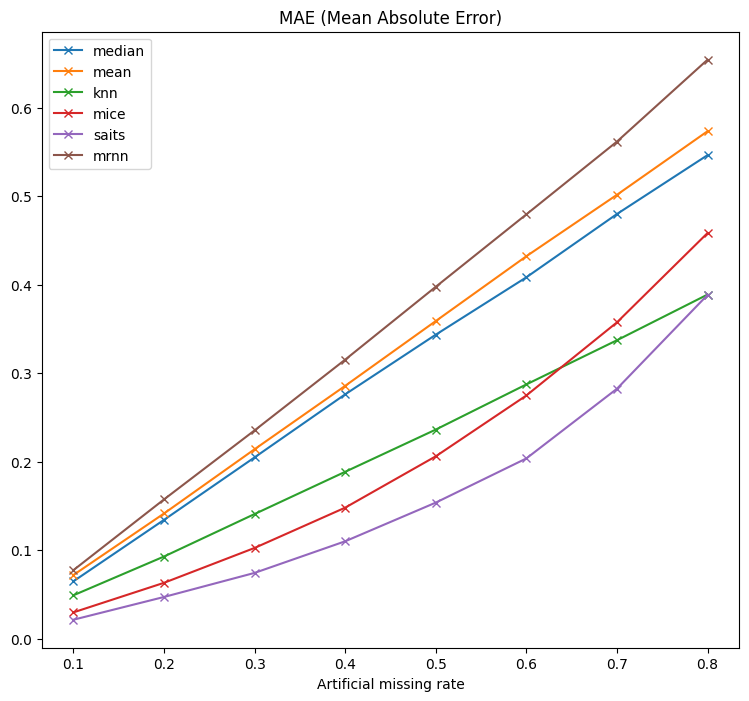

In [63]:
# MAE
df_mae = pd.read_excel('data/MAE_IF_Taiwan2015_0.1_0.82024-05-31 09:00:32.238374.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_mae.plot(title='MAE (Mean Absolute Error)',x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'MSE (Mean Squared Error)'}, xlabel='Artificial missing rate'>

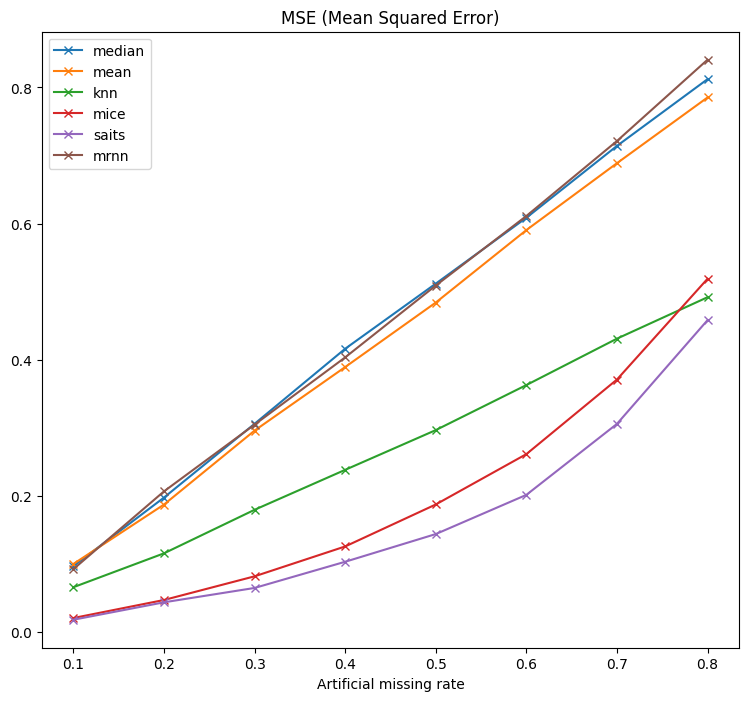

In [64]:
# MSE
df_mse = pd.read_excel('data/MSE_IF_Taiwan2015_0.1_0.82024-05-31 09:00:33.109302.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_mse.plot(title='MSE (Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'RMSE (Root Mean Squared Error)'}, xlabel='Artificial missing rate'>

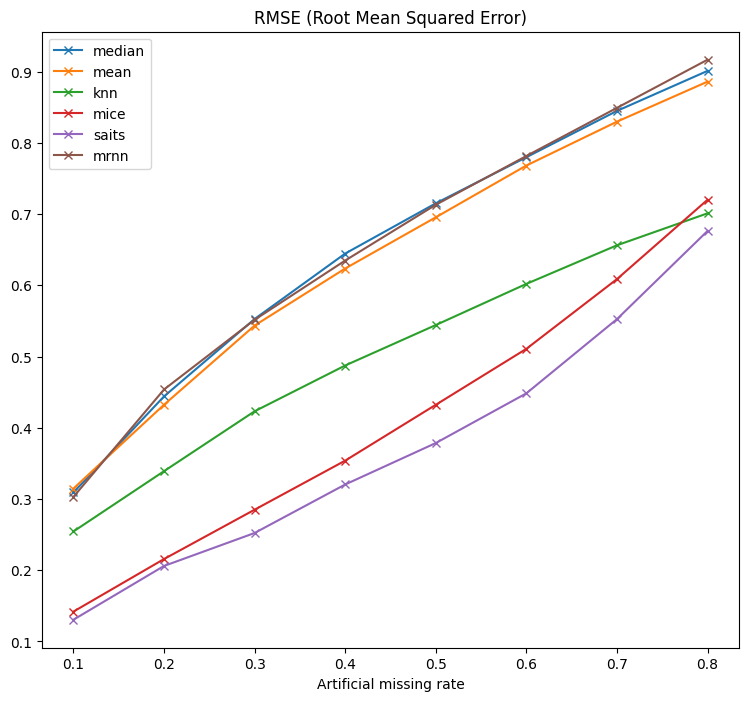

In [65]:
# RMSE
df_rmse = pd.read_excel('data/RMSE_IF_Taiwan2015_0.1_0.82024-05-31 09:00:33.137104.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_rmse.plot(title='RMSE (Root Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'Running time'}, xlabel='Artificial missing rate'>

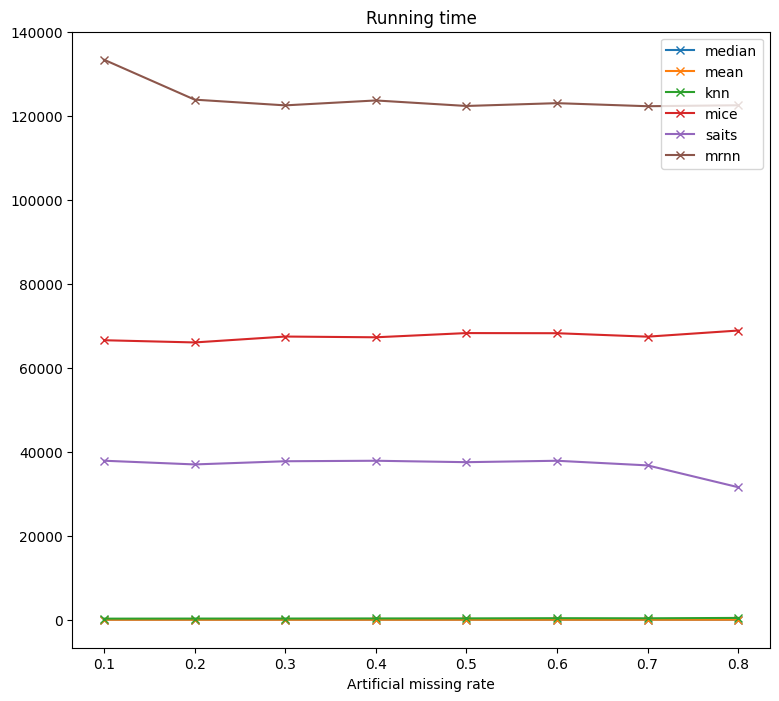

In [66]:
# Running_time
df_running_time = pd.read_excel('data/RunningTime_IF_Taiwan2015_0.1_0.82024-05-31 09:00:33.167975.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_running_time.plot(title='Running time', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')


